# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.0 GB  | Proc size: 50.6 MB
GPU RAM Free: 10848MB | Used: 416MB | Util   4% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [ ]:
seqs

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [ ]:
len(seqs)

In [ ]:
len(seqs_train)

In [ ]:
len(seqs_test)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [25]:
def get_denoise_model(activate,shape, do = 0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate , padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [26]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 5), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
#denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


In [29]:
from keras.layers import LeakyReLU
shape = (32, 32, 1)
denoise_model_adam_relu = get_denoise_model('relu', shape)
denoise_model_adam_elu = get_denoise_model('elu', shape)
denoise_model_adam_selu = get_denoise_model('selu', shape)
denoise_model_adam_lin = get_denoise_model('linear', shape)


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [30]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

denoise_model_adam_relu.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_elu.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_selu.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_lin.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])


#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam_relu = denoise_model_adam_relu.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_elu = denoise_model_adam_elu.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_selu = denoise_model_adam_selu.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_lin = denoise_model_adam_lin.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)


### Saves optimizer and weights


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


Instructions for updating:
Use tf.cast instead.
Epoch 1/5


 239/1816 [==>...........................] - ETA: 10:02:41 - loss: 121.6162 - mean_absolute_error: 121.616 - ETA: 3:21:25 - loss: 119.6298 - mean_absolute_error: 119.629 - ETA: 2:01:25 - loss: 118.3544 - mean_absolute_error: 118.35 - ETA: 1:27:02 - loss: 119.5576 - mean_absolute_error: 119.55 - ETA: 1:07:54 - loss: 116.6172 - mean_absolute_error: 116.61 - ETA: 55:44 - loss: 114.4151 - mean_absolute_error: 114.4151 - ETA: 47:20 - loss: 111.9493 - mean_absolute_error: 111.94 - ETA: 44:03 - loss: 110.3480 - mean_absolute_error: 110.34 - ETA: 38:39 - loss: 106.9715 - mean_absolute_error: 106.97 - ETA: 34:28 - loss: 103.1843 - mean_absolute_error: 103.18 - ETA: 31:06 - loss: 98.4377 - mean_absolute_error: 98.4377 - ETA: 28:22 - loss: 94.8797 - mean_absolute_error: 94.87 - ETA: 26:06 - loss: 90.5982 - mean_absolute_error: 90.59 - ETA: 25:06 - loss: 88.5703 - mean_absolute_error: 88.57 - ETA: 24:11 - loss: 86.8398 - mean_absolute_error: 86.83 - ETA: 22:32 - loss: 83.8716 - mean_absolute_error

 474/1816 [======>.......................] - ETA: 3:22 - loss: 21.5253 - mean_absolute_error: 21.525 - ETA: 3:21 - loss: 21.4693 - mean_absolute_error: 21.469 - ETA: 3:20 - loss: 21.3595 - mean_absolute_error: 21.359 - ETA: 3:19 - loss: 21.3073 - mean_absolute_error: 21.307 - ETA: 3:19 - loss: 21.2508 - mean_absolute_error: 21.250 - ETA: 3:18 - loss: 21.1434 - mean_absolute_error: 21.143 - ETA: 3:16 - loss: 21.0383 - mean_absolute_error: 21.038 - ETA: 3:15 - loss: 20.9332 - mean_absolute_error: 20.933 - ETA: 3:14 - loss: 20.8301 - mean_absolute_error: 20.830 - ETA: 3:12 - loss: 20.7283 - mean_absolute_error: 20.728 - ETA: 3:12 - loss: 20.6778 - mean_absolute_error: 20.677 - ETA: 3:11 - loss: 20.5736 - mean_absolute_error: 20.573 - ETA: 3:10 - loss: 20.4763 - mean_absolute_error: 20.476 - ETA: 3:08 - loss: 20.3805 - mean_absolute_error: 20.380 - ETA: 3:07 - loss: 20.2825 - mean_absolute_error: 20.282 - ETA: 3:06 - loss: 20.1920 - mean_absolute_error: 20.192 - ETA: 3:06 - loss: 20.1455 -

 730/1816 [===========>..................] - ETA: 1:57 - loss: 14.6545 - mean_absolute_error: 14.654 - ETA: 1:57 - loss: 14.6245 - mean_absolute_error: 14.624 - ETA: 1:56 - loss: 14.5960 - mean_absolute_error: 14.596 - ETA: 1:56 - loss: 14.5795 - mean_absolute_error: 14.579 - ETA: 1:56 - loss: 14.5483 - mean_absolute_error: 14.548 - ETA: 1:56 - loss: 14.5344 - mean_absolute_error: 14.534 - ETA: 1:55 - loss: 14.5044 - mean_absolute_error: 14.504 - ETA: 1:55 - loss: 14.4756 - mean_absolute_error: 14.475 - ETA: 1:54 - loss: 14.4468 - mean_absolute_error: 14.446 - ETA: 1:54 - loss: 14.4173 - mean_absolute_error: 14.417 - ETA: 1:53 - loss: 14.3895 - mean_absolute_error: 14.389 - ETA: 1:53 - loss: 14.3765 - mean_absolute_error: 14.376 - ETA: 1:53 - loss: 14.3474 - mean_absolute_error: 14.347 - ETA: 1:53 - loss: 14.3176 - mean_absolute_error: 14.317 - ETA: 1:52 - loss: 14.2905 - mean_absolute_error: 14.290 - ETA: 1:52 - loss: 14.2610 - mean_absolute_error: 14.261 - ETA: 1:51 - loss: 14.2321 -

 999/1816 [===============>..............] - ETA: 1:18 - loss: 12.0612 - mean_absolute_error: 12.061 - ETA: 1:17 - loss: 12.0489 - mean_absolute_error: 12.048 - ETA: 1:17 - loss: 12.0353 - mean_absolute_error: 12.035 - ETA: 1:17 - loss: 12.0206 - mean_absolute_error: 12.020 - ETA: 1:17 - loss: 12.0057 - mean_absolute_error: 12.005 - ETA: 1:16 - loss: 11.9918 - mean_absolute_error: 11.991 - ETA: 1:16 - loss: 11.9796 - mean_absolute_error: 11.979 - ETA: 1:16 - loss: 11.9663 - mean_absolute_error: 11.966 - ETA: 1:16 - loss: 11.9527 - mean_absolute_error: 11.952 - ETA: 1:16 - loss: 11.9399 - mean_absolute_error: 11.939 - ETA: 1:15 - loss: 11.9283 - mean_absolute_error: 11.928 - ETA: 1:15 - loss: 11.9171 - mean_absolute_error: 11.917 - ETA: 1:15 - loss: 11.9054 - mean_absolute_error: 11.905 - ETA: 1:15 - loss: 11.8924 - mean_absolute_error: 11.892 - ETA: 1:14 - loss: 11.8796 - mean_absolute_error: 11.879 - ETA: 1:14 - loss: 11.8665 - mean_absolute_error: 11.866 - ETA: 1:14 - loss: 11.8536 -

1273/1816 [====================>.........] - ETA: 52s - loss: 10.6885 - mean_absolute_error: 10.68 - ETA: 51s - loss: 10.6812 - mean_absolute_error: 10.68 - ETA: 51s - loss: 10.6742 - mean_absolute_error: 10.67 - ETA: 51s - loss: 10.6670 - mean_absolute_error: 10.66 - ETA: 51s - loss: 10.6598 - mean_absolute_error: 10.65 - ETA: 51s - loss: 10.6524 - mean_absolute_error: 10.65 - ETA: 51s - loss: 10.6449 - mean_absolute_error: 10.64 - ETA: 50s - loss: 10.6384 - mean_absolute_error: 10.63 - ETA: 50s - loss: 10.6308 - mean_absolute_error: 10.63 - ETA: 50s - loss: 10.6244 - mean_absolute_error: 10.62 - ETA: 50s - loss: 10.6174 - mean_absolute_error: 10.61 - ETA: 50s - loss: 10.6139 - mean_absolute_error: 10.61 - ETA: 50s - loss: 10.6101 - mean_absolute_error: 10.61 - ETA: 50s - loss: 10.6061 - mean_absolute_error: 10.60 - ETA: 50s - loss: 10.5992 - mean_absolute_error: 10.59 - ETA: 50s - loss: 10.5963 - mean_absolute_error: 10.59 - ETA: 49s - loss: 10.5898 - mean_absolute_error: 10.58 - ETA

1521/1816 [========================>.....] - ETA: 32s - loss: 9.8464 - mean_absolute_error: 9.84 - ETA: 32s - loss: 9.8412 - mean_absolute_error: 9.84 - ETA: 31s - loss: 9.8358 - mean_absolute_error: 9.83 - ETA: 31s - loss: 9.8312 - mean_absolute_error: 9.83 - ETA: 31s - loss: 9.8262 - mean_absolute_error: 9.82 - ETA: 31s - loss: 9.8208 - mean_absolute_error: 9.82 - ETA: 31s - loss: 9.8155 - mean_absolute_error: 9.81 - ETA: 31s - loss: 9.8100 - mean_absolute_error: 9.81 - ETA: 31s - loss: 9.8052 - mean_absolute_error: 9.80 - ETA: 30s - loss: 9.8007 - mean_absolute_error: 9.80 - ETA: 30s - loss: 9.7966 - mean_absolute_error: 9.79 - ETA: 30s - loss: 9.7915 - mean_absolute_error: 9.79 - ETA: 30s - loss: 9.7861 - mean_absolute_error: 9.78 - ETA: 30s - loss: 9.7811 - mean_absolute_error: 9.78 - ETA: 30s - loss: 9.7759 - mean_absolute_error: 9.77 - ETA: 30s - loss: 9.7714 - mean_absolute_error: 9.77 - ETA: 30s - loss: 9.7673 - mean_absolute_error: 9.76 - ETA: 29s - loss: 9.7634 - mean_absolu

1718/1816 [===========================>..] - ETA: 16s - loss: 9.3147 - mean_absolute_error: 9.31 - ETA: 16s - loss: 9.3130 - mean_absolute_error: 9.31 - ETA: 16s - loss: 9.3110 - mean_absolute_error: 9.31 - ETA: 16s - loss: 9.3095 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.3077 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.3060 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.3042 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.3020 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.3003 - mean_absolute_error: 9.30 - ETA: 16s - loss: 9.2964 - mean_absolute_error: 9.29 - ETA: 16s - loss: 9.2948 - mean_absolute_error: 9.29 - ETA: 16s - loss: 9.2932 - mean_absolute_error: 9.29 - ETA: 15s - loss: 9.2915 - mean_absolute_error: 9.29 - ETA: 15s - loss: 9.2902 - mean_absolute_error: 9.29 - ETA: 15s - loss: 9.2872 - mean_absolute_error: 9.28 - ETA: 15s - loss: 9.2832 - mean_absolute_error: 9.28 - ETA: 15s - loss: 9.2801 - mean_absolute_error: 9.28 - ETA: 15s - loss: 9.2765 - mean_absolu

1816/1816 [==============================] - ETA: 5s - loss: 8.9910 - mean_absolute_error: 8.991 - ETA: 5s - loss: 8.9883 - mean_absolute_error: 8.988 - ETA: 5s - loss: 8.9857 - mean_absolute_error: 8.985 - ETA: 5s - loss: 8.9830 - mean_absolute_error: 8.983 - ETA: 5s - loss: 8.9817 - mean_absolute_error: 8.981 - ETA: 4s - loss: 8.9805 - mean_absolute_error: 8.980 - ETA: 4s - loss: 8.9776 - mean_absolute_error: 8.977 - ETA: 4s - loss: 8.9747 - mean_absolute_error: 8.974 - ETA: 4s - loss: 8.9713 - mean_absolute_error: 8.971 - ETA: 4s - loss: 8.9693 - mean_absolute_error: 8.969 - ETA: 4s - loss: 8.9664 - mean_absolute_error: 8.966 - ETA: 4s - loss: 8.9649 - mean_absolute_error: 8.964 - ETA: 4s - loss: 8.9617 - mean_absolute_error: 8.961 - ETA: 4s - loss: 8.9591 - mean_absolute_error: 8.959 - ETA: 4s - loss: 8.9572 - mean_absolute_error: 8.957 - ETA: 3s - loss: 8.9545 - mean_absolute_error: 8.954 - ETA: 3s - loss: 8.9519 - mean_absolute_error: 8.951 - ETA: 3s - loss: 8.9493 - mean_absolut

 226/1816 [==>...........................] - ETA: 1:10 - loss: 6.3565 - mean_absolute_error: 6.356 - ETA: 1:12 - loss: 6.1217 - mean_absolute_error: 6.121 - ETA: 1:24 - loss: 6.2625 - mean_absolute_error: 6.262 - ETA: 1:32 - loss: 6.2260 - mean_absolute_error: 6.226 - ETA: 1:35 - loss: 6.2267 - mean_absolute_error: 6.226 - ETA: 1:36 - loss: 6.3115 - mean_absolute_error: 6.311 - ETA: 1:36 - loss: 6.3200 - mean_absolute_error: 6.320 - ETA: 1:35 - loss: 6.3141 - mean_absolute_error: 6.314 - ETA: 1:36 - loss: 6.2952 - mean_absolute_error: 6.295 - ETA: 1:38 - loss: 6.2882 - mean_absolute_error: 6.288 - ETA: 1:38 - loss: 6.3152 - mean_absolute_error: 6.315 - ETA: 1:38 - loss: 6.2815 - mean_absolute_error: 6.281 - ETA: 1:37 - loss: 6.2994 - mean_absolute_error: 6.299 - ETA: 1:37 - loss: 6.3317 - mean_absolute_error: 6.331 - ETA: 1:36 - loss: 6.3204 - mean_absolute_error: 6.320 - ETA: 1:35 - loss: 6.3039 - mean_absolute_error: 6.303 - ETA: 1:36 - loss: 6.2936 - mean_absolute_error: 6.293 - ETA

 493/1816 [=======>......................] - ETA: 1:15 - loss: 6.3343 - mean_absolute_error: 6.334 - ETA: 1:15 - loss: 6.3322 - mean_absolute_error: 6.332 - ETA: 1:15 - loss: 6.3346 - mean_absolute_error: 6.334 - ETA: 1:15 - loss: 6.3356 - mean_absolute_error: 6.335 - ETA: 1:15 - loss: 6.3316 - mean_absolute_error: 6.331 - ETA: 1:15 - loss: 6.3312 - mean_absolute_error: 6.331 - ETA: 1:15 - loss: 6.3294 - mean_absolute_error: 6.329 - ETA: 1:14 - loss: 6.3313 - mean_absolute_error: 6.331 - ETA: 1:14 - loss: 6.3337 - mean_absolute_error: 6.333 - ETA: 1:14 - loss: 6.3309 - mean_absolute_error: 6.330 - ETA: 1:14 - loss: 6.3305 - mean_absolute_error: 6.330 - ETA: 1:14 - loss: 6.3289 - mean_absolute_error: 6.328 - ETA: 1:14 - loss: 6.3273 - mean_absolute_error: 6.327 - ETA: 1:14 - loss: 6.3273 - mean_absolute_error: 6.327 - ETA: 1:14 - loss: 6.3264 - mean_absolute_error: 6.326 - ETA: 1:14 - loss: 6.3260 - mean_absolute_error: 6.326 - ETA: 1:13 - loss: 6.3278 - mean_absolute_error: 6.327 - ETA

 756/1816 [===========>..................] - ETA: 1:00 - loss: 6.3091 - mean_absolute_error: 6.309 - ETA: 1:00 - loss: 6.3099 - mean_absolute_error: 6.309 - ETA: 1:00 - loss: 6.3091 - mean_absolute_error: 6.309 - ETA: 1:00 - loss: 6.3087 - mean_absolute_error: 6.308 - ETA: 1:00 - loss: 6.3088 - mean_absolute_error: 6.308 - ETA: 1:00 - loss: 6.3092 - mean_absolute_error: 6.309 - ETA: 1:00 - loss: 6.3087 - mean_absolute_error: 6.308 - ETA: 1:00 - loss: 6.3073 - mean_absolute_error: 6.307 - ETA: 1:00 - loss: 6.3080 - mean_absolute_error: 6.308 - ETA: 1:00 - loss: 6.3082 - mean_absolute_error: 6.308 - ETA: 59s - loss: 6.3088 - mean_absolute_error: 6.308 - ETA: 59s - loss: 6.3069 - mean_absolute_error: 6.30 - ETA: 59s - loss: 6.3055 - mean_absolute_error: 6.30 - ETA: 59s - loss: 6.3049 - mean_absolute_error: 6.30 - ETA: 59s - loss: 6.3072 - mean_absolute_error: 6.30 - ETA: 59s - loss: 6.3072 - mean_absolute_error: 6.30 - ETA: 59s - loss: 6.3069 - mean_absolute_error: 6.30 - ETA: 59s - loss:

1016/1816 [===============>..............] - ETA: 48s - loss: 6.2612 - mean_absolute_error: 6.26 - ETA: 48s - loss: 6.2605 - mean_absolute_error: 6.26 - ETA: 48s - loss: 6.2598 - mean_absolute_error: 6.25 - ETA: 48s - loss: 6.2585 - mean_absolute_error: 6.25 - ETA: 48s - loss: 6.2590 - mean_absolute_error: 6.25 - ETA: 48s - loss: 6.2595 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2590 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2589 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2585 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2600 - mean_absolute_error: 6.26 - ETA: 47s - loss: 6.2592 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2590 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2594 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2586 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2587 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2586 - mean_absolute_error: 6.25 - ETA: 47s - loss: 6.2588 - mean_absolute_error: 6.25 - ETA: 46s - loss: 6.2585 - mean_absolu

1286/1816 [====================>.........] - ETA: 36s - loss: 6.2250 - mean_absolute_error: 6.22 - ETA: 36s - loss: 6.2247 - mean_absolute_error: 6.22 - ETA: 36s - loss: 6.2246 - mean_absolute_error: 6.22 - ETA: 36s - loss: 6.2240 - mean_absolute_error: 6.22 - ETA: 36s - loss: 6.2238 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2236 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2240 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2235 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2231 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2229 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2225 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2223 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2226 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2224 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2215 - mean_absolute_error: 6.22 - ETA: 35s - loss: 6.2213 - mean_absolute_error: 6.22 - ETA: 34s - loss: 6.2207 - mean_absolute_error: 6.22 - ETA: 34s - loss: 6.2195 - mean_absolu

1549/1816 [========================>.....] - ETA: 24s - loss: 6.2083 - mean_absolute_error: 6.20 - ETA: 24s - loss: 6.2080 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2080 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2075 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2074 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2068 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2059 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2059 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2056 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2050 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2049 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2050 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2049 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2045 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2040 - mean_absolute_error: 6.20 - ETA: 23s - loss: 6.2039 - mean_absolute_error: 6.20 - ETA: 22s - loss: 6.2032 - mean_absolute_error: 6.20 - ETA: 22s - loss: 6.2029 - mean_absolu

1816/1816 [==============================] - ETA: 12s - loss: 6.1746 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1751 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1744 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1737 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1732 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1729 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1730 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1726 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1726 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1726 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1723 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1720 - mean_absolute_error: 6.17 - ETA: 11s - loss: 6.1718 - mean_absolute_error: 6.17 - ETA: 10s - loss: 6.1717 - mean_absolute_error: 6.17 - ETA: 10s - loss: 6.1714 - mean_absolute_error: 6.17 - ETA: 10s - loss: 6.1708 - mean_absolute_error: 6.17 - ETA: 10s - loss: 6.1710 - mean_absolute_error: 6.17 - ETA: 10s - loss: 6.1714 - mean_absolu

 242/1816 [==>...........................] - ETA: 1:25 - loss: 5.7368 - mean_absolute_error: 5.736 - ETA: 1:20 - loss: 5.6833 - mean_absolute_error: 5.683 - ETA: 1:16 - loss: 5.7651 - mean_absolute_error: 5.765 - ETA: 1:19 - loss: 5.8469 - mean_absolute_error: 5.846 - ETA: 1:20 - loss: 5.8994 - mean_absolute_error: 5.899 - ETA: 1:21 - loss: 5.9669 - mean_absolute_error: 5.966 - ETA: 1:21 - loss: 5.9316 - mean_absolute_error: 5.931 - ETA: 1:20 - loss: 5.9464 - mean_absolute_error: 5.946 - ETA: 1:20 - loss: 5.9066 - mean_absolute_error: 5.906 - ETA: 1:19 - loss: 5.8901 - mean_absolute_error: 5.890 - ETA: 1:18 - loss: 5.8771 - mean_absolute_error: 5.877 - ETA: 1:18 - loss: 5.8670 - mean_absolute_error: 5.867 - ETA: 1:19 - loss: 5.8789 - mean_absolute_error: 5.878 - ETA: 1:19 - loss: 5.8833 - mean_absolute_error: 5.883 - ETA: 1:19 - loss: 5.8799 - mean_absolute_error: 5.879 - ETA: 1:20 - loss: 5.8661 - mean_absolute_error: 5.866 - ETA: 1:20 - loss: 5.8942 - mean_absolute_error: 5.894 - ETA

 488/1816 [=======>......................] - ETA: 1:12 - loss: 5.9818 - mean_absolute_error: 5.981 - ETA: 1:12 - loss: 5.9828 - mean_absolute_error: 5.982 - ETA: 1:12 - loss: 5.9803 - mean_absolute_error: 5.980 - ETA: 1:12 - loss: 5.9803 - mean_absolute_error: 5.980 - ETA: 1:12 - loss: 5.9774 - mean_absolute_error: 5.977 - ETA: 1:12 - loss: 5.9763 - mean_absolute_error: 5.976 - ETA: 1:12 - loss: 5.9748 - mean_absolute_error: 5.974 - ETA: 1:12 - loss: 5.9748 - mean_absolute_error: 5.974 - ETA: 1:12 - loss: 5.9732 - mean_absolute_error: 5.973 - ETA: 1:12 - loss: 5.9781 - mean_absolute_error: 5.978 - ETA: 1:12 - loss: 5.9760 - mean_absolute_error: 5.976 - ETA: 1:11 - loss: 5.9761 - mean_absolute_error: 5.976 - ETA: 1:11 - loss: 5.9765 - mean_absolute_error: 5.976 - ETA: 1:11 - loss: 5.9770 - mean_absolute_error: 5.977 - ETA: 1:11 - loss: 5.9780 - mean_absolute_error: 5.978 - ETA: 1:11 - loss: 5.9772 - mean_absolute_error: 5.977 - ETA: 1:11 - loss: 5.9765 - mean_absolute_error: 5.976 - ETA

 751/1816 [===========>..................] - ETA: 1:01 - loss: 5.9540 - mean_absolute_error: 5.954 - ETA: 1:01 - loss: 5.9523 - mean_absolute_error: 5.952 - ETA: 1:01 - loss: 5.9505 - mean_absolute_error: 5.950 - ETA: 1:01 - loss: 5.9517 - mean_absolute_error: 5.951 - ETA: 1:00 - loss: 5.9488 - mean_absolute_error: 5.948 - ETA: 1:00 - loss: 5.9486 - mean_absolute_error: 5.948 - ETA: 1:00 - loss: 5.9486 - mean_absolute_error: 5.948 - ETA: 1:00 - loss: 5.9483 - mean_absolute_error: 5.948 - ETA: 1:00 - loss: 5.9504 - mean_absolute_error: 5.950 - ETA: 1:00 - loss: 5.9501 - mean_absolute_error: 5.950 - ETA: 1:00 - loss: 5.9522 - mean_absolute_error: 5.952 - ETA: 1:00 - loss: 5.9538 - mean_absolute_error: 5.953 - ETA: 1:00 - loss: 5.9547 - mean_absolute_error: 5.954 - ETA: 1:00 - loss: 5.9563 - mean_absolute_error: 5.956 - ETA: 59s - loss: 5.9561 - mean_absolute_error: 5.956 - ETA: 59s - loss: 5.9551 - mean_absolute_error: 5.95 - ETA: 59s - loss: 5.9529 - mean_absolute_error: 5.95 - ETA: 59s

1010/1816 [===============>..............] - ETA: 48s - loss: 5.9416 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9412 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9406 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9412 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9413 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9410 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9408 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9408 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9405 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9405 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9405 - mean_absolute_error: 5.94 - ETA: 48s - loss: 5.9396 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9398 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9393 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9381 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9378 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9377 - mean_absolute_error: 5.93 - ETA: 48s - loss: 5.9362 - mean_absolu

1271/1816 [===================>..........] - ETA: 36s - loss: 5.9277 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9269 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9262 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9268 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9271 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9269 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9269 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9269 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9270 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9265 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9270 - mean_absolute_error: 5.92 - ETA: 36s - loss: 5.9264 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9261 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9254 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9256 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9253 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9248 - mean_absolute_error: 5.92 - ETA: 35s - loss: 5.9243 - mean_absolu

1529/1816 [========================>.....] - ETA: 24s - loss: 5.9153 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9154 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9156 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9155 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9157 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9159 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9155 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9154 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9156 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9159 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9152 - mean_absolute_error: 5.91 - ETA: 24s - loss: 5.9151 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9143 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9144 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9143 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9140 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9136 - mean_absolute_error: 5.91 - ETA: 23s - loss: 5.9134 - mean_absolu

1792/1816 [============================>.] - ETA: 13s - loss: 5.9061 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9057 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9052 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9055 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9057 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9053 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9055 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9052 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9047 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9044 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9036 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9040 - mean_absolute_error: 5.90 - ETA: 12s - loss: 5.9042 - mean_absolute_error: 5.90 - ETA: 11s - loss: 5.9042 - mean_absolute_error: 5.90 - ETA: 11s - loss: 5.9031 - mean_absolute_error: 5.90 - ETA: 11s - loss: 5.9029 - mean_absolute_error: 5.90 - ETA: 11s - loss: 5.9031 - mean_absolute_error: 5.90 - ETA: 11s - loss: 5.9031 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.8878 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8879 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8879 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8877 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8880 - mean_absolute_error: 5.888 - ETA: 0s - loss: 5.8880 - mean_absolute_error: 5.888 - ETA: 0s - loss: 5.8874 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8870 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8871 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8871 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8870 - mean_absolute_error: 5.887 - ETA: 0s - loss: 5.8866 - mean_absolute_error: 5.886 - ETA: 0s - loss: 5.8868 - mean_absolute_error: 5.886 - ETA: 0s - loss: 5.8877 - mean_absolute_error: 5.887 - 89s 49ms/step - loss: 5.8876 - mean_absolute_error: 5.8876 - val_loss: 5.3760 - val_mean_absolute_error: 5.3760
Epoch 4/5


 258/1816 [===>..........................] - ETA: 1:19 - loss: 5.4837 - mean_absolute_error: 5.483 - ETA: 1:23 - loss: 5.5296 - mean_absolute_error: 5.529 - ETA: 1:20 - loss: 5.7017 - mean_absolute_error: 5.701 - ETA: 1:19 - loss: 5.8011 - mean_absolute_error: 5.801 - ETA: 1:18 - loss: 5.8222 - mean_absolute_error: 5.822 - ETA: 1:20 - loss: 5.8284 - mean_absolute_error: 5.828 - ETA: 1:19 - loss: 5.7962 - mean_absolute_error: 5.796 - ETA: 1:20 - loss: 5.8445 - mean_absolute_error: 5.844 - ETA: 1:20 - loss: 5.8551 - mean_absolute_error: 5.855 - ETA: 1:19 - loss: 5.8602 - mean_absolute_error: 5.860 - ETA: 1:19 - loss: 5.8437 - mean_absolute_error: 5.843 - ETA: 1:19 - loss: 5.8447 - mean_absolute_error: 5.844 - ETA: 1:20 - loss: 5.8580 - mean_absolute_error: 5.858 - ETA: 1:20 - loss: 5.8117 - mean_absolute_error: 5.811 - ETA: 1:20 - loss: 5.8455 - mean_absolute_error: 5.845 - ETA: 1:19 - loss: 5.8136 - mean_absolute_error: 5.813 - ETA: 1:19 - loss: 5.8017 - mean_absolute_error: 5.801 - ETA

 511/1816 [=======>......................] - ETA: 1:10 - loss: 5.7842 - mean_absolute_error: 5.784 - ETA: 1:10 - loss: 5.7859 - mean_absolute_error: 5.785 - ETA: 1:10 - loss: 5.7848 - mean_absolute_error: 5.784 - ETA: 1:10 - loss: 5.7859 - mean_absolute_error: 5.785 - ETA: 1:10 - loss: 5.7866 - mean_absolute_error: 5.786 - ETA: 1:10 - loss: 5.7847 - mean_absolute_error: 5.784 - ETA: 1:10 - loss: 5.7840 - mean_absolute_error: 5.784 - ETA: 1:09 - loss: 5.7881 - mean_absolute_error: 5.788 - ETA: 1:09 - loss: 5.7871 - mean_absolute_error: 5.787 - ETA: 1:09 - loss: 5.7857 - mean_absolute_error: 5.785 - ETA: 1:09 - loss: 5.7889 - mean_absolute_error: 5.788 - ETA: 1:09 - loss: 5.7890 - mean_absolute_error: 5.789 - ETA: 1:09 - loss: 5.7879 - mean_absolute_error: 5.787 - ETA: 1:09 - loss: 5.7876 - mean_absolute_error: 5.787 - ETA: 1:09 - loss: 5.7898 - mean_absolute_error: 5.789 - ETA: 1:09 - loss: 5.7880 - mean_absolute_error: 5.788 - ETA: 1:08 - loss: 5.7868 - mean_absolute_error: 5.786 - ETA

 770/1816 [===========>..................] - ETA: 59s - loss: 5.7890 - mean_absolute_error: 5.78 - ETA: 59s - loss: 5.7890 - mean_absolute_error: 5.78 - ETA: 59s - loss: 5.7884 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7901 - mean_absolute_error: 5.79 - ETA: 58s - loss: 5.7893 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7889 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7904 - mean_absolute_error: 5.79 - ETA: 58s - loss: 5.7911 - mean_absolute_error: 5.79 - ETA: 58s - loss: 5.7898 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7900 - mean_absolute_error: 5.79 - ETA: 58s - loss: 5.7886 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7878 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7886 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7882 - mean_absolute_error: 5.78 - ETA: 58s - loss: 5.7878 - mean_absolute_error: 5.78 - ETA: 57s - loss: 5.7878 - mean_absolute_error: 5.78 - ETA: 57s - loss: 5.7877 - mean_absolute_error: 5.78 - ETA: 57s - loss: 5.7869 - mean_absolu

1038/1816 [================>.............] - ETA: 47s - loss: 5.7719 - mean_absolute_error: 5.77 - ETA: 47s - loss: 5.7716 - mean_absolute_error: 5.77 - ETA: 47s - loss: 5.7713 - mean_absolute_error: 5.77 - ETA: 47s - loss: 5.7713 - mean_absolute_error: 5.77 - ETA: 46s - loss: 5.7698 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7686 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7686 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7692 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7688 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7689 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7694 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7691 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7693 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7693 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7689 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7693 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7690 - mean_absolute_error: 5.76 - ETA: 46s - loss: 5.7676 - mean_absolu

1316/1816 [====================>.........] - ETA: 35s - loss: 5.7647 - mean_absolute_error: 5.76 - ETA: 35s - loss: 5.7644 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7639 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7636 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7626 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7621 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7624 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7629 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7630 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7622 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7620 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7615 - mean_absolute_error: 5.76 - ETA: 34s - loss: 5.7634 - mean_absolute_error: 5.76 - ETA: 33s - loss: 5.7630 - mean_absolute_error: 5.76 - ETA: 33s - loss: 5.7631 - mean_absolute_error: 5.76 - ETA: 33s - loss: 5.7629 - mean_absolute_error: 5.76 - ETA: 33s - loss: 5.7625 - mean_absolute_error: 5.76 - ETA: 33s - loss: 5.7618 - mean_absolu

1587/1816 [=========================>....] - ETA: 22s - loss: 5.7539 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7538 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7537 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7536 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7536 - mean_absolute_error: 5.75 - ETA: 22s - loss: 5.7536 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7536 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7534 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7529 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7531 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7535 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7528 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7523 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7526 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7526 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7530 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7531 - mean_absolute_error: 5.75 - ETA: 21s - loss: 5.7533 - mean_absolu

1816/1816 [==============================] - ETA: 10s - loss: 5.7401 - mean_absolute_error: 5.74 - ETA: 10s - loss: 5.7401 - mean_absolute_error: 5.74 - ETA: 10s - loss: 5.7400 - mean_absolute_error: 5.74 - ETA: 9s - loss: 5.7405 - mean_absolute_error: 5.7405 - ETA: 9s - loss: 5.7397 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7390 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7390 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7389 - mean_absolute_error: 5.738 - ETA: 9s - loss: 5.7390 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7390 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7390 - mean_absolute_error: 5.739 - ETA: 9s - loss: 5.7387 - mean_absolute_error: 5.738 - ETA: 9s - loss: 5.7377 - mean_absolute_error: 5.737 - ETA: 9s - loss: 5.7379 - mean_absolute_error: 5.737 - ETA: 8s - loss: 5.7381 - mean_absolute_error: 5.738 - ETA: 8s - loss: 5.7376 - mean_absolute_error: 5.737 - ETA: 8s - loss: 5.7376 - mean_absolute_error: 5.737 - ETA: 8s - loss: 5.7376 - mean_absolu

 253/1816 [===>..........................] - ETA: 1:16 - loss: 5.0694 - mean_absolute_error: 5.069 - ETA: 1:16 - loss: 5.3966 - mean_absolute_error: 5.396 - ETA: 1:19 - loss: 5.5524 - mean_absolute_error: 5.552 - ETA: 1:20 - loss: 5.5992 - mean_absolute_error: 5.599 - ETA: 1:20 - loss: 5.6368 - mean_absolute_error: 5.636 - ETA: 1:20 - loss: 5.6589 - mean_absolute_error: 5.658 - ETA: 1:19 - loss: 5.6760 - mean_absolute_error: 5.676 - ETA: 1:19 - loss: 5.6739 - mean_absolute_error: 5.673 - ETA: 1:19 - loss: 5.6526 - mean_absolute_error: 5.652 - ETA: 1:19 - loss: 5.6763 - mean_absolute_error: 5.676 - ETA: 1:21 - loss: 5.6994 - mean_absolute_error: 5.699 - ETA: 1:20 - loss: 5.6969 - mean_absolute_error: 5.696 - ETA: 1:20 - loss: 5.7085 - mean_absolute_error: 5.708 - ETA: 1:19 - loss: 5.7208 - mean_absolute_error: 5.720 - ETA: 1:19 - loss: 5.6705 - mean_absolute_error: 5.670 - ETA: 1:19 - loss: 5.6746 - mean_absolute_error: 5.674 - ETA: 1:19 - loss: 5.7151 - mean_absolute_error: 5.715 - ETA

 534/1816 [=======>......................] - ETA: 1:09 - loss: 5.6590 - mean_absolute_error: 5.659 - ETA: 1:08 - loss: 5.6562 - mean_absolute_error: 5.656 - ETA: 1:08 - loss: 5.6620 - mean_absolute_error: 5.662 - ETA: 1:08 - loss: 5.6604 - mean_absolute_error: 5.660 - ETA: 1:08 - loss: 5.6608 - mean_absolute_error: 5.660 - ETA: 1:08 - loss: 5.6592 - mean_absolute_error: 5.659 - ETA: 1:08 - loss: 5.6581 - mean_absolute_error: 5.658 - ETA: 1:08 - loss: 5.6576 - mean_absolute_error: 5.657 - ETA: 1:07 - loss: 5.6581 - mean_absolute_error: 5.658 - ETA: 1:07 - loss: 5.6566 - mean_absolute_error: 5.656 - ETA: 1:07 - loss: 5.6575 - mean_absolute_error: 5.657 - ETA: 1:07 - loss: 5.6571 - mean_absolute_error: 5.657 - ETA: 1:07 - loss: 5.6595 - mean_absolute_error: 5.659 - ETA: 1:07 - loss: 5.6571 - mean_absolute_error: 5.657 - ETA: 1:07 - loss: 5.6557 - mean_absolute_error: 5.655 - ETA: 1:07 - loss: 5.6577 - mean_absolute_error: 5.657 - ETA: 1:07 - loss: 5.6556 - mean_absolute_error: 5.655 - ETA

 740/1816 [===========>..................] - ETA: 54s - loss: 5.6538 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6539 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6531 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6538 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6542 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6547 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6541 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6550 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6547 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6556 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6538 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6531 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6526 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6526 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6524 - mean_absolute_error: 5.65 - ETA: 54s - loss: 5.6528 - mean_absolu

 918/1816 [==============>...............] - ETA: 48s - loss: 5.6553 - mean_absolute_error: 5.65 - ETA: 48s - loss: 5.6548 - mean_absolute_error: 5.65 - ETA: 48s - loss: 5.6554 - mean_absolute_error: 5.65 - ETA: 48s - loss: 5.6554 - mean_absolute_error: 5.65 - ETA: 48s - loss: 5.6551 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6555 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6563 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6569 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6566 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6563 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6561 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6560 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6562 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6567 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6567 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6555 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6548 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6549 - mean_absolu

1093/1816 [=================>............] - ETA: 41s - loss: 5.6436 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6437 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6432 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6438 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6437 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6438 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6437 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6441 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6442 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6444 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6446 - mean_absolute_error: 5.64 - ETA: 41s - loss: 5.6447 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6451 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6458 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6460 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6459 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6466 - mean_absolute_error: 5.64 - ETA: 40s - loss: 5.6462 - mean_absolu

1264/1816 [===================>..........] - ETA: 34s - loss: 5.6430 - mean_absolute_error: 5.64 - ETA: 34s - loss: 5.6429 - mean_absolute_error: 5.64 - ETA: 34s - loss: 5.6428 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6432 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6431 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6430 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6429 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6432 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6436 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6435 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6433 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6433 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6434 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6435 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6435 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6437 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6434 - mean_absolute_error: 5.64 - ETA: 33s - loss: 5.6434 - mean_absolu

1449/1816 [======================>.......] - ETA: 26s - loss: 5.6396 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6398 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6397 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6400 - mean_absolute_error: 5.64 - ETA: 26s - loss: 5.6398 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6392 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6395 - mean_absolute_error: 5.63 - ETA: 25s - loss: 5.6394 - mean_absolute_error: 5.63 - ETA: 25s - loss: 5.6396 - mean_absolute_error: 5.63 - ETA: 25s - loss: 5.6399 - mean_absolute_error: 5.63 - ETA: 25s - loss: 5.6400 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6399 - mean_absolute_error: 5.63 - ETA: 25s - loss: 5.6402 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6402 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6403 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6406 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6404 - mean_absolute_error: 5.64 - ETA: 25s - loss: 5.6400 - mean_absolu

1637/1816 [==========================>...] - ETA: 17s - loss: 5.6390 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6387 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6388 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6387 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6389 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6390 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6394 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6397 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6394 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6390 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6388 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6385 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6384 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6386 - mean_absolute_error: 5.63 - ETA: 16s - loss: 5.6387 - mean_absolute_error: 5.63 - ETA: 16s - loss: 5.6387 - mean_absolute_error: 5.63 - ETA: 16s - loss: 5.6384 - mean_absolute_error: 5.63 - ETA: 16s - loss: 5.6385 - mean_absolu

1816/1816 [==============================] - ETA: 8s - loss: 5.6348 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6350 - mean_absolute_error: 5.635 - ETA: 8s - loss: 5.6349 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6350 - mean_absolute_error: 5.635 - ETA: 8s - loss: 5.6348 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6346 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6343 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6342 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6336 - mean_absolute_error: 5.633 - ETA: 8s - loss: 5.6340 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6343 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6342 - mean_absolute_error: 5.634 - ETA: 8s - loss: 5.6339 - mean_absolute_error: 5.633 - ETA: 7s - loss: 5.6337 - mean_absolute_error: 5.633 - ETA: 7s - loss: 5.6336 - mean_absolute_error: 5.633 - ETA: 7s - loss: 5.6339 - mean_absolute_error: 5.633 - ETA: 7s - loss: 5.6339 - mean_absolute_error: 5.633 - ETA: 7s - loss: 5.6341 - mean_absolut

 256/1816 [===>..........................] - ETA: 3:20:02 - loss: 118.6679 - mean_absolute_error: 118.66 - ETA: 1:07:25 - loss: 107.4778 - mean_absolute_error: 107.47 - ETA: 40:54 - loss: 102.6188 - mean_absolute_error: 102.6189 - ETA: 29:32 - loss: 96.0484 - mean_absolute_error: 96.0484 - ETA: 23:14 - loss: 86.0823 - mean_absolute_error: 86.08 - ETA: 19:13 - loss: 80.9223 - mean_absolute_error: 80.92 - ETA: 17:45 - loss: 77.7567 - mean_absolute_error: 77.75 - ETA: 16:30 - loss: 74.1930 - mean_absolute_error: 74.19 - ETA: 15:26 - loss: 71.1953 - mean_absolute_error: 71.19 - ETA: 14:30 - loss: 69.1370 - mean_absolute_error: 69.13 - ETA: 13:40 - loss: 67.3133 - mean_absolute_error: 67.31 - ETA: 12:18 - loss: 62.6265 - mean_absolute_error: 62.62 - ETA: 11:12 - loss: 58.8557 - mean_absolute_error: 58.85 - ETA: 10:44 - loss: 57.3376 - mean_absolute_error: 57.33 - ETA: 9:54 - loss: 54.2570 - mean_absolute_error: 54.2570 - ETA: 9:12 - loss: 51.5607 - mean_absolute_error: 51.560 - ETA: 8:36 - 

 526/1816 [=======>......................] - ETA: 1:45 - loss: 13.0129 - mean_absolute_error: 13.012 - ETA: 1:44 - loss: 12.9896 - mean_absolute_error: 12.989 - ETA: 1:44 - loss: 12.9428 - mean_absolute_error: 12.942 - ETA: 1:44 - loss: 12.9000 - mean_absolute_error: 12.900 - ETA: 1:43 - loss: 12.8579 - mean_absolute_error: 12.857 - ETA: 1:43 - loss: 12.8358 - mean_absolute_error: 12.835 - ETA: 1:43 - loss: 12.7928 - mean_absolute_error: 12.792 - ETA: 1:42 - loss: 12.7507 - mean_absolute_error: 12.750 - ETA: 1:42 - loss: 12.7312 - mean_absolute_error: 12.731 - ETA: 1:42 - loss: 12.7115 - mean_absolute_error: 12.711 - ETA: 1:42 - loss: 12.6723 - mean_absolute_error: 12.672 - ETA: 1:41 - loss: 12.6338 - mean_absolute_error: 12.633 - ETA: 1:41 - loss: 12.5979 - mean_absolute_error: 12.597 - ETA: 1:40 - loss: 12.5572 - mean_absolute_error: 12.557 - ETA: 1:40 - loss: 12.5176 - mean_absolute_error: 12.517 - ETA: 1:39 - loss: 12.4829 - mean_absolute_error: 12.482 - ETA: 1:39 - loss: 12.4470 -

 707/1816 [==========>...................] - ETA: 1:09 - loss: 9.9790 - mean_absolute_error: 9.979 - ETA: 1:09 - loss: 9.9730 - mean_absolute_error: 9.973 - ETA: 1:09 - loss: 9.9670 - mean_absolute_error: 9.967 - ETA: 1:09 - loss: 9.9604 - mean_absolute_error: 9.960 - ETA: 1:09 - loss: 9.9541 - mean_absolute_error: 9.954 - ETA: 1:09 - loss: 9.9482 - mean_absolute_error: 9.948 - ETA: 1:09 - loss: 9.9429 - mean_absolute_error: 9.942 - ETA: 1:09 - loss: 9.9376 - mean_absolute_error: 9.937 - ETA: 1:09 - loss: 9.9318 - mean_absolute_error: 9.931 - ETA: 1:09 - loss: 9.9183 - mean_absolute_error: 9.918 - ETA: 1:09 - loss: 9.9128 - mean_absolute_error: 9.912 - ETA: 1:09 - loss: 9.9074 - mean_absolute_error: 9.907 - ETA: 1:08 - loss: 9.9006 - mean_absolute_error: 9.900 - ETA: 1:08 - loss: 9.8950 - mean_absolute_error: 9.895 - ETA: 1:08 - loss: 9.8901 - mean_absolute_error: 9.890 - ETA: 1:08 - loss: 9.8851 - mean_absolute_error: 9.885 - ETA: 1:08 - loss: 9.8800 - mean_absolute_error: 9.880 - ETA

 886/1816 [=============>................] - ETA: 58s - loss: 9.1353 - mean_absolute_error: 9.13 - ETA: 58s - loss: 9.1333 - mean_absolute_error: 9.13 - ETA: 58s - loss: 9.1297 - mean_absolute_error: 9.12 - ETA: 58s - loss: 9.1261 - mean_absolute_error: 9.12 - ETA: 58s - loss: 9.1215 - mean_absolute_error: 9.12 - ETA: 58s - loss: 9.1186 - mean_absolute_error: 9.11 - ETA: 58s - loss: 9.1154 - mean_absolute_error: 9.11 - ETA: 58s - loss: 9.1133 - mean_absolute_error: 9.11 - ETA: 58s - loss: 9.1092 - mean_absolute_error: 9.10 - ETA: 58s - loss: 9.1050 - mean_absolute_error: 9.10 - ETA: 58s - loss: 9.1016 - mean_absolute_error: 9.10 - ETA: 58s - loss: 9.0982 - mean_absolute_error: 9.09 - ETA: 58s - loss: 9.0899 - mean_absolute_error: 9.08 - ETA: 58s - loss: 9.0834 - mean_absolute_error: 9.08 - ETA: 58s - loss: 9.0795 - mean_absolute_error: 9.07 - ETA: 58s - loss: 9.0758 - mean_absolute_error: 9.07 - ETA: 58s - loss: 9.0732 - mean_absolute_error: 9.07 - ETA: 57s - loss: 9.0696 - mean_absolu

1094/1816 [=================>............] - ETA: 49s - loss: 8.6253 - mean_absolute_error: 8.62 - ETA: 49s - loss: 8.6224 - mean_absolute_error: 8.62 - ETA: 49s - loss: 8.6189 - mean_absolute_error: 8.61 - ETA: 49s - loss: 8.6164 - mean_absolute_error: 8.61 - ETA: 49s - loss: 8.6136 - mean_absolute_error: 8.61 - ETA: 49s - loss: 8.6113 - mean_absolute_error: 8.61 - ETA: 48s - loss: 8.6088 - mean_absolute_error: 8.60 - ETA: 48s - loss: 8.6064 - mean_absolute_error: 8.60 - ETA: 48s - loss: 8.6038 - mean_absolute_error: 8.60 - ETA: 48s - loss: 8.6011 - mean_absolute_error: 8.60 - ETA: 48s - loss: 8.5959 - mean_absolute_error: 8.59 - ETA: 48s - loss: 8.5939 - mean_absolute_error: 8.59 - ETA: 48s - loss: 8.5894 - mean_absolute_error: 8.58 - ETA: 48s - loss: 8.5870 - mean_absolute_error: 8.58 - ETA: 48s - loss: 8.5837 - mean_absolute_error: 8.58 - ETA: 48s - loss: 8.5810 - mean_absolute_error: 8.58 - ETA: 48s - loss: 8.5788 - mean_absolute_error: 8.57 - ETA: 48s - loss: 8.5768 - mean_absolu

1285/1816 [====================>.........] - ETA: 37s - loss: 8.1989 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1977 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1970 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1959 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1929 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1905 - mean_absolute_error: 8.19 - ETA: 37s - loss: 8.1887 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1874 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1862 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1844 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1825 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1811 - mean_absolute_error: 8.18 - ETA: 37s - loss: 8.1773 - mean_absolute_error: 8.17 - ETA: 36s - loss: 8.1757 - mean_absolute_error: 8.17 - ETA: 36s - loss: 8.1741 - mean_absolute_error: 8.17 - ETA: 36s - loss: 8.1728 - mean_absolute_error: 8.17 - ETA: 36s - loss: 8.1712 - mean_absolute_error: 8.17 - ETA: 36s - loss: 8.1688 - mean_absolu

1462/1816 [=======================>......] - ETA: 27s - loss: 7.9138 - mean_absolute_error: 7.91 - ETA: 27s - loss: 7.9112 - mean_absolute_error: 7.91 - ETA: 27s - loss: 7.9095 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9082 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9069 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9059 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9047 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9032 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.9009 - mean_absolute_error: 7.90 - ETA: 27s - loss: 7.8996 - mean_absolute_error: 7.89 - ETA: 27s - loss: 7.8977 - mean_absolute_error: 7.89 - ETA: 27s - loss: 7.8967 - mean_absolute_error: 7.89 - ETA: 27s - loss: 7.8956 - mean_absolute_error: 7.89 - ETA: 26s - loss: 7.8940 - mean_absolute_error: 7.89 - ETA: 26s - loss: 7.8929 - mean_absolute_error: 7.89 - ETA: 26s - loss: 7.8914 - mean_absolute_error: 7.89 - ETA: 26s - loss: 7.8894 - mean_absolute_error: 7.88 - ETA: 26s - loss: 7.8876 - mean_absolu

1639/1816 [==========================>...] - ETA: 18s - loss: 7.7011 - mean_absolute_error: 7.70 - ETA: 18s - loss: 7.6999 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6981 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6973 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6965 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6952 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6945 - mean_absolute_error: 7.69 - ETA: 18s - loss: 7.6940 - mean_absolute_error: 7.69 - ETA: 17s - loss: 7.6929 - mean_absolute_error: 7.69 - ETA: 17s - loss: 7.6923 - mean_absolute_error: 7.69 - ETA: 17s - loss: 7.6916 - mean_absolute_error: 7.69 - ETA: 17s - loss: 7.6905 - mean_absolute_error: 7.69 - ETA: 17s - loss: 7.6895 - mean_absolute_error: 7.68 - ETA: 17s - loss: 7.6882 - mean_absolute_error: 7.68 - ETA: 17s - loss: 7.6865 - mean_absolute_error: 7.68 - ETA: 17s - loss: 7.6842 - mean_absolute_error: 7.68 - ETA: 17s - loss: 7.6817 - mean_absolute_error: 7.68 - ETA: 17s - loss: 7.6802 - mean_absolu

1812/1816 [============================>.] - ETA: 9s - loss: 7.5361 - mean_absolute_error: 7.536 - ETA: 9s - loss: 7.5344 - mean_absolute_error: 7.534 - ETA: 9s - loss: 7.5337 - mean_absolute_error: 7.533 - ETA: 8s - loss: 7.5325 - mean_absolute_error: 7.532 - ETA: 8s - loss: 7.5314 - mean_absolute_error: 7.531 - ETA: 8s - loss: 7.5297 - mean_absolute_error: 7.529 - ETA: 8s - loss: 7.5289 - mean_absolute_error: 7.528 - ETA: 8s - loss: 7.5280 - mean_absolute_error: 7.528 - ETA: 8s - loss: 7.5269 - mean_absolute_error: 7.526 - ETA: 8s - loss: 7.5259 - mean_absolute_error: 7.525 - ETA: 8s - loss: 7.5251 - mean_absolute_error: 7.525 - ETA: 8s - loss: 7.5243 - mean_absolute_error: 7.524 - ETA: 8s - loss: 7.5236 - mean_absolute_error: 7.523 - ETA: 8s - loss: 7.5227 - mean_absolute_error: 7.522 - ETA: 8s - loss: 7.5217 - mean_absolute_error: 7.521 - ETA: 8s - loss: 7.5208 - mean_absolute_error: 7.520 - ETA: 8s - loss: 7.5199 - mean_absolute_error: 7.519 - ETA: 8s - loss: 7.5190 - mean_absolut

1816/1816 [==============================] - ETA: 0s - loss: 7.4007 - mean_absolute_error: 7.400 - ETA: 0s - loss: 7.3997 - mean_absolute_error: 7.399 - ETA: 0s - loss: 7.3988 - mean_absolute_error: 7.398 - 104s 57ms/step - loss: 7.3978 - mean_absolute_error: 7.3978 - val_loss: 5.4823 - val_mean_absolute_error: 5.4823
Epoch 2/5


 158/1816 [=>............................] - ETA: 1:17 - loss: 5.6281 - mean_absolute_error: 5.628 - ETA: 1:32 - loss: 6.0132 - mean_absolute_error: 6.013 - ETA: 2:09 - loss: 6.2993 - mean_absolute_error: 6.299 - ETA: 2:02 - loss: 6.2771 - mean_absolute_error: 6.277 - ETA: 1:59 - loss: 6.1043 - mean_absolute_error: 6.104 - ETA: 1:59 - loss: 6.0570 - mean_absolute_error: 6.057 - ETA: 2:00 - loss: 5.9637 - mean_absolute_error: 5.963 - ETA: 1:58 - loss: 6.0325 - mean_absolute_error: 6.032 - ETA: 1:57 - loss: 6.0890 - mean_absolute_error: 6.089 - ETA: 1:56 - loss: 6.1636 - mean_absolute_error: 6.163 - ETA: 1:54 - loss: 6.1876 - mean_absolute_error: 6.187 - ETA: 1:53 - loss: 6.1674 - mean_absolute_error: 6.167 - ETA: 1:52 - loss: 6.1730 - mean_absolute_error: 6.173 - ETA: 1:51 - loss: 6.1878 - mean_absolute_error: 6.187 - ETA: 1:50 - loss: 6.1865 - mean_absolute_error: 6.186 - ETA: 1:50 - loss: 6.1772 - mean_absolute_error: 6.177 - ETA: 1:50 - loss: 6.1748 - mean_absolute_error: 6.174 - ETA

 389/1816 [=====>........................] - ETA: 1:32 - loss: 6.0199 - mean_absolute_error: 6.019 - ETA: 1:31 - loss: 6.0177 - mean_absolute_error: 6.017 - ETA: 1:31 - loss: 6.0209 - mean_absolute_error: 6.020 - ETA: 1:31 - loss: 6.0231 - mean_absolute_error: 6.023 - ETA: 1:30 - loss: 6.0293 - mean_absolute_error: 6.029 - ETA: 1:30 - loss: 6.0321 - mean_absolute_error: 6.032 - ETA: 1:30 - loss: 6.0331 - mean_absolute_error: 6.033 - ETA: 1:29 - loss: 6.0289 - mean_absolute_error: 6.028 - ETA: 1:29 - loss: 6.0326 - mean_absolute_error: 6.032 - ETA: 1:29 - loss: 6.0340 - mean_absolute_error: 6.034 - ETA: 1:29 - loss: 6.0324 - mean_absolute_error: 6.032 - ETA: 1:28 - loss: 6.0333 - mean_absolute_error: 6.033 - ETA: 1:28 - loss: 6.0358 - mean_absolute_error: 6.035 - ETA: 1:28 - loss: 6.0418 - mean_absolute_error: 6.041 - ETA: 1:27 - loss: 6.0326 - mean_absolute_error: 6.032 - ETA: 1:27 - loss: 6.0325 - mean_absolute_error: 6.032 - ETA: 1:27 - loss: 6.0302 - mean_absolute_error: 6.030 - ETA

 583/1816 [========>.....................] - ETA: 1:11 - loss: 6.0439 - mean_absolute_error: 6.043 - ETA: 1:11 - loss: 6.0443 - mean_absolute_error: 6.044 - ETA: 1:11 - loss: 6.0434 - mean_absolute_error: 6.043 - ETA: 1:10 - loss: 6.0435 - mean_absolute_error: 6.043 - ETA: 1:10 - loss: 6.0454 - mean_absolute_error: 6.045 - ETA: 1:10 - loss: 6.0455 - mean_absolute_error: 6.045 - ETA: 1:10 - loss: 6.0455 - mean_absolute_error: 6.045 - ETA: 1:10 - loss: 6.0481 - mean_absolute_error: 6.048 - ETA: 1:10 - loss: 6.0495 - mean_absolute_error: 6.049 - ETA: 1:10 - loss: 6.0497 - mean_absolute_error: 6.049 - ETA: 1:10 - loss: 6.0495 - mean_absolute_error: 6.049 - ETA: 1:10 - loss: 6.0490 - mean_absolute_error: 6.049 - ETA: 1:10 - loss: 6.0476 - mean_absolute_error: 6.047 - ETA: 1:09 - loss: 6.0501 - mean_absolute_error: 6.050 - ETA: 1:09 - loss: 6.0510 - mean_absolute_error: 6.051 - ETA: 1:09 - loss: 6.0507 - mean_absolute_error: 6.050 - ETA: 1:09 - loss: 6.0518 - mean_absolute_error: 6.051 - ETA

 805/1816 [============>.................] - ETA: 1:02 - loss: 6.0344 - mean_absolute_error: 6.034 - ETA: 1:02 - loss: 6.0344 - mean_absolute_error: 6.034 - ETA: 1:02 - loss: 6.0354 - mean_absolute_error: 6.035 - ETA: 1:02 - loss: 6.0346 - mean_absolute_error: 6.034 - ETA: 1:02 - loss: 6.0355 - mean_absolute_error: 6.035 - ETA: 1:02 - loss: 6.0362 - mean_absolute_error: 6.036 - ETA: 1:02 - loss: 6.0370 - mean_absolute_error: 6.037 - ETA: 1:02 - loss: 6.0365 - mean_absolute_error: 6.036 - ETA: 1:01 - loss: 6.0352 - mean_absolute_error: 6.035 - ETA: 1:01 - loss: 6.0351 - mean_absolute_error: 6.035 - ETA: 1:01 - loss: 6.0363 - mean_absolute_error: 6.036 - ETA: 1:01 - loss: 6.0364 - mean_absolute_error: 6.036 - ETA: 1:01 - loss: 6.0365 - mean_absolute_error: 6.036 - ETA: 1:01 - loss: 6.0361 - mean_absolute_error: 6.036 - ETA: 1:01 - loss: 6.0352 - mean_absolute_error: 6.035 - ETA: 1:01 - loss: 6.0348 - mean_absolute_error: 6.034 - ETA: 1:01 - loss: 6.0353 - mean_absolute_error: 6.035 - ETA

1049/1816 [================>.............] - ETA: 50s - loss: 6.0183 - mean_absolute_error: 6.01 - ETA: 50s - loss: 6.0189 - mean_absolute_error: 6.01 - ETA: 50s - loss: 6.0178 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0181 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0183 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0183 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0180 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0174 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0166 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0161 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0155 - mean_absolute_error: 6.01 - ETA: 49s - loss: 6.0162 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0161 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0157 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0155 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0153 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0155 - mean_absolute_error: 6.01 - ETA: 48s - loss: 6.0152 - mean_absolu

1280/1816 [====================>.........] - ETA: 37s - loss: 6.0001 - mean_absolute_error: 6.00 - ETA: 37s - loss: 5.9998 - mean_absolute_error: 5.99 - ETA: 37s - loss: 6.0000 - mean_absolute_error: 6.00 - ETA: 37s - loss: 5.9997 - mean_absolute_error: 5.99 - ETA: 37s - loss: 5.9995 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9993 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9991 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9982 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9981 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9977 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9975 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9971 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9972 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9972 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9969 - mean_absolute_error: 5.99 - ETA: 36s - loss: 5.9971 - mean_absolute_error: 5.99 - ETA: 35s - loss: 5.9968 - mean_absolute_error: 5.99 - ETA: 35s - loss: 5.9957 - mean_absolu

1528/1816 [========================>.....] - ETA: 25s - loss: 5.9772 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9769 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9767 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9765 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9763 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9768 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9767 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9761 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9757 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9755 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9756 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9761 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9761 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9765 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9761 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9760 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9764 - mean_absolute_error: 5.97 - ETA: 25s - loss: 5.9759 - mean_absolu

1737/1816 [===========================>..] - ETA: 13s - loss: 5.9601 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9602 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9601 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9602 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9600 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9604 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9605 - mean_absolute_error: 5.96 - ETA: 13s - loss: 5.9601 - mean_absolute_error: 5.96 - ETA: 12s - loss: 5.9597 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9600 - mean_absolute_error: 5.96 - ETA: 12s - loss: 5.9595 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9593 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9589 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9590 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9589 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9591 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9588 - mean_absolute_error: 5.95 - ETA: 12s - loss: 5.9592 - mean_absolu

1816/1816 [==============================] - ETA: 3s - loss: 5.9449 - mean_absolute_error: 5.944 - ETA: 3s - loss: 5.9448 - mean_absolute_error: 5.944 - ETA: 3s - loss: 5.9449 - mean_absolute_error: 5.944 - ETA: 3s - loss: 5.9449 - mean_absolute_error: 5.944 - ETA: 3s - loss: 5.9448 - mean_absolute_error: 5.944 - ETA: 3s - loss: 5.9453 - mean_absolute_error: 5.945 - ETA: 3s - loss: 5.9452 - mean_absolute_error: 5.945 - ETA: 3s - loss: 5.9454 - mean_absolute_error: 5.945 - ETA: 3s - loss: 5.9455 - mean_absolute_error: 5.945 - ETA: 3s - loss: 5.9461 - mean_absolute_error: 5.946 - ETA: 3s - loss: 5.9459 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9459 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9456 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9458 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9454 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9451 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9451 - mean_absolute_error: 5.945 - ETA: 2s - loss: 5.9448 - mean_absolut

 179/1816 [=>............................] - ETA: 1:30 - loss: 5.7047 - mean_absolute_error: 5.704 - ETA: 1:46 - loss: 5.9175 - mean_absolute_error: 5.917 - ETA: 2:07 - loss: 6.0535 - mean_absolute_error: 6.053 - ETA: 2:00 - loss: 6.0903 - mean_absolute_error: 6.090 - ETA: 1:55 - loss: 6.0368 - mean_absolute_error: 6.036 - ETA: 1:45 - loss: 5.9298 - mean_absolute_error: 5.929 - ETA: 1:44 - loss: 5.9449 - mean_absolute_error: 5.944 - ETA: 1:44 - loss: 6.0014 - mean_absolute_error: 6.001 - ETA: 1:40 - loss: 5.9380 - mean_absolute_error: 5.938 - ETA: 1:40 - loss: 5.9360 - mean_absolute_error: 5.936 - ETA: 1:39 - loss: 5.9223 - mean_absolute_error: 5.922 - ETA: 1:38 - loss: 5.9312 - mean_absolute_error: 5.931 - ETA: 1:36 - loss: 5.9083 - mean_absolute_error: 5.908 - ETA: 1:35 - loss: 5.9491 - mean_absolute_error: 5.949 - ETA: 1:35 - loss: 5.9481 - mean_absolute_error: 5.948 - ETA: 1:36 - loss: 5.9216 - mean_absolute_error: 5.921 - ETA: 1:35 - loss: 5.9339 - mean_absolute_error: 5.933 - ETA

 367/1816 [=====>........................] - ETA: 1:24 - loss: 5.7762 - mean_absolute_error: 5.776 - ETA: 1:24 - loss: 5.7782 - mean_absolute_error: 5.778 - ETA: 1:24 - loss: 5.7761 - mean_absolute_error: 5.776 - ETA: 1:24 - loss: 5.7789 - mean_absolute_error: 5.778 - ETA: 1:24 - loss: 5.7774 - mean_absolute_error: 5.777 - ETA: 1:24 - loss: 5.7775 - mean_absolute_error: 5.777 - ETA: 1:24 - loss: 5.7752 - mean_absolute_error: 5.775 - ETA: 1:24 - loss: 5.7778 - mean_absolute_error: 5.777 - ETA: 1:24 - loss: 5.7790 - mean_absolute_error: 5.779 - ETA: 1:24 - loss: 5.7789 - mean_absolute_error: 5.778 - ETA: 1:24 - loss: 5.7746 - mean_absolute_error: 5.774 - ETA: 1:23 - loss: 5.7742 - mean_absolute_error: 5.774 - ETA: 1:23 - loss: 5.7753 - mean_absolute_error: 5.775 - ETA: 1:23 - loss: 5.7759 - mean_absolute_error: 5.775 - ETA: 1:23 - loss: 5.7749 - mean_absolute_error: 5.774 - ETA: 1:23 - loss: 5.7770 - mean_absolute_error: 5.777 - ETA: 1:23 - loss: 5.7773 - mean_absolute_error: 5.777 - ETA

 559/1816 [========>.....................] - ETA: 1:14 - loss: 5.7645 - mean_absolute_error: 5.764 - ETA: 1:14 - loss: 5.7666 - mean_absolute_error: 5.766 - ETA: 1:14 - loss: 5.7661 - mean_absolute_error: 5.766 - ETA: 1:14 - loss: 5.7660 - mean_absolute_error: 5.766 - ETA: 1:14 - loss: 5.7653 - mean_absolute_error: 5.765 - ETA: 1:14 - loss: 5.7658 - mean_absolute_error: 5.765 - ETA: 1:14 - loss: 5.7653 - mean_absolute_error: 5.765 - ETA: 1:14 - loss: 5.7634 - mean_absolute_error: 5.763 - ETA: 1:14 - loss: 5.7628 - mean_absolute_error: 5.762 - ETA: 1:14 - loss: 5.7634 - mean_absolute_error: 5.763 - ETA: 1:14 - loss: 5.7636 - mean_absolute_error: 5.763 - ETA: 1:13 - loss: 5.7640 - mean_absolute_error: 5.764 - ETA: 1:13 - loss: 5.7648 - mean_absolute_error: 5.764 - ETA: 1:13 - loss: 5.7636 - mean_absolute_error: 5.763 - ETA: 1:13 - loss: 5.7639 - mean_absolute_error: 5.763 - ETA: 1:13 - loss: 5.7644 - mean_absolute_error: 5.764 - ETA: 1:13 - loss: 5.7641 - mean_absolute_error: 5.764 - ETA

 787/1816 [============>.................] - ETA: 1:03 - loss: 5.7553 - mean_absolute_error: 5.755 - ETA: 1:03 - loss: 5.7567 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7563 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7568 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7568 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7563 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7569 - mean_absolute_error: 5.756 - ETA: 1:03 - loss: 5.7577 - mean_absolute_error: 5.757 - ETA: 1:03 - loss: 5.7583 - mean_absolute_error: 5.758 - ETA: 1:03 - loss: 5.7592 - mean_absolute_error: 5.759 - ETA: 1:03 - loss: 5.7598 - mean_absolute_error: 5.759 - ETA: 1:03 - loss: 5.7593 - mean_absolute_error: 5.759 - ETA: 1:02 - loss: 5.7596 - mean_absolute_error: 5.759 - ETA: 1:02 - loss: 5.7602 - mean_absolute_error: 5.760 - ETA: 1:02 - loss: 5.7612 - mean_absolute_error: 5.761 - ETA: 1:02 - loss: 5.7620 - mean_absolute_error: 5.762 - ETA: 1:02 - loss: 5.7606 - mean_absolute_error: 5.760 - ETA

1039/1816 [================>.............] - ETA: 51s - loss: 5.7567 - mean_absolute_error: 5.75 - ETA: 51s - loss: 5.7557 - mean_absolute_error: 5.75 - ETA: 51s - loss: 5.7562 - mean_absolute_error: 5.75 - ETA: 51s - loss: 5.7565 - mean_absolute_error: 5.75 - ETA: 51s - loss: 5.7568 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7563 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7567 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7569 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7564 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7565 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7567 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7561 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7556 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7551 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7553 - mean_absolute_error: 5.75 - ETA: 50s - loss: 5.7560 - mean_absolute_error: 5.75 - ETA: 49s - loss: 5.7557 - mean_absolute_error: 5.75 - ETA: 49s - loss: 5.7559 - mean_absolu

1257/1816 [===================>..........] - ETA: 37s - loss: 5.7446 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7445 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7439 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7443 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7435 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7431 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7429 - mean_absolute_error: 5.74 - ETA: 37s - loss: 5.7428 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7425 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7420 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7428 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7422 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7424 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7412 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7419 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7421 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7422 - mean_absolute_error: 5.74 - ETA: 36s - loss: 5.7419 - mean_absolu

1470/1816 [=======================>......] - ETA: 27s - loss: 5.7299 - mean_absolute_error: 5.72 - ETA: 27s - loss: 5.7297 - mean_absolute_error: 5.72 - ETA: 27s - loss: 5.7297 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7298 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7299 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7303 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7299 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7304 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7308 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7304 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7302 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7294 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7294 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7294 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7291 - mean_absolute_error: 5.72 - ETA: 26s - loss: 5.7301 - mean_absolute_error: 5.73 - ETA: 26s - loss: 5.7302 - mean_absolute_error: 5.73 - ETA: 25s - loss: 5.7301 - mean_absolu

1663/1816 [==========================>...] - ETA: 16s - loss: 5.7231 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7232 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7225 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7219 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7220 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7220 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7227 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7228 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7226 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7225 - mean_absolute_error: 5.72 - ETA: 16s - loss: 5.7225 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7222 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7217 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7213 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7217 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7214 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7209 - mean_absolute_error: 5.72 - ETA: 15s - loss: 5.7205 - mean_absolu

1816/1816 [==============================] - ETA: 7s - loss: 5.7179 - mean_absolute_error: 5.717 - ETA: 7s - loss: 5.7181 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7184 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7184 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7188 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7188 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7188 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7189 - mean_absolute_error: 5.718 - ETA: 7s - loss: 5.7193 - mean_absolute_error: 5.719 - ETA: 6s - loss: 5.7192 - mean_absolute_error: 5.719 - ETA: 6s - loss: 5.7190 - mean_absolute_error: 5.719 - ETA: 6s - loss: 5.7185 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7184 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7187 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7186 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7182 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7186 - mean_absolute_error: 5.718 - ETA: 6s - loss: 5.7187 - mean_absolut

 225/1816 [==>...........................] - ETA: 1:06 - loss: 5.0114 - mean_absolute_error: 5.011 - ETA: 1:09 - loss: 5.5239 - mean_absolute_error: 5.523 - ETA: 1:10 - loss: 5.5288 - mean_absolute_error: 5.528 - ETA: 1:13 - loss: 5.4482 - mean_absolute_error: 5.448 - ETA: 1:12 - loss: 5.4419 - mean_absolute_error: 5.441 - ETA: 1:12 - loss: 5.5122 - mean_absolute_error: 5.512 - ETA: 1:12 - loss: 5.5930 - mean_absolute_error: 5.593 - ETA: 1:12 - loss: 5.6040 - mean_absolute_error: 5.604 - ETA: 1:12 - loss: 5.6146 - mean_absolute_error: 5.614 - ETA: 1:12 - loss: 5.6183 - mean_absolute_error: 5.618 - ETA: 1:12 - loss: 5.6314 - mean_absolute_error: 5.631 - ETA: 1:12 - loss: 5.6162 - mean_absolute_error: 5.616 - ETA: 1:12 - loss: 5.5998 - mean_absolute_error: 5.599 - ETA: 1:12 - loss: 5.6002 - mean_absolute_error: 5.600 - ETA: 1:12 - loss: 5.6063 - mean_absolute_error: 5.606 - ETA: 1:12 - loss: 5.6075 - mean_absolute_error: 5.607 - ETA: 1:12 - loss: 5.6226 - mean_absolute_error: 5.622 - ETA

 479/1816 [======>.......................] - ETA: 1:12 - loss: 5.6287 - mean_absolute_error: 5.628 - ETA: 1:12 - loss: 5.6243 - mean_absolute_error: 5.624 - ETA: 1:12 - loss: 5.6266 - mean_absolute_error: 5.626 - ETA: 1:12 - loss: 5.6249 - mean_absolute_error: 5.624 - ETA: 1:12 - loss: 5.6242 - mean_absolute_error: 5.624 - ETA: 1:12 - loss: 5.6232 - mean_absolute_error: 5.623 - ETA: 1:12 - loss: 5.6236 - mean_absolute_error: 5.623 - ETA: 1:12 - loss: 5.6228 - mean_absolute_error: 5.622 - ETA: 1:12 - loss: 5.6254 - mean_absolute_error: 5.625 - ETA: 1:12 - loss: 5.6262 - mean_absolute_error: 5.626 - ETA: 1:12 - loss: 5.6256 - mean_absolute_error: 5.625 - ETA: 1:12 - loss: 5.6254 - mean_absolute_error: 5.625 - ETA: 1:12 - loss: 5.6269 - mean_absolute_error: 5.626 - ETA: 1:12 - loss: 5.6243 - mean_absolute_error: 5.624 - ETA: 1:12 - loss: 5.6232 - mean_absolute_error: 5.623 - ETA: 1:12 - loss: 5.6229 - mean_absolute_error: 5.622 - ETA: 1:12 - loss: 5.6213 - mean_absolute_error: 5.621 - ETA

 757/1816 [===========>..................] - ETA: 1:00 - loss: 5.6182 - mean_absolute_error: 5.618 - ETA: 59s - loss: 5.6181 - mean_absolute_error: 5.618 - ETA: 59s - loss: 5.6192 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6192 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6187 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6172 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6169 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6173 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6176 - mean_absolute_error: 5.61 - ETA: 59s - loss: 5.6191 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6187 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6189 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6183 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6183 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6173 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6188 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6165 - mean_absolute_error: 5.61 - ETA: 58s - loss: 5.6173 - mean_abs

 986/1816 [===============>..............] - ETA: 46s - loss: 5.6101 - mean_absolute_error: 5.61 - ETA: 46s - loss: 5.6094 - mean_absolute_error: 5.60 - ETA: 46s - loss: 5.6099 - mean_absolute_error: 5.60 - ETA: 46s - loss: 5.6105 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6115 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6106 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6109 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6107 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6102 - mean_absolute_error: 5.61 - ETA: 45s - loss: 5.6093 - mean_absolute_error: 5.60 - ETA: 45s - loss: 5.6089 - mean_absolute_error: 5.60 - ETA: 45s - loss: 5.6075 - mean_absolute_error: 5.60 - ETA: 45s - loss: 5.6072 - mean_absolute_error: 5.60 - ETA: 45s - loss: 5.6073 - mean_absolute_error: 5.60 - ETA: 44s - loss: 5.6079 - mean_absolute_error: 5.60 - ETA: 44s - loss: 5.6077 - mean_absolu

1174/1816 [==================>...........] - ETA: 36s - loss: 5.6002 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6002 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6005 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6008 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6011 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6005 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6003 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6004 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6011 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6009 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6014 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6011 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6011 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6012 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6011 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6012 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6014 - mean_absolute_error: 5.60 - ETA: 36s - loss: 5.6012 - mean_absolu

1343/1816 [=====================>........] - ETA: 29s - loss: 5.5903 - mean_absolute_error: 5.59 - ETA: 29s - loss: 5.5902 - mean_absolute_error: 5.59 - ETA: 29s - loss: 5.5907 - mean_absolute_error: 5.59 - ETA: 29s - loss: 5.5910 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5907 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5902 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5898 - mean_absolute_error: 5.58 - ETA: 28s - loss: 5.5895 - mean_absolute_error: 5.58 - ETA: 28s - loss: 5.5904 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5910 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5904 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5906 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5905 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5902 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5902 - mean_absolute_error: 5.59 - ETA: 28s - loss: 5.5898 - mean_absolute_error: 5.58 - ETA: 28s - loss: 5.5898 - mean_absolute_error: 5.58 - ETA: 28s - loss: 5.5893 - mean_absolu

1568/1816 [========================>.....] - ETA: 21s - loss: 5.5867 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5861 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5859 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5860 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5859 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5852 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5849 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5854 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5852 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5854 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5852 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5845 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5850 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5847 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5843 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5842 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5841 - mean_absolute_error: 5.58 - ETA: 21s - loss: 5.5844 - mean_absolu

1788/1816 [============================>.] - ETA: 11s - loss: 5.5823 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5823 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5826 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5819 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5818 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5814 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5813 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5814 - mean_absolute_error: 5.58 - ETA: 11s - loss: 5.5813 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5813 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5810 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5813 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5815 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5818 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5816 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5815 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5816 - mean_absolute_error: 5.58 - ETA: 10s - loss: 5.5816 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.5770 - mean_absolute_error: 5.577 - ETA: 1s - loss: 5.5776 - mean_absolute_error: 5.577 - ETA: 1s - loss: 5.5786 - mean_absolute_error: 5.578 - ETA: 1s - loss: 5.5784 - mean_absolute_error: 5.578 - ETA: 1s - loss: 5.5786 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5789 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5790 - mean_absolute_error: 5.579 - ETA: 0s - loss: 5.5788 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5789 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5789 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5786 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5787 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5787 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5786 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5785 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5789 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5788 - mean_absolute_error: 5.578 - ETA: 0s - loss: 5.5788 - mean_absolut

 172/1816 [=>............................] - ETA: 1:19 - loss: 5.8884 - mean_absolute_error: 5.888 - ETA: 1:26 - loss: 5.8801 - mean_absolute_error: 5.880 - ETA: 1:55 - loss: 5.7803 - mean_absolute_error: 5.780 - ETA: 1:42 - loss: 5.6557 - mean_absolute_error: 5.655 - ETA: 1:36 - loss: 5.6091 - mean_absolute_error: 5.609 - ETA: 1:35 - loss: 5.5905 - mean_absolute_error: 5.590 - ETA: 1:35 - loss: 5.5918 - mean_absolute_error: 5.591 - ETA: 1:35 - loss: 5.6216 - mean_absolute_error: 5.621 - ETA: 1:35 - loss: 5.6153 - mean_absolute_error: 5.615 - ETA: 1:34 - loss: 5.6043 - mean_absolute_error: 5.604 - ETA: 1:34 - loss: 5.6185 - mean_absolute_error: 5.618 - ETA: 1:34 - loss: 5.6196 - mean_absolute_error: 5.619 - ETA: 1:34 - loss: 5.6776 - mean_absolute_error: 5.677 - ETA: 1:34 - loss: 5.6598 - mean_absolute_error: 5.659 - ETA: 1:32 - loss: 5.6580 - mean_absolute_error: 5.658 - ETA: 1:32 - loss: 5.6353 - mean_absolute_error: 5.635 - ETA: 1:31 - loss: 5.6441 - mean_absolute_error: 5.644 - ETA

 354/1816 [====>.........................] - ETA: 1:26 - loss: 5.5444 - mean_absolute_error: 5.544 - ETA: 1:26 - loss: 5.5405 - mean_absolute_error: 5.540 - ETA: 1:26 - loss: 5.5420 - mean_absolute_error: 5.542 - ETA: 1:26 - loss: 5.5414 - mean_absolute_error: 5.541 - ETA: 1:26 - loss: 5.5405 - mean_absolute_error: 5.540 - ETA: 1:26 - loss: 5.5424 - mean_absolute_error: 5.542 - ETA: 1:26 - loss: 5.5389 - mean_absolute_error: 5.538 - ETA: 1:26 - loss: 5.5360 - mean_absolute_error: 5.536 - ETA: 1:26 - loss: 5.5384 - mean_absolute_error: 5.538 - ETA: 1:26 - loss: 5.5410 - mean_absolute_error: 5.541 - ETA: 1:25 - loss: 5.5423 - mean_absolute_error: 5.542 - ETA: 1:25 - loss: 5.5411 - mean_absolute_error: 5.541 - ETA: 1:25 - loss: 5.5423 - mean_absolute_error: 5.542 - ETA: 1:25 - loss: 5.5444 - mean_absolute_error: 5.544 - ETA: 1:25 - loss: 5.5470 - mean_absolute_error: 5.547 - ETA: 1:25 - loss: 5.5459 - mean_absolute_error: 5.545 - ETA: 1:25 - loss: 5.5410 - mean_absolute_error: 5.541 - ETA

 537/1816 [=======>......................] - ETA: 1:16 - loss: 5.5446 - mean_absolute_error: 5.544 - ETA: 1:16 - loss: 5.5444 - mean_absolute_error: 5.544 - ETA: 1:16 - loss: 5.5431 - mean_absolute_error: 5.543 - ETA: 1:16 - loss: 5.5428 - mean_absolute_error: 5.542 - ETA: 1:16 - loss: 5.5417 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5422 - mean_absolute_error: 5.542 - ETA: 1:15 - loss: 5.5413 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5423 - mean_absolute_error: 5.542 - ETA: 1:15 - loss: 5.5412 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5415 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5406 - mean_absolute_error: 5.540 - ETA: 1:15 - loss: 5.5420 - mean_absolute_error: 5.542 - ETA: 1:15 - loss: 5.5413 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5414 - mean_absolute_error: 5.541 - ETA: 1:15 - loss: 5.5422 - mean_absolute_error: 5.542 - ETA: 1:15 - loss: 5.5423 - mean_absolute_error: 5.542 - ETA: 1:15 - loss: 5.5424 - mean_absolute_error: 5.542 - ETA

 746/1816 [===========>..................] - ETA: 1:06 - loss: 5.5315 - mean_absolute_error: 5.531 - ETA: 1:06 - loss: 5.5327 - mean_absolute_error: 5.532 - ETA: 1:06 - loss: 5.5325 - mean_absolute_error: 5.532 - ETA: 1:06 - loss: 5.5325 - mean_absolute_error: 5.532 - ETA: 1:06 - loss: 5.5318 - mean_absolute_error: 5.531 - ETA: 1:05 - loss: 5.5318 - mean_absolute_error: 5.531 - ETA: 1:05 - loss: 5.5319 - mean_absolute_error: 5.531 - ETA: 1:05 - loss: 5.5323 - mean_absolute_error: 5.532 - ETA: 1:05 - loss: 5.5337 - mean_absolute_error: 5.533 - ETA: 1:05 - loss: 5.5334 - mean_absolute_error: 5.533 - ETA: 1:05 - loss: 5.5339 - mean_absolute_error: 5.533 - ETA: 1:05 - loss: 5.5332 - mean_absolute_error: 5.533 - ETA: 1:05 - loss: 5.5335 - mean_absolute_error: 5.533 - ETA: 1:05 - loss: 5.5325 - mean_absolute_error: 5.532 - ETA: 1:05 - loss: 5.5321 - mean_absolute_error: 5.532 - ETA: 1:04 - loss: 5.5344 - mean_absolute_error: 5.534 - ETA: 1:04 - loss: 5.5335 - mean_absolute_error: 5.533 - ETA

 929/1816 [==============>...............] - ETA: 54s - loss: 5.5234 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5231 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5236 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5231 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5229 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5219 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5208 - mean_absolute_error: 5.52 - ETA: 54s - loss: 5.5215 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5225 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5226 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5225 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5249 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5249 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5245 - mean_absolute_error: 5.52 - ETA: 53s - loss: 5.5243 - mean_absolu

1112/1816 [=================>............] - ETA: 45s - loss: 5.5288 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5285 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5291 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5290 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5284 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5279 - mean_absolute_error: 5.52 - ETA: 45s - loss: 5.5275 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5270 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5266 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5261 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5259 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5255 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5258 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5258 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5261 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5271 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5271 - mean_absolute_error: 5.52 - ETA: 44s - loss: 5.5275 - mean_absolu

1277/1816 [====================>.........] - ETA: 36s - loss: 5.5116 - mean_absolute_error: 5.51 - ETA: 36s - loss: 5.5109 - mean_absolute_error: 5.51 - ETA: 36s - loss: 5.5108 - mean_absolute_error: 5.51 - ETA: 36s - loss: 5.5104 - mean_absolute_error: 5.51 - ETA: 36s - loss: 5.5095 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5088 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5088 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5087 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5086 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5084 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5087 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5082 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5084 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5079 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5079 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5073 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5074 - mean_absolute_error: 5.50 - ETA: 35s - loss: 5.5081 - mean_absolu

1459/1816 [=======================>......] - ETA: 27s - loss: 5.5065 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5063 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5063 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5066 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5063 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5064 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5063 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5062 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5058 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5057 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5061 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5061 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5062 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5062 - mean_absolute_error: 5.50 - ETA: 27s - loss: 5.5067 - mean_absolute_error: 5.50 - ETA: 26s - loss: 5.5070 - mean_absolute_error: 5.50 - ETA: 26s - loss: 5.5073 - mean_absolute_error: 5.50 - ETA: 26s - loss: 5.5068 - mean_absolu

1642/1816 [==========================>...] - ETA: 18s - loss: 5.4985 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4980 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4978 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4978 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4977 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4976 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4975 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4974 - mean_absolute_error: 5.49 - ETA: 18s - loss: 5.4972 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4971 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4974 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4968 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4970 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4969 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4968 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4966 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4970 - mean_absolute_error: 5.49 - ETA: 17s - loss: 5.4971 - mean_absolu

1816/1816 [==============================] - ETA: 8s - loss: 5.4907 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4909 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4906 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4902 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4903 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4903 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4905 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4904 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4904 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4901 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4901 - mean_absolute_error: 5.490 - ETA: 8s - loss: 5.4897 - mean_absolute_error: 5.489 - ETA: 8s - loss: 5.4892 - mean_absolute_error: 5.489 - ETA: 8s - loss: 5.4892 - mean_absolute_error: 5.489 - ETA: 8s - loss: 5.4891 - mean_absolute_error: 5.489 - ETA: 8s - loss: 5.4887 - mean_absolute_error: 5.488 - ETA: 7s - loss: 5.4883 - mean_absolute_error: 5.488 - ETA: 7s - loss: 5.4880 - mean_absolut

 141/1816 [=>............................] - ETA: 4:56:22 - loss: 86.2037 - mean_absolute_error: 86.20 - ETA: 2:28:58 - loss: 87.0929 - mean_absolute_error: 87.09 - ETA: 1:39:48 - loss: 77.6237 - mean_absolute_error: 77.62 - ETA: 1:15:14 - loss: 68.5826 - mean_absolute_error: 68.58 - ETA: 1:00:29 - loss: 65.2454 - mean_absolute_error: 65.24 - ETA: 50:39 - loss: 59.1851 - mean_absolute_error: 59.1851 - ETA: 43:43 - loss: 54.1097 - mean_absolute_error: 54.10 - ETA: 38:27 - loss: 49.9487 - mean_absolute_error: 49.94 - ETA: 34:22 - loss: 46.7365 - mean_absolute_error: 46.73 - ETA: 31:05 - loss: 43.9047 - mean_absolute_error: 43.90 - ETA: 28:24 - loss: 41.7324 - mean_absolute_error: 41.73 - ETA: 26:09 - loss: 39.7589 - mean_absolute_error: 39.75 - ETA: 24:15 - loss: 37.9012 - mean_absolute_error: 37.90 - ETA: 22:39 - loss: 36.5118 - mean_absolute_error: 36.51 - ETA: 21:15 - loss: 35.1020 - mean_absolute_error: 35.10 - ETA: 20:01 - loss: 33.8475 - mean_absolute_error: 33.84 - ETA: 18:56 - lo

 284/1816 [===>..........................] - ETA: 3:38 - loss: 11.5814 - mean_absolute_error: 11.581 - ETA: 3:38 - loss: 11.5506 - mean_absolute_error: 11.550 - ETA: 3:37 - loss: 11.5202 - mean_absolute_error: 11.520 - ETA: 3:36 - loss: 11.4908 - mean_absolute_error: 11.490 - ETA: 3:35 - loss: 11.4630 - mean_absolute_error: 11.463 - ETA: 3:34 - loss: 11.4346 - mean_absolute_error: 11.434 - ETA: 3:33 - loss: 11.4018 - mean_absolute_error: 11.401 - ETA: 3:32 - loss: 11.3777 - mean_absolute_error: 11.377 - ETA: 3:31 - loss: 11.3503 - mean_absolute_error: 11.350 - ETA: 3:30 - loss: 11.3280 - mean_absolute_error: 11.328 - ETA: 3:30 - loss: 11.2990 - mean_absolute_error: 11.299 - ETA: 3:29 - loss: 11.2729 - mean_absolute_error: 11.272 - ETA: 3:28 - loss: 11.2447 - mean_absolute_error: 11.244 - ETA: 3:27 - loss: 11.2194 - mean_absolute_error: 11.219 - ETA: 3:26 - loss: 11.1922 - mean_absolute_error: 11.192 - ETA: 3:26 - loss: 11.1701 - mean_absolute_error: 11.170 - ETA: 3:25 - loss: 11.1453 -

 430/1816 [======>.......................] - ETA: 2:26 - loss: 9.3760 - mean_absolute_error: 9.376 - ETA: 2:26 - loss: 9.3668 - mean_absolute_error: 9.366 - ETA: 2:26 - loss: 9.3577 - mean_absolute_error: 9.357 - ETA: 2:25 - loss: 9.3513 - mean_absolute_error: 9.351 - ETA: 2:25 - loss: 9.3451 - mean_absolute_error: 9.345 - ETA: 2:25 - loss: 9.3371 - mean_absolute_error: 9.337 - ETA: 2:24 - loss: 9.3272 - mean_absolute_error: 9.327 - ETA: 2:24 - loss: 9.3198 - mean_absolute_error: 9.319 - ETA: 2:24 - loss: 9.3128 - mean_absolute_error: 9.312 - ETA: 2:24 - loss: 9.3097 - mean_absolute_error: 9.309 - ETA: 2:23 - loss: 9.3041 - mean_absolute_error: 9.304 - ETA: 2:23 - loss: 9.2972 - mean_absolute_error: 9.297 - ETA: 2:23 - loss: 9.2897 - mean_absolute_error: 9.289 - ETA: 2:23 - loss: 9.2830 - mean_absolute_error: 9.283 - ETA: 2:23 - loss: 9.2757 - mean_absolute_error: 9.275 - ETA: 2:22 - loss: 9.2694 - mean_absolute_error: 9.269 - ETA: 2:22 - loss: 9.2627 - mean_absolute_error: 9.262 - ETA

 576/1816 [========>.....................] - ETA: 1:56 - loss: 8.5853 - mean_absolute_error: 8.585 - ETA: 1:56 - loss: 8.5827 - mean_absolute_error: 8.582 - ETA: 1:56 - loss: 8.5789 - mean_absolute_error: 8.578 - ETA: 1:56 - loss: 8.5756 - mean_absolute_error: 8.575 - ETA: 1:56 - loss: 8.5712 - mean_absolute_error: 8.571 - ETA: 1:56 - loss: 8.5686 - mean_absolute_error: 8.568 - ETA: 1:55 - loss: 8.5658 - mean_absolute_error: 8.565 - ETA: 1:55 - loss: 8.5622 - mean_absolute_error: 8.562 - ETA: 1:55 - loss: 8.5584 - mean_absolute_error: 8.558 - ETA: 1:55 - loss: 8.5539 - mean_absolute_error: 8.553 - ETA: 1:55 - loss: 8.5511 - mean_absolute_error: 8.551 - ETA: 1:55 - loss: 8.5486 - mean_absolute_error: 8.548 - ETA: 1:54 - loss: 8.5457 - mean_absolute_error: 8.545 - ETA: 1:54 - loss: 8.5433 - mean_absolute_error: 8.543 - ETA: 1:54 - loss: 8.5406 - mean_absolute_error: 8.540 - ETA: 1:54 - loss: 8.5379 - mean_absolute_error: 8.537 - ETA: 1:54 - loss: 8.5341 - mean_absolute_error: 8.534 - ETA

 722/1816 [==========>...................] - ETA: 1:37 - loss: 8.1622 - mean_absolute_error: 8.162 - ETA: 1:37 - loss: 8.1612 - mean_absolute_error: 8.161 - ETA: 1:37 - loss: 8.1592 - mean_absolute_error: 8.159 - ETA: 1:36 - loss: 8.1564 - mean_absolute_error: 8.156 - ETA: 1:36 - loss: 8.1555 - mean_absolute_error: 8.155 - ETA: 1:36 - loss: 8.1524 - mean_absolute_error: 8.152 - ETA: 1:36 - loss: 8.1501 - mean_absolute_error: 8.150 - ETA: 1:36 - loss: 8.1466 - mean_absolute_error: 8.146 - ETA: 1:36 - loss: 8.1444 - mean_absolute_error: 8.144 - ETA: 1:36 - loss: 8.1430 - mean_absolute_error: 8.143 - ETA: 1:36 - loss: 8.1408 - mean_absolute_error: 8.140 - ETA: 1:35 - loss: 8.1381 - mean_absolute_error: 8.138 - ETA: 1:35 - loss: 8.1359 - mean_absolute_error: 8.135 - ETA: 1:35 - loss: 8.1337 - mean_absolute_error: 8.133 - ETA: 1:35 - loss: 8.1319 - mean_absolute_error: 8.131 - ETA: 1:35 - loss: 8.1287 - mean_absolute_error: 8.128 - ETA: 1:35 - loss: 8.1268 - mean_absolute_error: 8.126 - ETA

 868/1816 [=============>................] - ETA: 1:21 - loss: 7.8778 - mean_absolute_error: 7.877 - ETA: 1:21 - loss: 7.8760 - mean_absolute_error: 7.876 - ETA: 1:21 - loss: 7.8747 - mean_absolute_error: 7.874 - ETA: 1:21 - loss: 7.8735 - mean_absolute_error: 7.873 - ETA: 1:21 - loss: 7.8709 - mean_absolute_error: 7.870 - ETA: 1:21 - loss: 7.8700 - mean_absolute_error: 7.870 - ETA: 1:21 - loss: 7.8683 - mean_absolute_error: 7.868 - ETA: 1:21 - loss: 7.8673 - mean_absolute_error: 7.867 - ETA: 1:21 - loss: 7.8659 - mean_absolute_error: 7.865 - ETA: 1:20 - loss: 7.8640 - mean_absolute_error: 7.864 - ETA: 1:20 - loss: 7.8620 - mean_absolute_error: 7.862 - ETA: 1:20 - loss: 7.8604 - mean_absolute_error: 7.860 - ETA: 1:20 - loss: 7.8587 - mean_absolute_error: 7.858 - ETA: 1:20 - loss: 7.8564 - mean_absolute_error: 7.856 - ETA: 1:20 - loss: 7.8540 - mean_absolute_error: 7.854 - ETA: 1:20 - loss: 7.8518 - mean_absolute_error: 7.851 - ETA: 1:20 - loss: 7.8497 - mean_absolute_error: 7.849 - ETA

1015/1816 [===============>..............] - ETA: 1:08 - loss: 7.6632 - mean_absolute_error: 7.663 - ETA: 1:08 - loss: 7.6618 - mean_absolute_error: 7.661 - ETA: 1:08 - loss: 7.6606 - mean_absolute_error: 7.660 - ETA: 1:08 - loss: 7.6598 - mean_absolute_error: 7.659 - ETA: 1:08 - loss: 7.6582 - mean_absolute_error: 7.658 - ETA: 1:08 - loss: 7.6570 - mean_absolute_error: 7.657 - ETA: 1:08 - loss: 7.6548 - mean_absolute_error: 7.654 - ETA: 1:08 - loss: 7.6535 - mean_absolute_error: 7.653 - ETA: 1:07 - loss: 7.6525 - mean_absolute_error: 7.652 - ETA: 1:07 - loss: 7.6508 - mean_absolute_error: 7.650 - ETA: 1:07 - loss: 7.6493 - mean_absolute_error: 7.649 - ETA: 1:07 - loss: 7.6483 - mean_absolute_error: 7.648 - ETA: 1:07 - loss: 7.6469 - mean_absolute_error: 7.646 - ETA: 1:07 - loss: 7.6459 - mean_absolute_error: 7.645 - ETA: 1:07 - loss: 7.6455 - mean_absolute_error: 7.645 - ETA: 1:07 - loss: 7.6450 - mean_absolute_error: 7.645 - ETA: 1:07 - loss: 7.6441 - mean_absolute_error: 7.644 - ETA

1166/1816 [==================>...........] - ETA: 56s - loss: 7.4796 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4786 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4779 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4771 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4765 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4758 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4746 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4736 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4726 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4713 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4701 - mean_absolute_error: 7.47 - ETA: 56s - loss: 7.4687 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4676 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4669 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4664 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4655 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4645 - mean_absolute_error: 7.46 - ETA: 55s - loss: 7.4631 - mean_absolu

1317/1816 [====================>.........] - ETA: 45s - loss: 7.3231 - mean_absolute_error: 7.32 - ETA: 45s - loss: 7.3224 - mean_absolute_error: 7.32 - ETA: 45s - loss: 7.3214 - mean_absolute_error: 7.32 - ETA: 45s - loss: 7.3204 - mean_absolute_error: 7.32 - ETA: 44s - loss: 7.3195 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3189 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3180 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3178 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3165 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3155 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3148 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3149 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3138 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3128 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3117 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3106 - mean_absolute_error: 7.31 - ETA: 44s - loss: 7.3094 - mean_absolute_error: 7.30 - ETA: 43s - loss: 7.3085 - mean_absolu

1468/1816 [=======================>......] - ETA: 34s - loss: 7.1967 - mean_absolute_error: 7.19 - ETA: 34s - loss: 7.1954 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1953 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1945 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1937 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1930 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1925 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1912 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1909 - mean_absolute_error: 7.19 - ETA: 33s - loss: 7.1898 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1891 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1881 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1877 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1870 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1861 - mean_absolute_error: 7.18 - ETA: 33s - loss: 7.1857 - mean_absolute_error: 7.18 - ETA: 32s - loss: 7.1849 - mean_absolute_error: 7.18 - ETA: 32s - loss: 7.1844 - mean_absolu

1619/1816 [=========================>....] - ETA: 23s - loss: 7.0928 - mean_absolute_error: 7.09 - ETA: 23s - loss: 7.0918 - mean_absolute_error: 7.09 - ETA: 23s - loss: 7.0910 - mean_absolute_error: 7.09 - ETA: 23s - loss: 7.0903 - mean_absolute_error: 7.09 - ETA: 23s - loss: 7.0900 - mean_absolute_error: 7.09 - ETA: 23s - loss: 7.0896 - mean_absolute_error: 7.08 - ETA: 23s - loss: 7.0890 - mean_absolute_error: 7.08 - ETA: 23s - loss: 7.0885 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0877 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0870 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0861 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0854 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0846 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0842 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0831 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0826 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0823 - mean_absolute_error: 7.08 - ETA: 22s - loss: 7.0811 - mean_absolu

1770/1816 [============================>.] - ETA: 13s - loss: 6.9946 - mean_absolute_error: 6.99 - ETA: 13s - loss: 6.9942 - mean_absolute_error: 6.99 - ETA: 13s - loss: 6.9935 - mean_absolute_error: 6.99 - ETA: 12s - loss: 6.9928 - mean_absolute_error: 6.99 - ETA: 12s - loss: 6.9923 - mean_absolute_error: 6.99 - ETA: 12s - loss: 6.9914 - mean_absolute_error: 6.99 - ETA: 12s - loss: 6.9908 - mean_absolute_error: 6.99 - ETA: 12s - loss: 6.9899 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9899 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9890 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9885 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9877 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9874 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9869 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9858 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9850 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9846 - mean_absolute_error: 6.98 - ETA: 12s - loss: 6.9840 - mean_absolu

1816/1816 [==============================] - ETA: 2s - loss: 6.9087 - mean_absolute_error: 6.908 - ETA: 2s - loss: 6.9082 - mean_absolute_error: 6.908 - ETA: 2s - loss: 6.9074 - mean_absolute_error: 6.907 - ETA: 2s - loss: 6.9064 - mean_absolute_error: 6.906 - ETA: 2s - loss: 6.9057 - mean_absolute_error: 6.905 - ETA: 2s - loss: 6.9056 - mean_absolute_error: 6.905 - ETA: 2s - loss: 6.9053 - mean_absolute_error: 6.905 - ETA: 2s - loss: 6.9047 - mean_absolute_error: 6.904 - ETA: 2s - loss: 6.9044 - mean_absolute_error: 6.904 - ETA: 2s - loss: 6.9035 - mean_absolute_error: 6.903 - ETA: 2s - loss: 6.9030 - mean_absolute_error: 6.903 - ETA: 2s - loss: 6.9025 - mean_absolute_error: 6.902 - ETA: 2s - loss: 6.9021 - mean_absolute_error: 6.902 - ETA: 2s - loss: 6.9012 - mean_absolute_error: 6.901 - ETA: 2s - loss: 6.9011 - mean_absolute_error: 6.901 - ETA: 1s - loss: 6.9004 - mean_absolute_error: 6.900 - ETA: 1s - loss: 6.8995 - mean_absolute_error: 6.899 - ETA: 1s - loss: 6.8990 - mean_absolut

 146/1816 [=>............................] - ETA: 1:43 - loss: 5.9826 - mean_absolute_error: 5.982 - ETA: 2:43 - loss: 5.7814 - mean_absolute_error: 5.781 - ETA: 2:23 - loss: 5.8117 - mean_absolute_error: 5.811 - ETA: 2:13 - loss: 5.9687 - mean_absolute_error: 5.968 - ETA: 2:06 - loss: 6.0659 - mean_absolute_error: 6.065 - ETA: 2:03 - loss: 6.0236 - mean_absolute_error: 6.023 - ETA: 2:00 - loss: 6.0393 - mean_absolute_error: 6.039 - ETA: 1:58 - loss: 6.0592 - mean_absolute_error: 6.059 - ETA: 1:56 - loss: 6.0895 - mean_absolute_error: 6.089 - ETA: 1:54 - loss: 6.0441 - mean_absolute_error: 6.044 - ETA: 1:53 - loss: 6.0360 - mean_absolute_error: 6.036 - ETA: 1:52 - loss: 6.0049 - mean_absolute_error: 6.004 - ETA: 1:51 - loss: 5.9744 - mean_absolute_error: 5.974 - ETA: 1:50 - loss: 6.0257 - mean_absolute_error: 6.025 - ETA: 1:50 - loss: 6.0434 - mean_absolute_error: 6.043 - ETA: 1:51 - loss: 6.0554 - mean_absolute_error: 6.055 - ETA: 1:52 - loss: 6.0466 - mean_absolute_error: 6.046 - ETA

 343/1816 [====>.........................] - ETA: 1:41 - loss: 5.9813 - mean_absolute_error: 5.981 - ETA: 1:41 - loss: 5.9806 - mean_absolute_error: 5.980 - ETA: 1:41 - loss: 5.9801 - mean_absolute_error: 5.980 - ETA: 1:40 - loss: 5.9812 - mean_absolute_error: 5.981 - ETA: 1:40 - loss: 5.9812 - mean_absolute_error: 5.981 - ETA: 1:40 - loss: 5.9834 - mean_absolute_error: 5.983 - ETA: 1:40 - loss: 5.9837 - mean_absolute_error: 5.983 - ETA: 1:40 - loss: 5.9866 - mean_absolute_error: 5.986 - ETA: 1:40 - loss: 5.9877 - mean_absolute_error: 5.987 - ETA: 1:40 - loss: 5.9842 - mean_absolute_error: 5.984 - ETA: 1:40 - loss: 5.9814 - mean_absolute_error: 5.981 - ETA: 1:40 - loss: 5.9813 - mean_absolute_error: 5.981 - ETA: 1:40 - loss: 5.9787 - mean_absolute_error: 5.978 - ETA: 1:40 - loss: 5.9785 - mean_absolute_error: 5.978 - ETA: 1:40 - loss: 5.9799 - mean_absolute_error: 5.979 - ETA: 1:40 - loss: 5.9789 - mean_absolute_error: 5.978 - ETA: 1:40 - loss: 5.9809 - mean_absolute_error: 5.980 - ETA

 501/1816 [=======>......................] - ETA: 1:21 - loss: 5.9428 - mean_absolute_error: 5.942 - ETA: 1:21 - loss: 5.9430 - mean_absolute_error: 5.943 - ETA: 1:21 - loss: 5.9429 - mean_absolute_error: 5.942 - ETA: 1:21 - loss: 5.9420 - mean_absolute_error: 5.942 - ETA: 1:21 - loss: 5.9437 - mean_absolute_error: 5.943 - ETA: 1:21 - loss: 5.9429 - mean_absolute_error: 5.942 - ETA: 1:20 - loss: 5.9413 - mean_absolute_error: 5.941 - ETA: 1:20 - loss: 5.9405 - mean_absolute_error: 5.940 - ETA: 1:20 - loss: 5.9399 - mean_absolute_error: 5.939 - ETA: 1:20 - loss: 5.9392 - mean_absolute_error: 5.939 - ETA: 1:20 - loss: 5.9372 - mean_absolute_error: 5.937 - ETA: 1:20 - loss: 5.9380 - mean_absolute_error: 5.938 - ETA: 1:20 - loss: 5.9387 - mean_absolute_error: 5.938 - ETA: 1:20 - loss: 5.9379 - mean_absolute_error: 5.937 - ETA: 1:20 - loss: 5.9365 - mean_absolute_error: 5.936 - ETA: 1:19 - loss: 5.9367 - mean_absolute_error: 5.936 - ETA: 1:19 - loss: 5.9378 - mean_absolute_error: 5.937 - ETA

 647/1816 [=========>....................] - ETA: 1:13 - loss: 5.9392 - mean_absolute_error: 5.939 - ETA: 1:12 - loss: 5.9381 - mean_absolute_error: 5.938 - ETA: 1:12 - loss: 5.9373 - mean_absolute_error: 5.937 - ETA: 1:12 - loss: 5.9370 - mean_absolute_error: 5.937 - ETA: 1:12 - loss: 5.9369 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9361 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9357 - mean_absolute_error: 5.935 - ETA: 1:12 - loss: 5.9366 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9372 - mean_absolute_error: 5.937 - ETA: 1:12 - loss: 5.9365 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9361 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9368 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9368 - mean_absolute_error: 5.936 - ETA: 1:12 - loss: 5.9359 - mean_absolute_error: 5.935 - ETA: 1:12 - loss: 5.9349 - mean_absolute_error: 5.934 - ETA: 1:12 - loss: 5.9344 - mean_absolute_error: 5.934 - ETA: 1:12 - loss: 5.9344 - mean_absolute_error: 5.934 - ETA

 879/1816 [=============>................] - ETA: 1:05 - loss: 5.9197 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9198 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9196 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9195 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9202 - mean_absolute_error: 5.920 - ETA: 1:05 - loss: 5.9202 - mean_absolute_error: 5.920 - ETA: 1:05 - loss: 5.9199 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9194 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9193 - mean_absolute_error: 5.919 - ETA: 1:05 - loss: 5.9203 - mean_absolute_error: 5.920 - ETA: 1:05 - loss: 5.9202 - mean_absolute_error: 5.920 - ETA: 1:05 - loss: 5.9199 - mean_absolute_error: 5.919 - ETA: 1:04 - loss: 5.9204 - mean_absolute_error: 5.920 - ETA: 1:04 - loss: 5.9200 - mean_absolute_error: 5.920 - ETA: 1:04 - loss: 5.9205 - mean_absolute_error: 5.920 - ETA: 1:04 - loss: 5.9210 - mean_absolute_error: 5.921 - ETA: 1:04 - loss: 5.9210 - mean_absolute_error: 5.921 - ETA

1109/1816 [=================>............] - ETA: 50s - loss: 5.8944 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8939 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8932 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8931 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8925 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8927 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8925 - mean_absolute_error: 5.89 - ETA: 50s - loss: 5.8920 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8923 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8916 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8903 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8898 - mean_absolute_error: 5.88 - ETA: 49s - loss: 5.8901 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8904 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8909 - mean_absolute_error: 5.89 - ETA: 49s - loss: 5.8912 - mean_absolute_error: 5.89 - ETA: 48s - loss: 5.8898 - mean_absolute_error: 5.88 - ETA: 48s - loss: 5.8895 - mean_absolu

1260/1816 [===================>..........] - ETA: 37s - loss: 5.8702 - mean_absolute_error: 5.87 - ETA: 37s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 37s - loss: 5.8698 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8686 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8689 - mean_absolute_error: 5.86 - ETA: 37s - loss: 5.8689 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8691 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8691 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8688 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8689 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8685 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8683 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8684 - mean_absolute_error: 5.86 - ETA: 36s - loss: 5.8684 - mean_absolu

1411/1816 [======================>.......] - ETA: 29s - loss: 5.8578 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8576 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8573 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8567 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8565 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8564 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8562 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8570 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8573 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8569 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8571 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8567 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8570 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8568 - mean_absolute_error: 5.85 - ETA: 29s - loss: 5.8568 - mean_absolute_error: 5.85 - ETA: 28s - loss: 5.8566 - mean_absolute_error: 5.85 - ETA: 28s - loss: 5.8565 - mean_absolute_error: 5.85 - ETA: 28s - loss: 5.8562 - mean_absolu

1562/1816 [========================>.....] - ETA: 21s - loss: 5.8447 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8449 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8451 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8453 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8454 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8450 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8447 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8445 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8443 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8443 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8444 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8444 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8440 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8438 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8437 - mean_absolute_error: 5.84 - ETA: 21s - loss: 5.8439 - mean_absolute_error: 5.84 - ETA: 20s - loss: 5.8437 - mean_absolute_error: 5.84 - ETA: 20s - loss: 5.8434 - mean_absolu

1713/1816 [===========================>..] - ETA: 13s - loss: 5.8340 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8343 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8339 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8337 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8339 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8339 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8334 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8334 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8335 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8335 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8335 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8338 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8336 - mean_absolute_error: 5.83 - ETA: 13s - loss: 5.8335 - mean_absolute_error: 5.83 - ETA: 12s - loss: 5.8331 - mean_absolute_error: 5.83 - ETA: 12s - loss: 5.8329 - mean_absolute_error: 5.83 - ETA: 12s - loss: 5.8327 - mean_absolute_error: 5.83 - ETA: 12s - loss: 5.8328 - mean_absolu

1816/1816 [==============================] - ETA: 5s - loss: 5.8263 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8262 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8260 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8259 - mean_absolute_error: 5.825 - ETA: 5s - loss: 5.8256 - mean_absolute_error: 5.825 - ETA: 5s - loss: 5.8256 - mean_absolute_error: 5.825 - ETA: 5s - loss: 5.8263 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8261 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8262 - mean_absolute_error: 5.826 - ETA: 5s - loss: 5.8258 - mean_absolute_error: 5.825 - ETA: 5s - loss: 5.8253 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8254 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8254 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8251 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8249 - mean_absolute_error: 5.824 - ETA: 4s - loss: 5.8251 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8251 - mean_absolute_error: 5.825 - ETA: 4s - loss: 5.8252 - mean_absolut

 146/1816 [=>............................] - ETA: 1:26 - loss: 5.2913 - mean_absolute_error: 5.291 - ETA: 1:41 - loss: 5.5480 - mean_absolute_error: 5.548 - ETA: 2:04 - loss: 5.5445 - mean_absolute_error: 5.544 - ETA: 1:57 - loss: 5.4596 - mean_absolute_error: 5.459 - ETA: 1:56 - loss: 5.5251 - mean_absolute_error: 5.525 - ETA: 1:53 - loss: 5.5752 - mean_absolute_error: 5.575 - ETA: 1:52 - loss: 5.6291 - mean_absolute_error: 5.629 - ETA: 1:50 - loss: 5.6234 - mean_absolute_error: 5.623 - ETA: 1:50 - loss: 5.6357 - mean_absolute_error: 5.635 - ETA: 1:49 - loss: 5.6230 - mean_absolute_error: 5.623 - ETA: 1:48 - loss: 5.6167 - mean_absolute_error: 5.616 - ETA: 1:47 - loss: 5.6016 - mean_absolute_error: 5.601 - ETA: 1:46 - loss: 5.5559 - mean_absolute_error: 5.555 - ETA: 1:46 - loss: 5.5488 - mean_absolute_error: 5.548 - ETA: 1:46 - loss: 5.5534 - mean_absolute_error: 5.553 - ETA: 1:45 - loss: 5.5964 - mean_absolute_error: 5.596 - ETA: 1:45 - loss: 5.5622 - mean_absolute_error: 5.562 - ETA

 292/1816 [===>..........................] - ETA: 1:34 - loss: 5.6867 - mean_absolute_error: 5.686 - ETA: 1:34 - loss: 5.6878 - mean_absolute_error: 5.687 - ETA: 1:34 - loss: 5.6916 - mean_absolute_error: 5.691 - ETA: 1:34 - loss: 5.6919 - mean_absolute_error: 5.691 - ETA: 1:34 - loss: 5.6915 - mean_absolute_error: 5.691 - ETA: 1:34 - loss: 5.6900 - mean_absolute_error: 5.690 - ETA: 1:34 - loss: 5.6884 - mean_absolute_error: 5.688 - ETA: 1:34 - loss: 5.6864 - mean_absolute_error: 5.686 - ETA: 1:34 - loss: 5.6846 - mean_absolute_error: 5.684 - ETA: 1:34 - loss: 5.6825 - mean_absolute_error: 5.682 - ETA: 1:33 - loss: 5.6827 - mean_absolute_error: 5.682 - ETA: 1:33 - loss: 5.6818 - mean_absolute_error: 5.681 - ETA: 1:33 - loss: 5.6824 - mean_absolute_error: 5.682 - ETA: 1:33 - loss: 5.6802 - mean_absolute_error: 5.680 - ETA: 1:33 - loss: 5.6771 - mean_absolute_error: 5.677 - ETA: 1:33 - loss: 5.6729 - mean_absolute_error: 5.672 - ETA: 1:33 - loss: 5.6706 - mean_absolute_error: 5.670 - ETA

 438/1816 [======>.......................] - ETA: 1:26 - loss: 5.6754 - mean_absolute_error: 5.675 - ETA: 1:26 - loss: 5.6747 - mean_absolute_error: 5.674 - ETA: 1:26 - loss: 5.6744 - mean_absolute_error: 5.674 - ETA: 1:26 - loss: 5.6726 - mean_absolute_error: 5.672 - ETA: 1:26 - loss: 5.6725 - mean_absolute_error: 5.672 - ETA: 1:26 - loss: 5.6732 - mean_absolute_error: 5.673 - ETA: 1:25 - loss: 5.6746 - mean_absolute_error: 5.674 - ETA: 1:25 - loss: 5.6736 - mean_absolute_error: 5.673 - ETA: 1:25 - loss: 5.6728 - mean_absolute_error: 5.672 - ETA: 1:25 - loss: 5.6723 - mean_absolute_error: 5.672 - ETA: 1:25 - loss: 5.6734 - mean_absolute_error: 5.673 - ETA: 1:25 - loss: 5.6727 - mean_absolute_error: 5.672 - ETA: 1:25 - loss: 5.6741 - mean_absolute_error: 5.674 - ETA: 1:25 - loss: 5.6753 - mean_absolute_error: 5.675 - ETA: 1:25 - loss: 5.6737 - mean_absolute_error: 5.673 - ETA: 1:25 - loss: 5.6733 - mean_absolute_error: 5.673 - ETA: 1:25 - loss: 5.6745 - mean_absolute_error: 5.674 - ETA

 584/1816 [========>.....................] - ETA: 1:17 - loss: 5.6684 - mean_absolute_error: 5.668 - ETA: 1:17 - loss: 5.6682 - mean_absolute_error: 5.668 - ETA: 1:17 - loss: 5.6682 - mean_absolute_error: 5.668 - ETA: 1:17 - loss: 5.6677 - mean_absolute_error: 5.667 - ETA: 1:17 - loss: 5.6674 - mean_absolute_error: 5.667 - ETA: 1:17 - loss: 5.6675 - mean_absolute_error: 5.667 - ETA: 1:17 - loss: 5.6674 - mean_absolute_error: 5.667 - ETA: 1:17 - loss: 5.6696 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6690 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6690 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6696 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6695 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6701 - mean_absolute_error: 5.670 - ETA: 1:17 - loss: 5.6697 - mean_absolute_error: 5.669 - ETA: 1:17 - loss: 5.6686 - mean_absolute_error: 5.668 - ETA: 1:16 - loss: 5.6669 - mean_absolute_error: 5.666 - ETA: 1:16 - loss: 5.6666 - mean_absolute_error: 5.666 - ETA

 730/1816 [===========>..................] - ETA: 1:09 - loss: 5.6635 - mean_absolute_error: 5.663 - ETA: 1:09 - loss: 5.6643 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6643 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6651 - mean_absolute_error: 5.665 - ETA: 1:09 - loss: 5.6660 - mean_absolute_error: 5.666 - ETA: 1:09 - loss: 5.6659 - mean_absolute_error: 5.665 - ETA: 1:09 - loss: 5.6653 - mean_absolute_error: 5.665 - ETA: 1:09 - loss: 5.6649 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6641 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6640 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6639 - mean_absolute_error: 5.663 - ETA: 1:09 - loss: 5.6640 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6640 - mean_absolute_error: 5.664 - ETA: 1:09 - loss: 5.6647 - mean_absolute_error: 5.664 - ETA: 1:08 - loss: 5.6652 - mean_absolute_error: 5.665 - ETA: 1:08 - loss: 5.6648 - mean_absolute_error: 5.664 - ETA: 1:08 - loss: 5.6651 - mean_absolute_error: 5.665 - ETA

 880/1816 [=============>................] - ETA: 1:01 - loss: 5.6628 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6626 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6625 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6624 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6626 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6632 - mean_absolute_error: 5.663 - ETA: 1:01 - loss: 5.6627 - mean_absolute_error: 5.662 - ETA: 1:01 - loss: 5.6633 - mean_absolute_error: 5.663 - ETA: 1:01 - loss: 5.6631 - mean_absolute_error: 5.663 - ETA: 1:01 - loss: 5.6635 - mean_absolute_error: 5.663 - ETA: 1:00 - loss: 5.6636 - mean_absolute_error: 5.663 - ETA: 1:00 - loss: 5.6640 - mean_absolute_error: 5.664 - ETA: 1:00 - loss: 5.6642 - mean_absolute_error: 5.664 - ETA: 1:00 - loss: 5.6639 - mean_absolute_error: 5.663 - ETA: 1:00 - loss: 5.6642 - mean_absolute_error: 5.664 - ETA: 1:00 - loss: 5.6643 - mean_absolute_error: 5.664 - ETA: 1:00 - loss: 5.6644 - mean_absolute_error: 5.664 - ETA

1031/1816 [================>.............] - ETA: 52s - loss: 5.6565 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6565 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6567 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6566 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6560 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6552 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6553 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6555 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6558 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6555 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6550 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6549 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6544 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6551 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6546 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6545 - mean_absolute_error: 5.65 - ETA: 52s - loss: 5.6541 - mean_absolu

1182/1816 [==================>...........] - ETA: 44s - loss: 5.6493 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6486 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6487 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6485 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6484 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6483 - mean_absolute_error: 5.64 - ETA: 44s - loss: 5.6479 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6479 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6474 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6475 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6471 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6470 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6477 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6471 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6476 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6475 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6475 - mean_absolute_error: 5.64 - ETA: 43s - loss: 5.6482 - mean_absolu

1333/1816 [=====================>........] - ETA: 35s - loss: 5.6444 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6445 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6454 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6447 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6444 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6442 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6441 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6442 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6443 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6444 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6441 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6441 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6439 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6440 - mean_absolute_error: 5.64 - ETA: 35s - loss: 5.6444 - mean_absolute_error: 5.64 - ETA: 34s - loss: 5.6439 - mean_absolute_error: 5.64 - ETA: 34s - loss: 5.6441 - mean_absolute_error: 5.64 - ETA: 34s - loss: 5.6438 - mean_absolu

1484/1816 [=======================>......] - ETA: 27s - loss: 5.6381 - mean_absolute_error: 5.63 - ETA: 27s - loss: 5.6382 - mean_absolute_error: 5.63 - ETA: 27s - loss: 5.6381 - mean_absolute_error: 5.63 - ETA: 27s - loss: 5.6381 - mean_absolute_error: 5.63 - ETA: 27s - loss: 5.6380 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6379 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6377 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6379 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6378 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6377 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6379 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6379 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6381 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6382 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6382 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6383 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6379 - mean_absolute_error: 5.63 - ETA: 26s - loss: 5.6378 - mean_absolu

1635/1816 [==========================>...] - ETA: 18s - loss: 5.6367 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6369 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6367 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6364 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6367 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6370 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6371 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6371 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6374 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6376 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6372 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6370 - mean_absolute_error: 5.63 - ETA: 18s - loss: 5.6371 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6373 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6373 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6376 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6375 - mean_absolute_error: 5.63 - ETA: 17s - loss: 5.6375 - mean_absolu

1786/1816 [============================>.] - ETA: 10s - loss: 5.6274 - mean_absolute_error: 5.62 - ETA: 10s - loss: 5.6273 - mean_absolute_error: 5.62 - ETA: 10s - loss: 5.6270 - mean_absolute_error: 5.62 - ETA: 10s - loss: 5.6265 - mean_absolute_error: 5.62 - ETA: 9s - loss: 5.6267 - mean_absolute_error: 5.6267 - ETA: 9s - loss: 5.6267 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6268 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6268 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6268 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6266 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6267 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6269 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6268 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6266 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6263 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6262 - mean_absolute_error: 5.626 - ETA: 9s - loss: 5.6258 - mean_absolute_error: 5.625 - ETA: 9s - loss: 5.6257 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.6257 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6258 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6260 - mean_absolute_error: 5.626 - ETA: 1s - loss: 5.6257 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6259 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6261 - mean_absolute_error: 5.626 - ETA: 1s - loss: 5.6260 - mean_absolute_error: 5.626 - ETA: 1s - loss: 5.6258 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6259 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6258 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6257 - mean_absolute_error: 5.625 - ETA: 1s - loss: 5.6256 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6254 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6255 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6253 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6251 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6250 - mean_absolute_error: 5.625 - ETA: 0s - loss: 5.6247 - mean_absolut

 146/1816 [=>............................] - ETA: 1:25 - loss: 5.0048 - mean_absolute_error: 5.004 - ETA: 1:35 - loss: 5.3623 - mean_absolute_error: 5.362 - ETA: 1:57 - loss: 5.5449 - mean_absolute_error: 5.544 - ETA: 1:53 - loss: 5.5413 - mean_absolute_error: 5.541 - ETA: 1:50 - loss: 5.5224 - mean_absolute_error: 5.522 - ETA: 1:49 - loss: 5.5489 - mean_absolute_error: 5.548 - ETA: 1:47 - loss: 5.4978 - mean_absolute_error: 5.497 - ETA: 1:46 - loss: 5.5146 - mean_absolute_error: 5.514 - ETA: 1:45 - loss: 5.5108 - mean_absolute_error: 5.510 - ETA: 1:44 - loss: 5.4654 - mean_absolute_error: 5.465 - ETA: 1:45 - loss: 5.5519 - mean_absolute_error: 5.551 - ETA: 1:44 - loss: 5.5884 - mean_absolute_error: 5.588 - ETA: 1:44 - loss: 5.6128 - mean_absolute_error: 5.612 - ETA: 1:43 - loss: 5.5862 - mean_absolute_error: 5.586 - ETA: 1:43 - loss: 5.6108 - mean_absolute_error: 5.610 - ETA: 1:43 - loss: 5.6272 - mean_absolute_error: 5.627 - ETA: 1:43 - loss: 5.6459 - mean_absolute_error: 5.645 - ETA

 292/1816 [===>..........................] - ETA: 1:34 - loss: 5.5560 - mean_absolute_error: 5.556 - ETA: 1:34 - loss: 5.5614 - mean_absolute_error: 5.561 - ETA: 1:34 - loss: 5.5639 - mean_absolute_error: 5.563 - ETA: 1:34 - loss: 5.5629 - mean_absolute_error: 5.562 - ETA: 1:34 - loss: 5.5639 - mean_absolute_error: 5.563 - ETA: 1:34 - loss: 5.5626 - mean_absolute_error: 5.562 - ETA: 1:34 - loss: 5.5576 - mean_absolute_error: 5.557 - ETA: 1:34 - loss: 5.5599 - mean_absolute_error: 5.559 - ETA: 1:34 - loss: 5.5608 - mean_absolute_error: 5.560 - ETA: 1:33 - loss: 5.5593 - mean_absolute_error: 5.559 - ETA: 1:33 - loss: 5.5645 - mean_absolute_error: 5.564 - ETA: 1:33 - loss: 5.5615 - mean_absolute_error: 5.561 - ETA: 1:33 - loss: 5.5611 - mean_absolute_error: 5.561 - ETA: 1:33 - loss: 5.5608 - mean_absolute_error: 5.560 - ETA: 1:33 - loss: 5.5617 - mean_absolute_error: 5.561 - ETA: 1:33 - loss: 5.5613 - mean_absolute_error: 5.561 - ETA: 1:33 - loss: 5.5623 - mean_absolute_error: 5.562 - ETA

 438/1816 [======>.......................] - ETA: 1:26 - loss: 5.5568 - mean_absolute_error: 5.556 - ETA: 1:26 - loss: 5.5559 - mean_absolute_error: 5.555 - ETA: 1:26 - loss: 5.5547 - mean_absolute_error: 5.554 - ETA: 1:26 - loss: 5.5571 - mean_absolute_error: 5.557 - ETA: 1:26 - loss: 5.5583 - mean_absolute_error: 5.558 - ETA: 1:25 - loss: 5.5583 - mean_absolute_error: 5.558 - ETA: 1:25 - loss: 5.5574 - mean_absolute_error: 5.557 - ETA: 1:25 - loss: 5.5596 - mean_absolute_error: 5.559 - ETA: 1:25 - loss: 5.5597 - mean_absolute_error: 5.559 - ETA: 1:25 - loss: 5.5604 - mean_absolute_error: 5.560 - ETA: 1:25 - loss: 5.5603 - mean_absolute_error: 5.560 - ETA: 1:25 - loss: 5.5585 - mean_absolute_error: 5.558 - ETA: 1:25 - loss: 5.5587 - mean_absolute_error: 5.558 - ETA: 1:25 - loss: 5.5594 - mean_absolute_error: 5.559 - ETA: 1:25 - loss: 5.5589 - mean_absolute_error: 5.558 - ETA: 1:25 - loss: 5.5597 - mean_absolute_error: 5.559 - ETA: 1:25 - loss: 5.5599 - mean_absolute_error: 5.559 - ETA

 584/1816 [========>.....................] - ETA: 1:17 - loss: 5.5475 - mean_absolute_error: 5.547 - ETA: 1:17 - loss: 5.5471 - mean_absolute_error: 5.547 - ETA: 1:17 - loss: 5.5465 - mean_absolute_error: 5.546 - ETA: 1:17 - loss: 5.5453 - mean_absolute_error: 5.545 - ETA: 1:17 - loss: 5.5449 - mean_absolute_error: 5.544 - ETA: 1:17 - loss: 5.5438 - mean_absolute_error: 5.543 - ETA: 1:17 - loss: 5.5437 - mean_absolute_error: 5.543 - ETA: 1:17 - loss: 5.5437 - mean_absolute_error: 5.543 - ETA: 1:17 - loss: 5.5420 - mean_absolute_error: 5.542 - ETA: 1:17 - loss: 5.5422 - mean_absolute_error: 5.542 - ETA: 1:17 - loss: 5.5419 - mean_absolute_error: 5.541 - ETA: 1:17 - loss: 5.5412 - mean_absolute_error: 5.541 - ETA: 1:17 - loss: 5.5411 - mean_absolute_error: 5.541 - ETA: 1:17 - loss: 5.5410 - mean_absolute_error: 5.541 - ETA: 1:17 - loss: 5.5408 - mean_absolute_error: 5.540 - ETA: 1:17 - loss: 5.5415 - mean_absolute_error: 5.541 - ETA: 1:17 - loss: 5.5424 - mean_absolute_error: 5.542 - ETA

 730/1816 [===========>..................] - ETA: 1:09 - loss: 5.5542 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5546 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5563 - mean_absolute_error: 5.556 - ETA: 1:09 - loss: 5.5564 - mean_absolute_error: 5.556 - ETA: 1:09 - loss: 5.5559 - mean_absolute_error: 5.555 - ETA: 1:09 - loss: 5.5571 - mean_absolute_error: 5.557 - ETA: 1:09 - loss: 5.5554 - mean_absolute_error: 5.555 - ETA: 1:09 - loss: 5.5547 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5541 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5541 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5537 - mean_absolute_error: 5.553 - ETA: 1:09 - loss: 5.5538 - mean_absolute_error: 5.553 - ETA: 1:09 - loss: 5.5543 - mean_absolute_error: 5.554 - ETA: 1:09 - loss: 5.5546 - mean_absolute_error: 5.554 - ETA: 1:08 - loss: 5.5544 - mean_absolute_error: 5.554 - ETA: 1:08 - loss: 5.5540 - mean_absolute_error: 5.554 - ETA: 1:08 - loss: 5.5533 - mean_absolute_error: 5.553 - ETA

 880/1816 [=============>................] - ETA: 1:01 - loss: 5.5505 - mean_absolute_error: 5.550 - ETA: 1:01 - loss: 5.5503 - mean_absolute_error: 5.550 - ETA: 1:01 - loss: 5.5499 - mean_absolute_error: 5.549 - ETA: 1:01 - loss: 5.5498 - mean_absolute_error: 5.549 - ETA: 1:01 - loss: 5.5498 - mean_absolute_error: 5.549 - ETA: 1:01 - loss: 5.5493 - mean_absolute_error: 5.549 - ETA: 1:01 - loss: 5.5486 - mean_absolute_error: 5.548 - ETA: 1:01 - loss: 5.5486 - mean_absolute_error: 5.548 - ETA: 1:00 - loss: 5.5492 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5495 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5496 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5497 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5494 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5496 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5494 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5494 - mean_absolute_error: 5.549 - ETA: 1:00 - loss: 5.5492 - mean_absolute_error: 5.549 - ETA

1031/1816 [================>.............] - ETA: 52s - loss: 5.5397 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5392 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5394 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5394 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5395 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5395 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5396 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5395 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5398 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5396 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5397 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5386 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5386 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5390 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5393 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5386 - mean_absolute_error: 5.53 - ETA: 52s - loss: 5.5383 - mean_absolute_error: 5.53 - ETA: 51s - loss: 5.5389 - mean_absolu

1182/1816 [==================>...........] - ETA: 44s - loss: 5.5331 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5330 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5333 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5334 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5333 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5328 - mean_absolute_error: 5.53 - ETA: 44s - loss: 5.5328 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5320 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5320 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5313 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5312 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5313 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5312 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5311 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5310 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5314 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5316 - mean_absolute_error: 5.53 - ETA: 43s - loss: 5.5320 - mean_absolu

1333/1816 [=====================>........] - ETA: 35s - loss: 5.5241 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5242 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5242 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5237 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5236 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5236 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5235 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5231 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5233 - mean_absolute_error: 5.52 - ETA: 35s - loss: 5.5235 - mean_absolute_error: 5.52 - ETA: 34s - loss: 5.5236 - mean_absolute_error: 5.52 - ETA: 34s - loss: 5.5238 - mean_absolute_error: 5.52 - ETA: 34s - loss: 5.5231 - mean_absolu

1487/1816 [=======================>......] - ETA: 27s - loss: 5.5182 - mean_absolute_error: 5.51 - ETA: 27s - loss: 5.5183 - mean_absolute_error: 5.51 - ETA: 27s - loss: 5.5181 - mean_absolute_error: 5.51 - ETA: 27s - loss: 5.5182 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5174 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5178 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5184 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5181 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5177 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5175 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5175 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5173 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5171 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5171 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5169 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5167 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5166 - mean_absolute_error: 5.51 - ETA: 26s - loss: 5.5167 - mean_absolu

1638/1816 [==========================>...] - ETA: 18s - loss: 5.5147 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5146 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5146 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5148 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5151 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5150 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5147 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5148 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5144 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5147 - mean_absolute_error: 5.51 - ETA: 18s - loss: 5.5146 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5144 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5141 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5142 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5143 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5143 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5149 - mean_absolute_error: 5.51 - ETA: 17s - loss: 5.5146 - mean_absolu

1789/1816 [============================>.] - ETA: 10s - loss: 5.5117 - mean_absolute_error: 5.51 - ETA: 9s - loss: 5.5116 - mean_absolute_error: 5.5116 - ETA: 9s - loss: 5.5116 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5114 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5114 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5116 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5113 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5113 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5111 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5109 - mean_absolute_error: 5.510 - ETA: 9s - loss: 5.5110 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5112 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5114 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5114 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5116 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5117 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5116 - mean_absolute_error: 5.511 - ETA: 9s - loss: 5.5114 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.5078 - mean_absolute_error: 5.507 - ETA: 1s - loss: 5.5080 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5078 - mean_absolute_error: 5.507 - ETA: 1s - loss: 5.5081 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5084 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5084 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5084 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5086 - mean_absolute_error: 5.508 - ETA: 1s - loss: 5.5086 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5085 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5085 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5084 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5083 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5083 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5082 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5083 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5082 - mean_absolute_error: 5.508 - ETA: 0s - loss: 5.5086 - mean_absolut

 146/1816 [=>............................] - ETA: 1:32 - loss: 4.9598 - mean_absolute_error: 4.959 - ETA: 1:40 - loss: 5.0149 - mean_absolute_error: 5.014 - ETA: 2:06 - loss: 5.0113 - mean_absolute_error: 5.011 - ETA: 1:59 - loss: 5.0423 - mean_absolute_error: 5.042 - ETA: 1:55 - loss: 5.1989 - mean_absolute_error: 5.198 - ETA: 1:53 - loss: 5.2366 - mean_absolute_error: 5.236 - ETA: 1:50 - loss: 5.3201 - mean_absolute_error: 5.320 - ETA: 1:49 - loss: 5.3631 - mean_absolute_error: 5.363 - ETA: 1:48 - loss: 5.3599 - mean_absolute_error: 5.359 - ETA: 1:47 - loss: 5.4099 - mean_absolute_error: 5.409 - ETA: 1:47 - loss: 5.3541 - mean_absolute_error: 5.354 - ETA: 1:47 - loss: 5.3973 - mean_absolute_error: 5.397 - ETA: 1:46 - loss: 5.4504 - mean_absolute_error: 5.450 - ETA: 1:47 - loss: 5.4692 - mean_absolute_error: 5.469 - ETA: 1:46 - loss: 5.4357 - mean_absolute_error: 5.435 - ETA: 1:45 - loss: 5.4247 - mean_absolute_error: 5.424 - ETA: 1:45 - loss: 5.3989 - mean_absolute_error: 5.398 - ETA

 293/1816 [===>..........................] - ETA: 1:34 - loss: 5.4441 - mean_absolute_error: 5.444 - ETA: 1:34 - loss: 5.4478 - mean_absolute_error: 5.447 - ETA: 1:34 - loss: 5.4478 - mean_absolute_error: 5.447 - ETA: 1:34 - loss: 5.4503 - mean_absolute_error: 5.450 - ETA: 1:34 - loss: 5.4485 - mean_absolute_error: 5.448 - ETA: 1:34 - loss: 5.4465 - mean_absolute_error: 5.446 - ETA: 1:34 - loss: 5.4449 - mean_absolute_error: 5.444 - ETA: 1:34 - loss: 5.4429 - mean_absolute_error: 5.442 - ETA: 1:34 - loss: 5.4442 - mean_absolute_error: 5.444 - ETA: 1:34 - loss: 5.4431 - mean_absolute_error: 5.443 - ETA: 1:33 - loss: 5.4461 - mean_absolute_error: 5.446 - ETA: 1:33 - loss: 5.4459 - mean_absolute_error: 5.445 - ETA: 1:33 - loss: 5.4450 - mean_absolute_error: 5.445 - ETA: 1:33 - loss: 5.4445 - mean_absolute_error: 5.444 - ETA: 1:33 - loss: 5.4436 - mean_absolute_error: 5.443 - ETA: 1:33 - loss: 5.4449 - mean_absolute_error: 5.444 - ETA: 1:33 - loss: 5.4475 - mean_absolute_error: 5.447 - ETA

 439/1816 [======>.......................] - ETA: 1:26 - loss: 5.4337 - mean_absolute_error: 5.433 - ETA: 1:26 - loss: 5.4347 - mean_absolute_error: 5.434 - ETA: 1:26 - loss: 5.4351 - mean_absolute_error: 5.435 - ETA: 1:26 - loss: 5.4357 - mean_absolute_error: 5.435 - ETA: 1:26 - loss: 5.4366 - mean_absolute_error: 5.436 - ETA: 1:26 - loss: 5.4367 - mean_absolute_error: 5.436 - ETA: 1:26 - loss: 5.4374 - mean_absolute_error: 5.437 - ETA: 1:25 - loss: 5.4380 - mean_absolute_error: 5.438 - ETA: 1:25 - loss: 5.4363 - mean_absolute_error: 5.436 - ETA: 1:25 - loss: 5.4366 - mean_absolute_error: 5.436 - ETA: 1:25 - loss: 5.4352 - mean_absolute_error: 5.435 - ETA: 1:25 - loss: 5.4353 - mean_absolute_error: 5.435 - ETA: 1:25 - loss: 5.4360 - mean_absolute_error: 5.436 - ETA: 1:25 - loss: 5.4359 - mean_absolute_error: 5.435 - ETA: 1:25 - loss: 5.4357 - mean_absolute_error: 5.435 - ETA: 1:25 - loss: 5.4359 - mean_absolute_error: 5.435 - ETA: 1:25 - loss: 5.4351 - mean_absolute_error: 5.435 - ETA

 585/1816 [========>.....................] - ETA: 1:18 - loss: 5.4378 - mean_absolute_error: 5.437 - ETA: 1:17 - loss: 5.4362 - mean_absolute_error: 5.436 - ETA: 1:17 - loss: 5.4368 - mean_absolute_error: 5.436 - ETA: 1:17 - loss: 5.4369 - mean_absolute_error: 5.436 - ETA: 1:17 - loss: 5.4366 - mean_absolute_error: 5.436 - ETA: 1:17 - loss: 5.4374 - mean_absolute_error: 5.437 - ETA: 1:17 - loss: 5.4389 - mean_absolute_error: 5.438 - ETA: 1:17 - loss: 5.4381 - mean_absolute_error: 5.438 - ETA: 1:17 - loss: 5.4390 - mean_absolute_error: 5.439 - ETA: 1:17 - loss: 5.4397 - mean_absolute_error: 5.439 - ETA: 1:17 - loss: 5.4402 - mean_absolute_error: 5.440 - ETA: 1:17 - loss: 5.4404 - mean_absolute_error: 5.440 - ETA: 1:17 - loss: 5.4410 - mean_absolute_error: 5.441 - ETA: 1:17 - loss: 5.4417 - mean_absolute_error: 5.441 - ETA: 1:17 - loss: 5.4423 - mean_absolute_error: 5.442 - ETA: 1:17 - loss: 5.4432 - mean_absolute_error: 5.443 - ETA: 1:17 - loss: 5.4438 - mean_absolute_error: 5.443 - ETA

 731/1816 [===========>..................] - ETA: 1:09 - loss: 5.4464 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4467 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4463 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4461 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4466 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4465 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4464 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4460 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4468 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4480 - mean_absolute_error: 5.448 - ETA: 1:09 - loss: 5.4481 - mean_absolute_error: 5.448 - ETA: 1:09 - loss: 5.4482 - mean_absolute_error: 5.448 - ETA: 1:09 - loss: 5.4463 - mean_absolute_error: 5.446 - ETA: 1:09 - loss: 5.4475 - mean_absolute_error: 5.447 - ETA: 1:08 - loss: 5.4478 - mean_absolute_error: 5.447 - ETA: 1:08 - loss: 5.4476 - mean_absolute_error: 5.447 - ETA: 1:08 - loss: 5.4470 - mean_absolute_error: 5.447 - ETA

 881/1816 [=============>................] - ETA: 1:01 - loss: 5.4469 - mean_absolute_error: 5.446 - ETA: 1:01 - loss: 5.4471 - mean_absolute_error: 5.447 - ETA: 1:01 - loss: 5.4469 - mean_absolute_error: 5.446 - ETA: 1:01 - loss: 5.4475 - mean_absolute_error: 5.447 - ETA: 1:01 - loss: 5.4484 - mean_absolute_error: 5.448 - ETA: 1:01 - loss: 5.4484 - mean_absolute_error: 5.448 - ETA: 1:01 - loss: 5.4484 - mean_absolute_error: 5.448 - ETA: 1:01 - loss: 5.4473 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4469 - mean_absolute_error: 5.446 - ETA: 1:00 - loss: 5.4470 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4470 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4472 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4477 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4476 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4479 - mean_absolute_error: 5.447 - ETA: 1:00 - loss: 5.4482 - mean_absolute_error: 5.448 - ETA: 1:00 - loss: 5.4482 - mean_absolute_error: 5.448 - ETA

1032/1816 [================>.............] - ETA: 52s - loss: 5.4504 - mean_absolute_error: 5.45 - ETA: 52s - loss: 5.4501 - mean_absolute_error: 5.45 - ETA: 52s - loss: 5.4498 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4493 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4494 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4498 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4499 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4497 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4498 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4500 - mean_absolute_error: 5.45 - ETA: 52s - loss: 5.4501 - mean_absolute_error: 5.45 - ETA: 52s - loss: 5.4497 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4494 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4493 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4495 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4499 - mean_absolute_error: 5.44 - ETA: 52s - loss: 5.4498 - mean_absolute_error: 5.44 - ETA: 51s - loss: 5.4494 - mean_absolu

1183/1816 [==================>...........] - ETA: 44s - loss: 5.4519 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4523 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4527 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4524 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4521 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4520 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4522 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4526 - mean_absolute_error: 5.45 - ETA: 44s - loss: 5.4526 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4527 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4525 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4519 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4528 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4531 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4533 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4533 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4535 - mean_absolute_error: 5.45 - ETA: 43s - loss: 5.4535 - mean_absolu

1334/1816 [=====================>........] - ETA: 35s - loss: 5.4455 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4461 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4459 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4457 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4456 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4451 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4446 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4443 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4444 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4446 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4449 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4442 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4441 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4441 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4444 - mean_absolute_error: 5.44 - ETA: 35s - loss: 5.4442 - mean_absolute_error: 5.44 - ETA: 34s - loss: 5.4441 - mean_absolute_error: 5.44 - ETA: 34s - loss: 5.4437 - mean_absolu

1485/1816 [=======================>......] - ETA: 27s - loss: 5.4392 - mean_absolute_error: 5.43 - ETA: 27s - loss: 5.4391 - mean_absolute_error: 5.43 - ETA: 27s - loss: 5.4392 - mean_absolute_error: 5.43 - ETA: 27s - loss: 5.4395 - mean_absolute_error: 5.43 - ETA: 27s - loss: 5.4395 - mean_absolute_error: 5.43 - ETA: 27s - loss: 5.4395 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4391 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4387 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4385 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4384 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4384 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4381 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4383 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4380 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4380 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4376 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4378 - mean_absolute_error: 5.43 - ETA: 26s - loss: 5.4376 - mean_absolu

1637/1816 [==========================>...] - ETA: 18s - loss: 5.4278 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4278 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4279 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4273 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4277 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4275 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4276 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4277 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4278 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4276 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4281 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4279 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4279 - mean_absolute_error: 5.42 - ETA: 18s - loss: 5.4281 - mean_absolute_error: 5.42 - ETA: 17s - loss: 5.4281 - mean_absolute_error: 5.42 - ETA: 17s - loss: 5.4280 - mean_absolute_error: 5.42 - ETA: 17s - loss: 5.4280 - mean_absolute_error: 5.42 - ETA: 17s - loss: 5.4277 - mean_absolu

1788/1816 [============================>.] - ETA: 10s - loss: 5.4264 - mean_absolute_error: 5.42 - ETA: 10s - loss: 5.4261 - mean_absolute_error: 5.42 - ETA: 10s - loss: 5.4260 - mean_absolute_error: 5.42 - ETA: 9s - loss: 5.4257 - mean_absolute_error: 5.4257 - ETA: 9s - loss: 5.4254 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4251 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4252 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4253 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4250 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4250 - mean_absolute_error: 5.425 - ETA: 9s - loss: 5.4249 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4246 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4249 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4248 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4247 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4245 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4247 - mean_absolute_error: 5.424 - ETA: 9s - loss: 5.4246 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 5.4172 - mean_absolute_error: 5.417 - ETA: 1s - loss: 5.4169 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4168 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4166 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4167 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4164 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4165 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4164 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4162 - mean_absolute_error: 5.416 - ETA: 1s - loss: 5.4162 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4166 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4165 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4164 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4166 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4164 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4162 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4160 - mean_absolute_error: 5.416 - ETA: 0s - loss: 5.4160 - mean_absolut

 249/1816 [===>..........................] - ETA: 3:37:24 - loss: 92.4121 - mean_absolute_error: 92.41 - ETA: 1:13:09 - loss: 69.4306 - mean_absolute_error: 69.43 - ETA: 44:18 - loss: 52.8164 - mean_absolute_error: 52.8164 - ETA: 31:59 - loss: 43.6172 - mean_absolute_error: 43.61 - ETA: 25:09 - loss: 37.9108 - mean_absolute_error: 37.91 - ETA: 20:47 - loss: 34.7007 - mean_absolute_error: 34.70 - ETA: 17:46 - loss: 31.9053 - mean_absolute_error: 31.90 - ETA: 15:34 - loss: 29.6419 - mean_absolute_error: 29.64 - ETA: 13:53 - loss: 27.8119 - mean_absolute_error: 27.81 - ETA: 12:33 - loss: 26.2913 - mean_absolute_error: 26.29 - ETA: 11:59 - loss: 25.6767 - mean_absolute_error: 25.67 - ETA: 11:00 - loss: 24.5469 - mean_absolute_error: 24.54 - ETA: 10:35 - loss: 24.0298 - mean_absolute_error: 24.02 - ETA: 9:50 - loss: 23.0729 - mean_absolute_error: 23.0729 - ETA: 9:11 - loss: 22.1923 - mean_absolute_error: 22.192 - ETA: 8:38 - loss: 21.3847 - mean_absolute_error: 21.384 - ETA: 8:23 - loss: 21

 463/1816 [======>.......................] - ETA: 1:55 - loss: 9.5212 - mean_absolute_error: 9.521 - ETA: 1:54 - loss: 9.5142 - mean_absolute_error: 9.514 - ETA: 1:54 - loss: 9.4995 - mean_absolute_error: 9.499 - ETA: 1:54 - loss: 9.4880 - mean_absolute_error: 9.488 - ETA: 1:53 - loss: 9.4726 - mean_absolute_error: 9.472 - ETA: 1:52 - loss: 9.4571 - mean_absolute_error: 9.457 - ETA: 1:52 - loss: 9.4389 - mean_absolute_error: 9.438 - ETA: 1:51 - loss: 9.4214 - mean_absolute_error: 9.421 - ETA: 1:51 - loss: 9.4118 - mean_absolute_error: 9.411 - ETA: 1:51 - loss: 9.3995 - mean_absolute_error: 9.399 - ETA: 1:50 - loss: 9.3847 - mean_absolute_error: 9.384 - ETA: 1:50 - loss: 9.3804 - mean_absolute_error: 9.380 - ETA: 1:49 - loss: 9.3661 - mean_absolute_error: 9.366 - ETA: 1:49 - loss: 9.3521 - mean_absolute_error: 9.352 - ETA: 1:49 - loss: 9.3441 - mean_absolute_error: 9.344 - ETA: 1:49 - loss: 9.3398 - mean_absolute_error: 9.339 - ETA: 1:48 - loss: 9.3239 - mean_absolute_error: 9.323 - ETA

 640/1816 [=========>....................] - ETA: 1:24 - loss: 8.5576 - mean_absolute_error: 8.557 - ETA: 1:23 - loss: 8.5561 - mean_absolute_error: 8.556 - ETA: 1:23 - loss: 8.5535 - mean_absolute_error: 8.553 - ETA: 1:23 - loss: 8.5502 - mean_absolute_error: 8.550 - ETA: 1:23 - loss: 8.5482 - mean_absolute_error: 8.548 - ETA: 1:23 - loss: 8.5457 - mean_absolute_error: 8.545 - ETA: 1:23 - loss: 8.5440 - mean_absolute_error: 8.544 - ETA: 1:23 - loss: 8.5436 - mean_absolute_error: 8.543 - ETA: 1:23 - loss: 8.5382 - mean_absolute_error: 8.538 - ETA: 1:23 - loss: 8.5369 - mean_absolute_error: 8.536 - ETA: 1:22 - loss: 8.5344 - mean_absolute_error: 8.534 - ETA: 1:22 - loss: 8.5329 - mean_absolute_error: 8.532 - ETA: 1:22 - loss: 8.5300 - mean_absolute_error: 8.530 - ETA: 1:22 - loss: 8.5269 - mean_absolute_error: 8.526 - ETA: 1:22 - loss: 8.5195 - mean_absolute_error: 8.519 - ETA: 1:22 - loss: 8.5156 - mean_absolute_error: 8.515 - ETA: 1:22 - loss: 8.5141 - mean_absolute_error: 8.514 - ETA

 813/1816 [============>.................] - ETA: 1:09 - loss: 8.2388 - mean_absolute_error: 8.238 - ETA: 1:09 - loss: 8.2374 - mean_absolute_error: 8.237 - ETA: 1:09 - loss: 8.2364 - mean_absolute_error: 8.236 - ETA: 1:09 - loss: 8.2356 - mean_absolute_error: 8.235 - ETA: 1:09 - loss: 8.2333 - mean_absolute_error: 8.233 - ETA: 1:09 - loss: 8.2324 - mean_absolute_error: 8.232 - ETA: 1:09 - loss: 8.2300 - mean_absolute_error: 8.230 - ETA: 1:09 - loss: 8.2292 - mean_absolute_error: 8.229 - ETA: 1:09 - loss: 8.2270 - mean_absolute_error: 8.227 - ETA: 1:09 - loss: 8.2237 - mean_absolute_error: 8.223 - ETA: 1:09 - loss: 8.2227 - mean_absolute_error: 8.222 - ETA: 1:08 - loss: 8.2205 - mean_absolute_error: 8.220 - ETA: 1:08 - loss: 8.2174 - mean_absolute_error: 8.217 - ETA: 1:08 - loss: 8.2170 - mean_absolute_error: 8.217 - ETA: 1:08 - loss: 8.2163 - mean_absolute_error: 8.216 - ETA: 1:08 - loss: 8.2149 - mean_absolute_error: 8.214 - ETA: 1:08 - loss: 8.2140 - mean_absolute_error: 8.214 - ETA

1001/1816 [===============>..............] - ETA: 58s - loss: 8.0432 - mean_absolute_error: 8.04 - ETA: 58s - loss: 8.0415 - mean_absolute_error: 8.04 - ETA: 58s - loss: 8.0405 - mean_absolute_error: 8.04 - ETA: 58s - loss: 8.0393 - mean_absolute_error: 8.03 - ETA: 58s - loss: 8.0383 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0370 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0365 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0340 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0326 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0321 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0314 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0309 - mean_absolute_error: 8.03 - ETA: 57s - loss: 8.0286 - mean_absolute_error: 8.02 - ETA: 57s - loss: 8.0283 - mean_absolute_error: 8.02 - ETA: 57s - loss: 8.0273 - mean_absolute_error: 8.02 - ETA: 56s - loss: 8.0269 - mean_absolute_error: 8.02 - ETA: 56s - loss: 8.0259 - mean_absolute_error: 8.02 - ETA: 56s - loss: 8.0234 - mean_absolu

1172/1816 [==================>...........] - ETA: 46s - loss: 7.8969 - mean_absolute_error: 7.89 - ETA: 46s - loss: 7.8967 - mean_absolute_error: 7.89 - ETA: 46s - loss: 7.8955 - mean_absolute_error: 7.89 - ETA: 46s - loss: 7.8935 - mean_absolute_error: 7.89 - ETA: 45s - loss: 7.8928 - mean_absolute_error: 7.89 - ETA: 45s - loss: 7.8920 - mean_absolute_error: 7.89 - ETA: 45s - loss: 7.8914 - mean_absolute_error: 7.89 - ETA: 45s - loss: 7.8901 - mean_absolute_error: 7.89 - ETA: 45s - loss: 7.8897 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8884 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8881 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8876 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8865 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8865 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8855 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8843 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8832 - mean_absolute_error: 7.88 - ETA: 45s - loss: 7.8830 - mean_absolu

1341/1816 [=====================>........] - ETA: 36s - loss: 7.7956 - mean_absolute_error: 7.79 - ETA: 36s - loss: 7.7950 - mean_absolute_error: 7.79 - ETA: 36s - loss: 7.7953 - mean_absolute_error: 7.79 - ETA: 36s - loss: 7.7946 - mean_absolute_error: 7.79 - ETA: 36s - loss: 7.7939 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7929 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7925 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7922 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7914 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7911 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7908 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7901 - mean_absolute_error: 7.79 - ETA: 35s - loss: 7.7889 - mean_absolute_error: 7.78 - ETA: 35s - loss: 7.7881 - mean_absolute_error: 7.78 - ETA: 35s - loss: 7.7875 - mean_absolute_error: 7.78 - ETA: 35s - loss: 7.7872 - mean_absolute_error: 7.78 - ETA: 35s - loss: 7.7868 - mean_absolute_error: 7.78 - ETA: 35s - loss: 7.7869 - mean_absolu

1510/1816 [=======================>......] - ETA: 26s - loss: 7.7334 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7329 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7319 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7327 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7330 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7330 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7323 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7322 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7318 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7317 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7312 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7307 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7305 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7302 - mean_absolute_error: 7.73 - ETA: 25s - loss: 7.7295 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7295 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7290 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7290 - mean_absolu

1681/1816 [==========================>...] - ETA: 16s - loss: 7.6753 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6747 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6745 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6742 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6735 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6732 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6731 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6726 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6723 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6721 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6720 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6715 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6716 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6716 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6710 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6711 - mean_absolute_error: 7.67 - ETA: 16s - loss: 7.6704 - mean_absolute_error: 7.67 - ETA: 15s - loss: 7.6703 - mean_absolu

1816/1816 [==============================] - ETA: 7s - loss: 7.6305 - mean_absolute_error: 7.630 - ETA: 7s - loss: 7.6299 - mean_absolute_error: 7.629 - ETA: 7s - loss: 7.6294 - mean_absolute_error: 7.629 - ETA: 7s - loss: 7.6292 - mean_absolute_error: 7.629 - ETA: 7s - loss: 7.6287 - mean_absolute_error: 7.628 - ETA: 7s - loss: 7.6287 - mean_absolute_error: 7.628 - ETA: 7s - loss: 7.6284 - mean_absolute_error: 7.628 - ETA: 7s - loss: 7.6279 - mean_absolute_error: 7.627 - ETA: 7s - loss: 7.6277 - mean_absolute_error: 7.627 - ETA: 6s - loss: 7.6273 - mean_absolute_error: 7.627 - ETA: 6s - loss: 7.6269 - mean_absolute_error: 7.626 - ETA: 6s - loss: 7.6265 - mean_absolute_error: 7.626 - ETA: 6s - loss: 7.6263 - mean_absolute_error: 7.626 - ETA: 6s - loss: 7.6257 - mean_absolute_error: 7.625 - ETA: 6s - loss: 7.6256 - mean_absolute_error: 7.625 - ETA: 6s - loss: 7.6255 - mean_absolute_error: 7.625 - ETA: 6s - loss: 7.6250 - mean_absolute_error: 7.625 - ETA: 6s - loss: 7.6247 - mean_absolut

 188/1816 [==>...........................] - ETA: 1:26 - loss: 6.7396 - mean_absolute_error: 6.739 - ETA: 1:36 - loss: 6.8799 - mean_absolute_error: 6.879 - ETA: 2:09 - loss: 6.8792 - mean_absolute_error: 6.879 - ETA: 1:49 - loss: 6.8726 - mean_absolute_error: 6.872 - ETA: 1:42 - loss: 6.9275 - mean_absolute_error: 6.927 - ETA: 1:43 - loss: 6.9228 - mean_absolute_error: 6.922 - ETA: 1:38 - loss: 7.0012 - mean_absolute_error: 7.001 - ETA: 1:36 - loss: 7.0564 - mean_absolute_error: 7.056 - ETA: 1:36 - loss: 7.0643 - mean_absolute_error: 7.064 - ETA: 1:36 - loss: 7.0704 - mean_absolute_error: 7.070 - ETA: 1:37 - loss: 7.0803 - mean_absolute_error: 7.080 - ETA: 1:36 - loss: 7.0735 - mean_absolute_error: 7.073 - ETA: 1:36 - loss: 7.0208 - mean_absolute_error: 7.020 - ETA: 1:35 - loss: 7.0241 - mean_absolute_error: 7.024 - ETA: 1:36 - loss: 7.0033 - mean_absolute_error: 7.003 - ETA: 1:36 - loss: 7.0204 - mean_absolute_error: 7.020 - ETA: 1:37 - loss: 7.0140 - mean_absolute_error: 7.014 - ETA

 354/1816 [====>.........................] - ETA: 1:23 - loss: 7.1305 - mean_absolute_error: 7.130 - ETA: 1:23 - loss: 7.1327 - mean_absolute_error: 7.132 - ETA: 1:23 - loss: 7.1343 - mean_absolute_error: 7.134 - ETA: 1:23 - loss: 7.1315 - mean_absolute_error: 7.131 - ETA: 1:23 - loss: 7.1314 - mean_absolute_error: 7.131 - ETA: 1:23 - loss: 7.1287 - mean_absolute_error: 7.128 - ETA: 1:23 - loss: 7.1313 - mean_absolute_error: 7.131 - ETA: 1:23 - loss: 7.1319 - mean_absolute_error: 7.131 - ETA: 1:23 - loss: 7.1304 - mean_absolute_error: 7.130 - ETA: 1:23 - loss: 7.1329 - mean_absolute_error: 7.132 - ETA: 1:23 - loss: 7.1369 - mean_absolute_error: 7.136 - ETA: 1:23 - loss: 7.1380 - mean_absolute_error: 7.138 - ETA: 1:23 - loss: 7.1390 - mean_absolute_error: 7.139 - ETA: 1:23 - loss: 7.1394 - mean_absolute_error: 7.139 - ETA: 1:22 - loss: 7.1384 - mean_absolute_error: 7.138 - ETA: 1:22 - loss: 7.1367 - mean_absolute_error: 7.136 - ETA: 1:22 - loss: 7.1366 - mean_absolute_error: 7.136 - ETA

 529/1816 [=======>......................] - ETA: 1:16 - loss: 7.1338 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1337 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1329 - mean_absolute_error: 7.132 - ETA: 1:16 - loss: 7.1331 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1312 - mean_absolute_error: 7.131 - ETA: 1:16 - loss: 7.1304 - mean_absolute_error: 7.130 - ETA: 1:16 - loss: 7.1331 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1310 - mean_absolute_error: 7.131 - ETA: 1:16 - loss: 7.1298 - mean_absolute_error: 7.129 - ETA: 1:16 - loss: 7.1302 - mean_absolute_error: 7.130 - ETA: 1:16 - loss: 7.1289 - mean_absolute_error: 7.128 - ETA: 1:16 - loss: 7.1321 - mean_absolute_error: 7.132 - ETA: 1:16 - loss: 7.1345 - mean_absolute_error: 7.134 - ETA: 1:16 - loss: 7.1333 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1334 - mean_absolute_error: 7.133 - ETA: 1:16 - loss: 7.1326 - mean_absolute_error: 7.132 - ETA: 1:16 - loss: 7.1322 - mean_absolute_error: 7.132 - ETA

 719/1816 [==========>...................] - ETA: 1:07 - loss: 7.1168 - mean_absolute_error: 7.116 - ETA: 1:07 - loss: 7.1165 - mean_absolute_error: 7.116 - ETA: 1:07 - loss: 7.1176 - mean_absolute_error: 7.117 - ETA: 1:07 - loss: 7.1197 - mean_absolute_error: 7.119 - ETA: 1:07 - loss: 7.1215 - mean_absolute_error: 7.121 - ETA: 1:07 - loss: 7.1200 - mean_absolute_error: 7.120 - ETA: 1:07 - loss: 7.1204 - mean_absolute_error: 7.120 - ETA: 1:07 - loss: 7.1205 - mean_absolute_error: 7.120 - ETA: 1:07 - loss: 7.1210 - mean_absolute_error: 7.121 - ETA: 1:06 - loss: 7.1205 - mean_absolute_error: 7.120 - ETA: 1:06 - loss: 7.1217 - mean_absolute_error: 7.121 - ETA: 1:06 - loss: 7.1220 - mean_absolute_error: 7.122 - ETA: 1:06 - loss: 7.1236 - mean_absolute_error: 7.123 - ETA: 1:06 - loss: 7.1244 - mean_absolute_error: 7.124 - ETA: 1:06 - loss: 7.1240 - mean_absolute_error: 7.124 - ETA: 1:06 - loss: 7.1261 - mean_absolute_error: 7.126 - ETA: 1:06 - loss: 7.1268 - mean_absolute_error: 7.126 - ETA

 899/1816 [=============>................] - ETA: 57s - loss: 7.1354 - mean_absolute_error: 7.13 - ETA: 57s - loss: 7.1355 - mean_absolute_error: 7.13 - ETA: 57s - loss: 7.1353 - mean_absolute_error: 7.13 - ETA: 57s - loss: 7.1358 - mean_absolute_error: 7.13 - ETA: 57s - loss: 7.1351 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1338 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1340 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1328 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1326 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1315 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1318 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1312 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1324 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1328 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1335 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1336 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1332 - mean_absolute_error: 7.13 - ETA: 56s - loss: 7.1320 - mean_absolu

1103/1816 [=================>............] - ETA: 47s - loss: 7.1369 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1357 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1355 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1355 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1354 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1358 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1355 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1353 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1354 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1357 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1354 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1353 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1349 - mean_absolute_error: 7.13 - ETA: 47s - loss: 7.1345 - mean_absolute_error: 7.13 - ETA: 46s - loss: 7.1349 - mean_absolute_error: 7.13 - ETA: 46s - loss: 7.1348 - mean_absolute_error: 7.13 - ETA: 46s - loss: 7.1334 - mean_absolute_error: 7.13 - ETA: 46s - loss: 7.1342 - mean_absolu

1311/1816 [====================>.........] - ETA: 36s - loss: 7.1303 - mean_absolute_error: 7.13 - ETA: 36s - loss: 7.1299 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1298 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1299 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1297 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1297 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1297 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1293 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1296 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1288 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1281 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1278 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1279 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1276 - mean_absolute_error: 7.12 - ETA: 36s - loss: 7.1271 - mean_absolute_error: 7.12 - ETA: 35s - loss: 7.1269 - mean_absolute_error: 7.12 - ETA: 35s - loss: 7.1277 - mean_absolute_error: 7.12 - ETA: 35s - loss: 7.1276 - mean_absolu

1499/1816 [=======================>......] - ETA: 26s - loss: 7.1228 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1230 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1233 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1233 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1233 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1234 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1234 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1236 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1233 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1230 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1227 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1225 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1235 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1236 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1238 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1239 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1239 - mean_absolute_error: 7.12 - ETA: 25s - loss: 7.1246 - mean_absolu

1683/1816 [==========================>...] - ETA: 16s - loss: 7.1186 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1184 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1180 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1176 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1173 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1169 - mean_absolute_error: 7.11 - ETA: 16s - loss: 7.1173 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1170 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1171 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1171 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1173 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1172 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1169 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1173 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1175 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1175 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1172 - mean_absolute_error: 7.11 - ETA: 15s - loss: 7.1176 - mean_absolu

1816/1816 [==============================] - ETA: 6s - loss: 7.1169 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1164 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1164 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1165 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1164 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1164 - mean_absolute_error: 7.116 - ETA: 6s - loss: 7.1173 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1173 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1173 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1170 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1172 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1170 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1173 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1170 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1174 - mean_absolute_error: 7.117 - ETA: 6s - loss: 7.1172 - mean_absolute_error: 7.117 - ETA: 5s - loss: 7.1165 - mean_absolute_error: 7.116 - ETA: 5s - loss: 7.1167 - mean_absolut

 171/1816 [=>............................] - ETA: 1:25 - loss: 7.0834 - mean_absolute_error: 7.083 - ETA: 1:38 - loss: 6.9346 - mean_absolute_error: 6.934 - ETA: 2:11 - loss: 7.0754 - mean_absolute_error: 7.075 - ETA: 2:06 - loss: 7.0376 - mean_absolute_error: 7.037 - ETA: 2:01 - loss: 6.9080 - mean_absolute_error: 6.908 - ETA: 1:57 - loss: 6.8912 - mean_absolute_error: 6.891 - ETA: 1:55 - loss: 6.9470 - mean_absolute_error: 6.947 - ETA: 1:46 - loss: 7.0053 - mean_absolute_error: 7.005 - ETA: 1:43 - loss: 7.0128 - mean_absolute_error: 7.012 - ETA: 1:43 - loss: 7.0222 - mean_absolute_error: 7.022 - ETA: 1:42 - loss: 7.0400 - mean_absolute_error: 7.040 - ETA: 1:40 - loss: 7.0739 - mean_absolute_error: 7.073 - ETA: 1:42 - loss: 7.1270 - mean_absolute_error: 7.127 - ETA: 1:42 - loss: 7.1043 - mean_absolute_error: 7.104 - ETA: 1:42 - loss: 7.1054 - mean_absolute_error: 7.105 - ETA: 1:42 - loss: 7.0550 - mean_absolute_error: 7.055 - ETA: 1:41 - loss: 7.0389 - mean_absolute_error: 7.038 - ETA

 352/1816 [====>.........................] - ETA: 1:27 - loss: 7.0608 - mean_absolute_error: 7.060 - ETA: 1:27 - loss: 7.0607 - mean_absolute_error: 7.060 - ETA: 1:27 - loss: 7.0591 - mean_absolute_error: 7.059 - ETA: 1:27 - loss: 7.0580 - mean_absolute_error: 7.058 - ETA: 1:27 - loss: 7.0572 - mean_absolute_error: 7.057 - ETA: 1:27 - loss: 7.0574 - mean_absolute_error: 7.057 - ETA: 1:27 - loss: 7.0561 - mean_absolute_error: 7.056 - ETA: 1:27 - loss: 7.0575 - mean_absolute_error: 7.057 - ETA: 1:27 - loss: 7.0560 - mean_absolute_error: 7.056 - ETA: 1:26 - loss: 7.0570 - mean_absolute_error: 7.057 - ETA: 1:26 - loss: 7.0585 - mean_absolute_error: 7.058 - ETA: 1:26 - loss: 7.0590 - mean_absolute_error: 7.059 - ETA: 1:26 - loss: 7.0570 - mean_absolute_error: 7.057 - ETA: 1:26 - loss: 7.0530 - mean_absolute_error: 7.053 - ETA: 1:25 - loss: 7.0569 - mean_absolute_error: 7.056 - ETA: 1:25 - loss: 7.0549 - mean_absolute_error: 7.054 - ETA: 1:25 - loss: 7.0561 - mean_absolute_error: 7.056 - ETA

 530/1816 [=======>......................] - ETA: 1:17 - loss: 7.0576 - mean_absolute_error: 7.057 - ETA: 1:17 - loss: 7.0574 - mean_absolute_error: 7.057 - ETA: 1:17 - loss: 7.0613 - mean_absolute_error: 7.061 - ETA: 1:17 - loss: 7.0603 - mean_absolute_error: 7.060 - ETA: 1:17 - loss: 7.0621 - mean_absolute_error: 7.062 - ETA: 1:16 - loss: 7.0617 - mean_absolute_error: 7.061 - ETA: 1:16 - loss: 7.0631 - mean_absolute_error: 7.063 - ETA: 1:16 - loss: 7.0626 - mean_absolute_error: 7.062 - ETA: 1:16 - loss: 7.0636 - mean_absolute_error: 7.063 - ETA: 1:16 - loss: 7.0659 - mean_absolute_error: 7.065 - ETA: 1:16 - loss: 7.0643 - mean_absolute_error: 7.064 - ETA: 1:16 - loss: 7.0635 - mean_absolute_error: 7.063 - ETA: 1:16 - loss: 7.0651 - mean_absolute_error: 7.065 - ETA: 1:16 - loss: 7.0646 - mean_absolute_error: 7.064 - ETA: 1:16 - loss: 7.0645 - mean_absolute_error: 7.064 - ETA: 1:16 - loss: 7.0652 - mean_absolute_error: 7.065 - ETA: 1:16 - loss: 7.0668 - mean_absolute_error: 7.066 - ETA

 707/1816 [==========>...................] - ETA: 1:07 - loss: 7.0639 - mean_absolute_error: 7.063 - ETA: 1:07 - loss: 7.0633 - mean_absolute_error: 7.063 - ETA: 1:07 - loss: 7.0635 - mean_absolute_error: 7.063 - ETA: 1:07 - loss: 7.0628 - mean_absolute_error: 7.062 - ETA: 1:07 - loss: 7.0629 - mean_absolute_error: 7.062 - ETA: 1:07 - loss: 7.0630 - mean_absolute_error: 7.063 - ETA: 1:07 - loss: 7.0632 - mean_absolute_error: 7.063 - ETA: 1:06 - loss: 7.0628 - mean_absolute_error: 7.062 - ETA: 1:06 - loss: 7.0622 - mean_absolute_error: 7.062 - ETA: 1:06 - loss: 7.0605 - mean_absolute_error: 7.060 - ETA: 1:06 - loss: 7.0597 - mean_absolute_error: 7.059 - ETA: 1:06 - loss: 7.0591 - mean_absolute_error: 7.059 - ETA: 1:06 - loss: 7.0579 - mean_absolute_error: 7.057 - ETA: 1:06 - loss: 7.0565 - mean_absolute_error: 7.056 - ETA: 1:06 - loss: 7.0576 - mean_absolute_error: 7.057 - ETA: 1:06 - loss: 7.0573 - mean_absolute_error: 7.057 - ETA: 1:06 - loss: 7.0573 - mean_absolute_error: 7.057 - ETA

 878/1816 [=============>................] - ETA: 58s - loss: 7.0522 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0512 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0510 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0514 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0516 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0511 - mean_absolute_error: 7.05 - ETA: 58s - loss: 7.0497 - mean_absolute_error: 7.04 - ETA: 58s - loss: 7.0499 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0504 - mean_absolute_error: 7.05 - ETA: 57s - loss: 7.0495 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0498 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0487 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0483 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0484 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0489 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0496 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0498 - mean_absolute_error: 7.04 - ETA: 57s - loss: 7.0511 - mean_absolu

1043/1816 [================>.............] - ETA: 49s - loss: 7.0531 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0528 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0525 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0543 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0547 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0545 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0556 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0552 - mean_absolute_error: 7.05 - ETA: 49s - loss: 7.0545 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0541 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0536 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0528 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0534 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0538 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0534 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0532 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0537 - mean_absolute_error: 7.05 - ETA: 48s - loss: 7.0538 - mean_absolu

1203/1816 [==================>...........] - ETA: 41s - loss: 7.0596 - mean_absolute_error: 7.05 - ETA: 41s - loss: 7.0596 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0591 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0585 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0586 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0592 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0590 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0585 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0584 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0580 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0584 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0588 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0600 - mean_absolute_error: 7.06 - ETA: 40s - loss: 7.0597 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0599 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0603 - mean_absolute_error: 7.06 - ETA: 40s - loss: 7.0595 - mean_absolute_error: 7.05 - ETA: 40s - loss: 7.0598 - mean_absolu

1373/1816 [=====================>........] - ETA: 32s - loss: 7.0538 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0537 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0536 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0536 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0538 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0536 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0540 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0542 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0538 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0538 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0545 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0540 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0545 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0542 - mean_absolute_error: 7.05 - ETA: 32s - loss: 7.0535 - mean_absolute_error: 7.05 - ETA: 31s - loss: 7.0530 - mean_absolute_error: 7.05 - ETA: 31s - loss: 7.0530 - mean_absolute_error: 7.05 - ETA: 31s - loss: 7.0525 - mean_absolu

1604/1816 [=========================>....] - ETA: 23s - loss: 7.0514 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0516 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0513 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0507 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0507 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0509 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0508 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0503 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0500 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0503 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0503 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0507 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0510 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0518 - mean_absolute_error: 7.05 - ETA: 23s - loss: 7.0516 - mean_absolute_error: 7.05 - ETA: 22s - loss: 7.0511 - mean_absolute_error: 7.05 - ETA: 22s - loss: 7.0506 - mean_absolute_error: 7.05 - ETA: 22s - loss: 7.0502 - mean_absolu

1816/1816 [==============================] - ETA: 11s - loss: 7.0482 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0481 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0481 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0482 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0486 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0483 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0482 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0476 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0473 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0471 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0463 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0462 - mean_absolute_error: 7.04 - ETA: 10s - loss: 7.0457 - mean_absolute_error: 7.04 - ETA: 9s - loss: 7.0460 - mean_absolute_error: 7.0460 - ETA: 9s - loss: 7.0459 - mean_absolute_error: 7.045 - ETA: 9s - loss: 7.0453 - mean_absolute_error: 7.045 - ETA: 9s - loss: 7.0452 - mean_absolute_error: 7.045 - ETA: 9s - loss: 7.0451 - mean_absolu

 232/1816 [==>...........................] - ETA: 1:32 - loss: 7.3513 - mean_absolute_error: 7.351 - ETA: 1:25 - loss: 7.2899 - mean_absolute_error: 7.289 - ETA: 1:23 - loss: 7.1741 - mean_absolute_error: 7.174 - ETA: 1:22 - loss: 7.2353 - mean_absolute_error: 7.235 - ETA: 1:24 - loss: 7.1201 - mean_absolute_error: 7.120 - ETA: 1:25 - loss: 7.1569 - mean_absolute_error: 7.156 - ETA: 1:25 - loss: 7.0907 - mean_absolute_error: 7.090 - ETA: 1:24 - loss: 7.0879 - mean_absolute_error: 7.087 - ETA: 1:24 - loss: 7.0593 - mean_absolute_error: 7.059 - ETA: 1:25 - loss: 7.0933 - mean_absolute_error: 7.093 - ETA: 1:24 - loss: 7.1029 - mean_absolute_error: 7.102 - ETA: 1:23 - loss: 7.0720 - mean_absolute_error: 7.072 - ETA: 1:24 - loss: 7.0914 - mean_absolute_error: 7.091 - ETA: 1:23 - loss: 7.1326 - mean_absolute_error: 7.132 - ETA: 1:23 - loss: 7.1407 - mean_absolute_error: 7.140 - ETA: 1:23 - loss: 7.1422 - mean_absolute_error: 7.142 - ETA: 1:23 - loss: 7.1291 - mean_absolute_error: 7.129 - ETA

 464/1816 [======>.......................] - ETA: 1:14 - loss: 6.9720 - mean_absolute_error: 6.972 - ETA: 1:14 - loss: 6.9694 - mean_absolute_error: 6.969 - ETA: 1:14 - loss: 6.9686 - mean_absolute_error: 6.968 - ETA: 1:14 - loss: 6.9668 - mean_absolute_error: 6.966 - ETA: 1:14 - loss: 6.9681 - mean_absolute_error: 6.968 - ETA: 1:14 - loss: 6.9656 - mean_absolute_error: 6.965 - ETA: 1:14 - loss: 6.9638 - mean_absolute_error: 6.963 - ETA: 1:14 - loss: 6.9644 - mean_absolute_error: 6.964 - ETA: 1:14 - loss: 6.9662 - mean_absolute_error: 6.966 - ETA: 1:14 - loss: 6.9697 - mean_absolute_error: 6.969 - ETA: 1:14 - loss: 6.9688 - mean_absolute_error: 6.968 - ETA: 1:13 - loss: 6.9690 - mean_absolute_error: 6.969 - ETA: 1:13 - loss: 6.9734 - mean_absolute_error: 6.973 - ETA: 1:13 - loss: 6.9736 - mean_absolute_error: 6.973 - ETA: 1:13 - loss: 6.9743 - mean_absolute_error: 6.974 - ETA: 1:13 - loss: 6.9728 - mean_absolute_error: 6.972 - ETA: 1:13 - loss: 6.9736 - mean_absolute_error: 6.973 - ETA

 714/1816 [==========>...................] - ETA: 1:03 - loss: 6.9703 - mean_absolute_error: 6.970 - ETA: 1:03 - loss: 6.9693 - mean_absolute_error: 6.969 - ETA: 1:03 - loss: 6.9675 - mean_absolute_error: 6.967 - ETA: 1:03 - loss: 6.9661 - mean_absolute_error: 6.966 - ETA: 1:03 - loss: 6.9658 - mean_absolute_error: 6.965 - ETA: 1:03 - loss: 6.9665 - mean_absolute_error: 6.966 - ETA: 1:03 - loss: 6.9655 - mean_absolute_error: 6.965 - ETA: 1:03 - loss: 6.9648 - mean_absolute_error: 6.964 - ETA: 1:02 - loss: 6.9671 - mean_absolute_error: 6.967 - ETA: 1:02 - loss: 6.9694 - mean_absolute_error: 6.969 - ETA: 1:02 - loss: 6.9700 - mean_absolute_error: 6.970 - ETA: 1:02 - loss: 6.9678 - mean_absolute_error: 6.967 - ETA: 1:02 - loss: 6.9682 - mean_absolute_error: 6.968 - ETA: 1:02 - loss: 6.9691 - mean_absolute_error: 6.969 - ETA: 1:02 - loss: 6.9693 - mean_absolute_error: 6.969 - ETA: 1:02 - loss: 6.9702 - mean_absolute_error: 6.970 - ETA: 1:02 - loss: 6.9696 - mean_absolute_error: 6.969 - ETA

 967/1816 [==============>...............] - ETA: 51s - loss: 6.9487 - mean_absolute_error: 6.94 - ETA: 51s - loss: 6.9490 - mean_absolute_error: 6.94 - ETA: 51s - loss: 6.9505 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9495 - mean_absolute_error: 6.94 - ETA: 51s - loss: 6.9499 - mean_absolute_error: 6.94 - ETA: 51s - loss: 6.9506 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9510 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9514 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9519 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9509 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9506 - mean_absolute_error: 6.95 - ETA: 51s - loss: 6.9495 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9488 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9476 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9477 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9479 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9471 - mean_absolute_error: 6.94 - ETA: 50s - loss: 6.9476 - mean_absolu

1218/1816 [===================>..........] - ETA: 39s - loss: 6.9477 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9477 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9478 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9475 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9473 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9463 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9468 - mean_absolute_error: 6.94 - ETA: 39s - loss: 6.9471 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9465 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9465 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9455 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9451 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9457 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9450 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9452 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9461 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9450 - mean_absolute_error: 6.94 - ETA: 38s - loss: 6.9445 - mean_absolu

1468/1816 [=======================>......] - ETA: 27s - loss: 6.9425 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9420 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9422 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9422 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9421 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9427 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9428 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9431 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9430 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9430 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9420 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9416 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9421 - mean_absolute_error: 6.94 - ETA: 27s - loss: 6.9417 - mean_absolute_error: 6.94 - ETA: 26s - loss: 6.9407 - mean_absolute_error: 6.94 - ETA: 26s - loss: 6.9407 - mean_absolute_error: 6.94 - ETA: 26s - loss: 6.9413 - mean_absolute_error: 6.94 - ETA: 26s - loss: 6.9418 - mean_absolu

1690/1816 [==========================>...] - ETA: 16s - loss: 6.9354 - mean_absolute_error: 6.93 - ETA: 16s - loss: 6.9354 - mean_absolute_error: 6.93 - ETA: 16s - loss: 6.9358 - mean_absolute_error: 6.93 - ETA: 16s - loss: 6.9356 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9351 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9360 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9355 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9355 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9355 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9351 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9350 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9348 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9345 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9341 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9337 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9333 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9325 - mean_absolute_error: 6.93 - ETA: 15s - loss: 6.9324 - mean_absolu

1816/1816 [==============================] - ETA: 5s - loss: 6.9187 - mean_absolute_error: 6.918 - ETA: 5s - loss: 6.9183 - mean_absolute_error: 6.918 - ETA: 5s - loss: 6.9176 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9178 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9177 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9182 - mean_absolute_error: 6.918 - ETA: 5s - loss: 6.9181 - mean_absolute_error: 6.918 - ETA: 5s - loss: 6.9179 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9173 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9177 - mean_absolute_error: 6.917 - ETA: 5s - loss: 6.9184 - mean_absolute_error: 6.918 - ETA: 5s - loss: 6.9182 - mean_absolute_error: 6.918 - ETA: 4s - loss: 6.9180 - mean_absolute_error: 6.918 - ETA: 4s - loss: 6.9176 - mean_absolute_error: 6.917 - ETA: 4s - loss: 6.9178 - mean_absolute_error: 6.917 - ETA: 4s - loss: 6.9178 - mean_absolute_error: 6.917 - ETA: 4s - loss: 6.9175 - mean_absolute_error: 6.917 - ETA: 4s - loss: 6.9173 - mean_absolut

 237/1816 [==>...........................] - ETA: 1:35 - loss: 7.2219 - mean_absolute_error: 7.221 - ETA: 1:26 - loss: 7.0683 - mean_absolute_error: 7.068 - ETA: 1:24 - loss: 7.0449 - mean_absolute_error: 7.044 - ETA: 1:22 - loss: 7.0646 - mean_absolute_error: 7.064 - ETA: 1:21 - loss: 7.0710 - mean_absolute_error: 7.071 - ETA: 1:20 - loss: 6.9358 - mean_absolute_error: 6.935 - ETA: 1:21 - loss: 6.8956 - mean_absolute_error: 6.895 - ETA: 1:21 - loss: 6.9119 - mean_absolute_error: 6.911 - ETA: 1:22 - loss: 6.9257 - mean_absolute_error: 6.925 - ETA: 1:22 - loss: 6.8967 - mean_absolute_error: 6.896 - ETA: 1:23 - loss: 6.8931 - mean_absolute_error: 6.893 - ETA: 1:24 - loss: 6.8513 - mean_absolute_error: 6.851 - ETA: 1:25 - loss: 6.8463 - mean_absolute_error: 6.846 - ETA: 1:24 - loss: 6.8261 - mean_absolute_error: 6.826 - ETA: 1:25 - loss: 6.8183 - mean_absolute_error: 6.818 - ETA: 1:25 - loss: 6.7737 - mean_absolute_error: 6.773 - ETA: 1:24 - loss: 6.7831 - mean_absolute_error: 6.783 - ETA

 485/1816 [=======>......................] - ETA: 1:13 - loss: 6.7835 - mean_absolute_error: 6.783 - ETA: 1:13 - loss: 6.7830 - mean_absolute_error: 6.783 - ETA: 1:13 - loss: 6.7801 - mean_absolute_error: 6.780 - ETA: 1:13 - loss: 6.7820 - mean_absolute_error: 6.782 - ETA: 1:13 - loss: 6.7853 - mean_absolute_error: 6.785 - ETA: 1:13 - loss: 6.7811 - mean_absolute_error: 6.781 - ETA: 1:13 - loss: 6.7829 - mean_absolute_error: 6.782 - ETA: 1:12 - loss: 6.7865 - mean_absolute_error: 6.786 - ETA: 1:12 - loss: 6.7849 - mean_absolute_error: 6.784 - ETA: 1:12 - loss: 6.7891 - mean_absolute_error: 6.789 - ETA: 1:12 - loss: 6.7886 - mean_absolute_error: 6.788 - ETA: 1:12 - loss: 6.7898 - mean_absolute_error: 6.789 - ETA: 1:12 - loss: 6.7892 - mean_absolute_error: 6.789 - ETA: 1:12 - loss: 6.7912 - mean_absolute_error: 6.791 - ETA: 1:12 - loss: 6.7935 - mean_absolute_error: 6.793 - ETA: 1:12 - loss: 6.7913 - mean_absolute_error: 6.791 - ETA: 1:12 - loss: 6.7937 - mean_absolute_error: 6.793 - ETA

 740/1816 [===========>..................] - ETA: 1:01 - loss: 6.7717 - mean_absolute_error: 6.771 - ETA: 1:01 - loss: 6.7715 - mean_absolute_error: 6.771 - ETA: 1:01 - loss: 6.7710 - mean_absolute_error: 6.771 - ETA: 1:01 - loss: 6.7704 - mean_absolute_error: 6.770 - ETA: 1:01 - loss: 6.7697 - mean_absolute_error: 6.769 - ETA: 1:00 - loss: 6.7692 - mean_absolute_error: 6.769 - ETA: 1:00 - loss: 6.7689 - mean_absolute_error: 6.768 - ETA: 1:00 - loss: 6.7679 - mean_absolute_error: 6.767 - ETA: 1:00 - loss: 6.7678 - mean_absolute_error: 6.767 - ETA: 1:00 - loss: 6.7670 - mean_absolute_error: 6.767 - ETA: 1:00 - loss: 6.7664 - mean_absolute_error: 6.766 - ETA: 1:00 - loss: 6.7669 - mean_absolute_error: 6.766 - ETA: 1:00 - loss: 6.7635 - mean_absolute_error: 6.763 - ETA: 1:00 - loss: 6.7636 - mean_absolute_error: 6.763 - ETA: 1:00 - loss: 6.7646 - mean_absolute_error: 6.764 - ETA: 59s - loss: 6.7655 - mean_absolute_error: 6.765 - ETA: 59s - loss: 6.7666 - mean_absolute_error: 6.76 - ETA: 5

 996/1816 [===============>..............] - ETA: 49s - loss: 6.7649 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7657 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7658 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7665 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7662 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7663 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7661 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7656 - mean_absolute_error: 6.76 - ETA: 49s - loss: 6.7649 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7637 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7636 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7632 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7651 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7647 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7645 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7632 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7631 - mean_absolute_error: 6.76 - ETA: 48s - loss: 6.7640 - mean_absolu

1239/1816 [===================>..........] - ETA: 37s - loss: 6.7645 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7647 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7652 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7649 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7651 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7658 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7661 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7655 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7653 - mean_absolute_error: 6.76 - ETA: 37s - loss: 6.7643 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7640 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7646 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7644 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7648 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7658 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7669 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7663 - mean_absolute_error: 6.76 - ETA: 36s - loss: 6.7671 - mean_absolu

1488/1816 [=======================>......] - ETA: 26s - loss: 6.7666 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7660 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7660 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7660 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7658 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7653 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7650 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7648 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7641 - mean_absolute_error: 6.76 - ETA: 26s - loss: 6.7637 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7634 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7639 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7644 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7644 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7646 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7649 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7643 - mean_absolute_error: 6.76 - ETA: 25s - loss: 6.7645 - mean_absolu

1735/1816 [===========================>..] - ETA: 15s - loss: 6.7561 - mean_absolute_error: 6.75 - ETA: 15s - loss: 6.7557 - mean_absolute_error: 6.75 - ETA: 15s - loss: 6.7562 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7564 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7562 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7559 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7556 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7554 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7551 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7543 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7540 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7539 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7545 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7555 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7549 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7549 - mean_absolute_error: 6.75 - ETA: 14s - loss: 6.7552 - mean_absolute_error: 6.75 - ETA: 13s - loss: 6.7553 - mean_absolu

1816/1816 [==============================] - ETA: 3s - loss: 6.7505 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7505 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7508 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7502 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7504 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7509 - mean_absolute_error: 6.750 - ETA: 3s - loss: 6.7512 - mean_absolute_error: 6.751 - ETA: 3s - loss: 6.7512 - mean_absolute_error: 6.751 - ETA: 3s - loss: 6.7511 - mean_absolute_error: 6.751 - ETA: 3s - loss: 6.7507 - mean_absolute_error: 6.750 - ETA: 2s - loss: 6.7510 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7514 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7511 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7513 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7515 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7520 - mean_absolute_error: 6.752 - ETA: 2s - loss: 6.7516 - mean_absolute_error: 6.751 - ETA: 2s - loss: 6.7519 - mean_absolut

In [ ]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

In [ ]:
import matplotlib.pyplot as plt

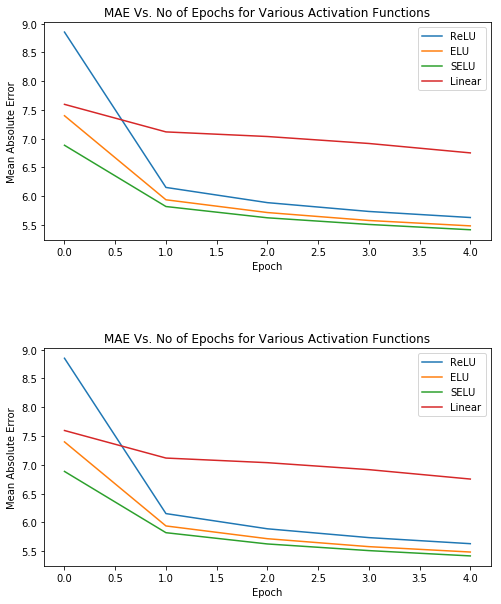

In [34]:
import matplotlib.pyplot as plt
def plot_history(history, history2, history3, history4, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    axes[0].plot(history4.history[metric])
    #axes[0].plot(history5.history[metric])
    #axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    #axes[1].plot(history5.history['loss'])
    #axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam_relu, denoise_history_adam_elu, denoise_history_adam_selu, denoise_history_adam_lin, 'mean_absolute_error')

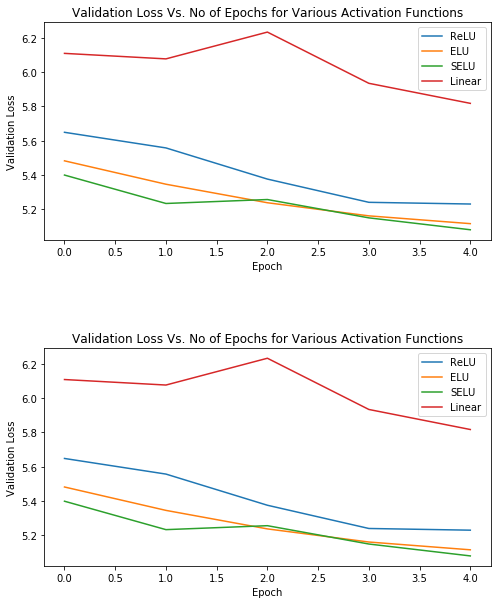

In [36]:
def plot_val_history(history, history2, history3, history4, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      #axes[0].plot(history5.history['val_'+metric])
      #axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear'], loc='upper right')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      #axes[1].plot(history5.history['val_loss'])
      #axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear'], loc='upper right')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam_relu, denoise_history_adam_elu, denoise_history_adam_selu, denoise_history_adam_lin, 'mean_absolute_error')

In [40]:
denoise_model_adam_lrelu = get_denoise_model(LeakyReLU(alpha=0.1), shape)

In [41]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

denoise_model_adam_lrelu.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])



#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam_lrelu = denoise_model_adam_lrelu.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)



### Saves optimizer and weights


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io

Epoch 1/5


 145/1816 [=>............................] - ETA: 4:03:38 - loss: 123.3193 - mean_absolute_error: 123.31 - ETA: 1:21:50 - loss: 116.3249 - mean_absolute_error: 116.32 - ETA: 49:36 - loss: 116.9437 - mean_absolute_error: 116.9437 - ETA: 41:35 - loss: 117.1026 - mean_absolute_error: 117.10 - ETA: 35:52 - loss: 114.7789 - mean_absolute_error: 114.77 - ETA: 31:35 - loss: 114.0392 - mean_absolute_error: 114.03 - ETA: 28:15 - loss: 112.8826 - mean_absolute_error: 112.88 - ETA: 25:35 - loss: 112.3303 - mean_absolute_error: 112.33 - ETA: 23:24 - loss: 111.2047 - mean_absolute_error: 111.20 - ETA: 21:34 - loss: 110.1677 - mean_absolute_error: 110.16 - ETA: 20:01 - loss: 109.2137 - mean_absolute_error: 109.21 - ETA: 18:42 - loss: 108.0811 - mean_absolute_error: 108.08 - ETA: 17:33 - loss: 107.0807 - mean_absolute_error: 107.08 - ETA: 16:33 - loss: 105.4710 - mean_absolute_error: 105.47 - ETA: 15:40 - loss: 104.2879 - mean_absolute_error: 104.28 - ETA: 14:52 - loss: 101.7853 - mean_absolute_error

 288/1816 [===>..........................] - ETA: 3:02 - loss: 28.7678 - mean_absolute_error: 28.767 - ETA: 3:01 - loss: 28.6339 - mean_absolute_error: 28.633 - ETA: 3:00 - loss: 28.5026 - mean_absolute_error: 28.502 - ETA: 3:00 - loss: 28.3740 - mean_absolute_error: 28.374 - ETA: 2:59 - loss: 28.2438 - mean_absolute_error: 28.243 - ETA: 2:58 - loss: 28.1109 - mean_absolute_error: 28.110 - ETA: 2:58 - loss: 27.9829 - mean_absolute_error: 27.982 - ETA: 2:57 - loss: 27.8536 - mean_absolute_error: 27.853 - ETA: 2:56 - loss: 27.7258 - mean_absolute_error: 27.725 - ETA: 2:56 - loss: 27.6072 - mean_absolute_error: 27.607 - ETA: 2:55 - loss: 27.4847 - mean_absolute_error: 27.484 - ETA: 2:55 - loss: 27.3722 - mean_absolute_error: 27.372 - ETA: 2:54 - loss: 27.2573 - mean_absolute_error: 27.257 - ETA: 2:53 - loss: 27.1394 - mean_absolute_error: 27.139 - ETA: 2:53 - loss: 27.0223 - mean_absolute_error: 27.022 - ETA: 2:52 - loss: 26.9064 - mean_absolute_error: 26.906 - ETA: 2:51 - loss: 26.7915 -

 437/1816 [======>.......................] - ETA: 2:06 - loss: 18.6895 - mean_absolute_error: 18.689 - ETA: 2:05 - loss: 18.6518 - mean_absolute_error: 18.651 - ETA: 2:05 - loss: 18.6139 - mean_absolute_error: 18.613 - ETA: 2:05 - loss: 18.5781 - mean_absolute_error: 18.578 - ETA: 2:05 - loss: 18.5424 - mean_absolute_error: 18.542 - ETA: 2:04 - loss: 18.5051 - mean_absolute_error: 18.505 - ETA: 2:04 - loss: 18.4691 - mean_absolute_error: 18.469 - ETA: 2:04 - loss: 18.4336 - mean_absolute_error: 18.433 - ETA: 2:04 - loss: 18.3974 - mean_absolute_error: 18.397 - ETA: 2:04 - loss: 18.3621 - mean_absolute_error: 18.362 - ETA: 2:03 - loss: 18.3255 - mean_absolute_error: 18.325 - ETA: 2:03 - loss: 18.2944 - mean_absolute_error: 18.294 - ETA: 2:03 - loss: 18.2612 - mean_absolute_error: 18.261 - ETA: 2:03 - loss: 18.2288 - mean_absolute_error: 18.228 - ETA: 2:03 - loss: 18.1946 - mean_absolute_error: 18.194 - ETA: 2:02 - loss: 18.1593 - mean_absolute_error: 18.159 - ETA: 2:02 - loss: 18.1268 -

 586/1816 [========>.....................] - ETA: 1:40 - loss: 15.0016 - mean_absolute_error: 15.001 - ETA: 1:40 - loss: 14.9854 - mean_absolute_error: 14.985 - ETA: 1:40 - loss: 14.9680 - mean_absolute_error: 14.968 - ETA: 1:39 - loss: 14.9340 - mean_absolute_error: 14.934 - ETA: 1:39 - loss: 14.9188 - mean_absolute_error: 14.918 - ETA: 1:39 - loss: 14.9045 - mean_absolute_error: 14.904 - ETA: 1:39 - loss: 14.8875 - mean_absolute_error: 14.887 - ETA: 1:39 - loss: 14.8702 - mean_absolute_error: 14.870 - ETA: 1:39 - loss: 14.8534 - mean_absolute_error: 14.853 - ETA: 1:39 - loss: 14.8374 - mean_absolute_error: 14.837 - ETA: 1:39 - loss: 14.8230 - mean_absolute_error: 14.823 - ETA: 1:38 - loss: 14.8090 - mean_absolute_error: 14.809 - ETA: 1:38 - loss: 14.7923 - mean_absolute_error: 14.792 - ETA: 1:38 - loss: 14.7775 - mean_absolute_error: 14.777 - ETA: 1:38 - loss: 14.7619 - mean_absolute_error: 14.761 - ETA: 1:38 - loss: 14.7465 - mean_absolute_error: 14.746 - ETA: 1:38 - loss: 14.7299 -

 746/1816 [===========>..................] - ETA: 1:23 - loss: 13.1344 - mean_absolute_error: 13.134 - ETA: 1:23 - loss: 13.1258 - mean_absolute_error: 13.125 - ETA: 1:23 - loss: 13.1168 - mean_absolute_error: 13.116 - ETA: 1:23 - loss: 13.1088 - mean_absolute_error: 13.108 - ETA: 1:23 - loss: 13.0985 - mean_absolute_error: 13.098 - ETA: 1:23 - loss: 13.0892 - mean_absolute_error: 13.089 - ETA: 1:23 - loss: 13.0793 - mean_absolute_error: 13.079 - ETA: 1:23 - loss: 13.0690 - mean_absolute_error: 13.069 - ETA: 1:22 - loss: 13.0601 - mean_absolute_error: 13.060 - ETA: 1:22 - loss: 13.0510 - mean_absolute_error: 13.051 - ETA: 1:22 - loss: 13.0427 - mean_absolute_error: 13.042 - ETA: 1:22 - loss: 13.0335 - mean_absolute_error: 13.033 - ETA: 1:22 - loss: 13.0244 - mean_absolute_error: 13.024 - ETA: 1:22 - loss: 13.0147 - mean_absolute_error: 13.014 - ETA: 1:22 - loss: 13.0065 - mean_absolute_error: 13.006 - ETA: 1:22 - loss: 12.9981 - mean_absolute_error: 12.998 - ETA: 1:22 - loss: 12.9891 -

 920/1816 [==============>...............] - ETA: 1:09 - loss: 11.9406 - mean_absolute_error: 11.940 - ETA: 1:09 - loss: 11.9357 - mean_absolute_error: 11.935 - ETA: 1:09 - loss: 11.9286 - mean_absolute_error: 11.928 - ETA: 1:09 - loss: 11.9224 - mean_absolute_error: 11.922 - ETA: 1:09 - loss: 11.9169 - mean_absolute_error: 11.916 - ETA: 1:08 - loss: 11.9100 - mean_absolute_error: 11.910 - ETA: 1:08 - loss: 11.9042 - mean_absolute_error: 11.904 - ETA: 1:08 - loss: 11.8985 - mean_absolute_error: 11.898 - ETA: 1:08 - loss: 11.8922 - mean_absolute_error: 11.892 - ETA: 1:08 - loss: 11.8867 - mean_absolute_error: 11.886 - ETA: 1:08 - loss: 11.8807 - mean_absolute_error: 11.880 - ETA: 1:08 - loss: 11.8697 - mean_absolute_error: 11.869 - ETA: 1:08 - loss: 11.8635 - mean_absolute_error: 11.863 - ETA: 1:08 - loss: 11.8576 - mean_absolute_error: 11.857 - ETA: 1:08 - loss: 11.8523 - mean_absolute_error: 11.852 - ETA: 1:08 - loss: 11.8470 - mean_absolute_error: 11.847 - ETA: 1:08 - loss: 11.8408 -

1077/1816 [================>.............] - ETA: 55s - loss: 11.1012 - mean_absolute_error: 11.10 - ETA: 55s - loss: 11.0961 - mean_absolute_error: 11.09 - ETA: 55s - loss: 11.0926 - mean_absolute_error: 11.09 - ETA: 55s - loss: 11.0837 - mean_absolute_error: 11.08 - ETA: 55s - loss: 11.0804 - mean_absolute_error: 11.08 - ETA: 55s - loss: 11.0764 - mean_absolute_error: 11.07 - ETA: 55s - loss: 11.0722 - mean_absolute_error: 11.07 - ETA: 55s - loss: 11.0682 - mean_absolute_error: 11.06 - ETA: 55s - loss: 11.0640 - mean_absolute_error: 11.06 - ETA: 55s - loss: 11.0603 - mean_absolute_error: 11.06 - ETA: 55s - loss: 11.0558 - mean_absolute_error: 11.05 - ETA: 55s - loss: 11.0513 - mean_absolute_error: 11.05 - ETA: 54s - loss: 11.0479 - mean_absolute_error: 11.04 - ETA: 54s - loss: 11.0435 - mean_absolute_error: 11.04 - ETA: 54s - loss: 11.0397 - mean_absolute_error: 11.03 - ETA: 54s - loss: 11.0357 - mean_absolute_error: 11.03 - ETA: 54s - loss: 11.0308 - mean_absolute_error: 11.03 - ETA

1226/1816 [===================>..........] - ETA: 45s - loss: 10.5471 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5447 - mean_absolute_error: 10.54 - ETA: 45s - loss: 10.5411 - mean_absolute_error: 10.54 - ETA: 44s - loss: 10.5377 - mean_absolute_error: 10.53 - ETA: 44s - loss: 10.5344 - mean_absolute_error: 10.53 - ETA: 44s - loss: 10.5308 - mean_absolute_error: 10.53 - ETA: 44s - loss: 10.5286 - mean_absolute_error: 10.52 - ETA: 44s - loss: 10.5254 - mean_absolute_error: 10.52 - ETA: 44s - loss: 10.5230 - mean_absolute_error: 10.52 - ETA: 44s - loss: 10.5196 - mean_absolute_error: 10.51 - ETA: 44s - loss: 10.5164 - mean_absolute_error: 10.51 - ETA: 44s - loss: 10.5135 - mean_absolute_error: 10.51 - ETA: 44s - loss: 10.5106 - mean_absolute_error: 10.51 - ETA: 44s - loss: 10.5076 - mean_absolute_error: 10.50 - ETA: 44s - loss: 10.5047 - mean_absolute_error: 10.50 - ETA: 44s - loss: 10.5022 - mean_absolute_error: 10.50 - ETA: 44s - loss: 10.4986 - mean_absolute_error: 10.49 - ETA

1378/1816 [=====================>........] - ETA: 35s - loss: 10.1425 - mean_absolute_error: 10.14 - ETA: 35s - loss: 10.1398 - mean_absolute_error: 10.13 - ETA: 35s - loss: 10.1374 - mean_absolute_error: 10.13 - ETA: 35s - loss: 10.1346 - mean_absolute_error: 10.13 - ETA: 35s - loss: 10.1319 - mean_absolute_error: 10.13 - ETA: 35s - loss: 10.1294 - mean_absolute_error: 10.12 - ETA: 35s - loss: 10.1269 - mean_absolute_error: 10.12 - ETA: 35s - loss: 10.1242 - mean_absolute_error: 10.12 - ETA: 35s - loss: 10.1217 - mean_absolute_error: 10.12 - ETA: 35s - loss: 10.1197 - mean_absolute_error: 10.11 - ETA: 34s - loss: 10.1177 - mean_absolute_error: 10.11 - ETA: 34s - loss: 10.1155 - mean_absolute_error: 10.11 - ETA: 34s - loss: 10.1136 - mean_absolute_error: 10.11 - ETA: 34s - loss: 10.1115 - mean_absolute_error: 10.11 - ETA: 34s - loss: 10.1090 - mean_absolute_error: 10.10 - ETA: 34s - loss: 10.1069 - mean_absolute_error: 10.10 - ETA: 34s - loss: 10.1045 - mean_absolute_error: 10.10 - ETA

1535/1816 [========================>.....] - ETA: 26s - loss: 9.8088 - mean_absolute_error: 9.80 - ETA: 26s - loss: 9.8068 - mean_absolute_error: 9.80 - ETA: 26s - loss: 9.8044 - mean_absolute_error: 9.80 - ETA: 25s - loss: 9.8028 - mean_absolute_error: 9.80 - ETA: 25s - loss: 9.8002 - mean_absolute_error: 9.80 - ETA: 25s - loss: 9.7989 - mean_absolute_error: 9.79 - ETA: 25s - loss: 9.7969 - mean_absolute_error: 9.79 - ETA: 25s - loss: 9.7952 - mean_absolute_error: 9.79 - ETA: 25s - loss: 9.7937 - mean_absolute_error: 9.79 - ETA: 25s - loss: 9.7916 - mean_absolute_error: 9.79 - ETA: 25s - loss: 9.7893 - mean_absolute_error: 9.78 - ETA: 25s - loss: 9.7874 - mean_absolute_error: 9.78 - ETA: 25s - loss: 9.7850 - mean_absolute_error: 9.78 - ETA: 25s - loss: 9.7833 - mean_absolute_error: 9.78 - ETA: 25s - loss: 9.7813 - mean_absolute_error: 9.78 - ETA: 25s - loss: 9.7790 - mean_absolute_error: 9.77 - ETA: 25s - loss: 9.7770 - mean_absolute_error: 9.77 - ETA: 25s - loss: 9.7760 - mean_absolu

1696/1816 [===========================>..] - ETA: 16s - loss: 9.5345 - mean_absolute_error: 9.53 - ETA: 16s - loss: 9.5335 - mean_absolute_error: 9.53 - ETA: 16s - loss: 9.5318 - mean_absolute_error: 9.53 - ETA: 16s - loss: 9.5301 - mean_absolute_error: 9.53 - ETA: 16s - loss: 9.5283 - mean_absolute_error: 9.52 - ETA: 16s - loss: 9.5269 - mean_absolute_error: 9.52 - ETA: 16s - loss: 9.5258 - mean_absolute_error: 9.52 - ETA: 16s - loss: 9.5245 - mean_absolute_error: 9.52 - ETA: 16s - loss: 9.5228 - mean_absolute_error: 9.52 - ETA: 16s - loss: 9.5210 - mean_absolute_error: 9.52 - ETA: 15s - loss: 9.5183 - mean_absolute_error: 9.51 - ETA: 15s - loss: 9.5152 - mean_absolute_error: 9.51 - ETA: 15s - loss: 9.5139 - mean_absolute_error: 9.51 - ETA: 15s - loss: 9.5121 - mean_absolute_error: 9.51 - ETA: 15s - loss: 9.5100 - mean_absolute_error: 9.51 - ETA: 15s - loss: 9.5088 - mean_absolute_error: 9.50 - ETA: 15s - loss: 9.5069 - mean_absolute_error: 9.50 - ETA: 15s - loss: 9.5058 - mean_absolu

1816/1816 [==============================] - ETA: 6s - loss: 9.3002 - mean_absolute_error: 9.300 - ETA: 6s - loss: 9.2984 - mean_absolute_error: 9.298 - ETA: 6s - loss: 9.2972 - mean_absolute_error: 9.297 - ETA: 6s - loss: 9.2958 - mean_absolute_error: 9.295 - ETA: 6s - loss: 9.2946 - mean_absolute_error: 9.294 - ETA: 6s - loss: 9.2937 - mean_absolute_error: 9.293 - ETA: 6s - loss: 9.2926 - mean_absolute_error: 9.292 - ETA: 6s - loss: 9.2913 - mean_absolute_error: 9.291 - ETA: 6s - loss: 9.2896 - mean_absolute_error: 9.289 - ETA: 6s - loss: 9.2880 - mean_absolute_error: 9.288 - ETA: 6s - loss: 9.2861 - mean_absolute_error: 9.286 - ETA: 6s - loss: 9.2836 - mean_absolute_error: 9.283 - ETA: 6s - loss: 9.2821 - mean_absolute_error: 9.282 - ETA: 6s - loss: 9.2807 - mean_absolute_error: 9.280 - ETA: 6s - loss: 9.2799 - mean_absolute_error: 9.279 - ETA: 6s - loss: 9.2785 - mean_absolute_error: 9.278 - ETA: 5s - loss: 9.2770 - mean_absolute_error: 9.277 - ETA: 5s - loss: 9.2756 - mean_absolut

 155/1816 [=>............................] - ETA: 1:32 - loss: 6.7905 - mean_absolute_error: 6.790 - ETA: 1:43 - loss: 6.9884 - mean_absolute_error: 6.988 - ETA: 2:02 - loss: 6.9640 - mean_absolute_error: 6.964 - ETA: 1:55 - loss: 6.8952 - mean_absolute_error: 6.895 - ETA: 1:51 - loss: 6.9121 - mean_absolute_error: 6.912 - ETA: 1:48 - loss: 6.9432 - mean_absolute_error: 6.943 - ETA: 1:46 - loss: 6.9358 - mean_absolute_error: 6.935 - ETA: 1:45 - loss: 6.8263 - mean_absolute_error: 6.826 - ETA: 1:44 - loss: 6.8652 - mean_absolute_error: 6.865 - ETA: 1:43 - loss: 6.9059 - mean_absolute_error: 6.905 - ETA: 1:42 - loss: 6.9257 - mean_absolute_error: 6.925 - ETA: 1:41 - loss: 6.8995 - mean_absolute_error: 6.899 - ETA: 1:41 - loss: 6.9052 - mean_absolute_error: 6.905 - ETA: 1:39 - loss: 6.9247 - mean_absolute_error: 6.924 - ETA: 1:37 - loss: 6.9808 - mean_absolute_error: 6.980 - ETA: 1:37 - loss: 6.9710 - mean_absolute_error: 6.971 - ETA: 1:37 - loss: 6.9932 - mean_absolute_error: 6.993 - ETA

 307/1816 [====>.........................] - ETA: 1:30 - loss: 6.9334 - mean_absolute_error: 6.933 - ETA: 1:30 - loss: 6.9327 - mean_absolute_error: 6.932 - ETA: 1:30 - loss: 6.9333 - mean_absolute_error: 6.933 - ETA: 1:30 - loss: 6.9298 - mean_absolute_error: 6.929 - ETA: 1:30 - loss: 6.9337 - mean_absolute_error: 6.933 - ETA: 1:30 - loss: 6.9349 - mean_absolute_error: 6.934 - ETA: 1:30 - loss: 6.9386 - mean_absolute_error: 6.938 - ETA: 1:30 - loss: 6.9361 - mean_absolute_error: 6.936 - ETA: 1:30 - loss: 6.9377 - mean_absolute_error: 6.937 - ETA: 1:30 - loss: 6.9329 - mean_absolute_error: 6.932 - ETA: 1:30 - loss: 6.9298 - mean_absolute_error: 6.929 - ETA: 1:30 - loss: 6.9314 - mean_absolute_error: 6.931 - ETA: 1:30 - loss: 6.9313 - mean_absolute_error: 6.931 - ETA: 1:30 - loss: 6.9289 - mean_absolute_error: 6.928 - ETA: 1:30 - loss: 6.9339 - mean_absolute_error: 6.933 - ETA: 1:30 - loss: 6.9377 - mean_absolute_error: 6.937 - ETA: 1:30 - loss: 6.9422 - mean_absolute_error: 6.942 - ETA

 465/1816 [======>.......................] - ETA: 1:22 - loss: 6.9061 - mean_absolute_error: 6.906 - ETA: 1:22 - loss: 6.9102 - mean_absolute_error: 6.910 - ETA: 1:22 - loss: 6.9085 - mean_absolute_error: 6.908 - ETA: 1:22 - loss: 6.9080 - mean_absolute_error: 6.908 - ETA: 1:22 - loss: 6.9072 - mean_absolute_error: 6.907 - ETA: 1:22 - loss: 6.9067 - mean_absolute_error: 6.906 - ETA: 1:22 - loss: 6.9044 - mean_absolute_error: 6.904 - ETA: 1:21 - loss: 6.9038 - mean_absolute_error: 6.903 - ETA: 1:21 - loss: 6.9008 - mean_absolute_error: 6.900 - ETA: 1:21 - loss: 6.9008 - mean_absolute_error: 6.900 - ETA: 1:21 - loss: 6.9008 - mean_absolute_error: 6.900 - ETA: 1:21 - loss: 6.9014 - mean_absolute_error: 6.901 - ETA: 1:21 - loss: 6.9014 - mean_absolute_error: 6.901 - ETA: 1:21 - loss: 6.8995 - mean_absolute_error: 6.899 - ETA: 1:21 - loss: 6.8972 - mean_absolute_error: 6.897 - ETA: 1:21 - loss: 6.8980 - mean_absolute_error: 6.898 - ETA: 1:21 - loss: 6.8993 - mean_absolute_error: 6.899 - ETA

 633/1816 [=========>....................] - ETA: 1:13 - loss: 6.8559 - mean_absolute_error: 6.855 - ETA: 1:13 - loss: 6.8548 - mean_absolute_error: 6.854 - ETA: 1:13 - loss: 6.8543 - mean_absolute_error: 6.854 - ETA: 1:13 - loss: 6.8546 - mean_absolute_error: 6.854 - ETA: 1:12 - loss: 6.8521 - mean_absolute_error: 6.852 - ETA: 1:12 - loss: 6.8517 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8511 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8521 - mean_absolute_error: 6.852 - ETA: 1:12 - loss: 6.8518 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8508 - mean_absolute_error: 6.850 - ETA: 1:12 - loss: 6.8513 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8518 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8504 - mean_absolute_error: 6.850 - ETA: 1:12 - loss: 6.8511 - mean_absolute_error: 6.851 - ETA: 1:12 - loss: 6.8501 - mean_absolute_error: 6.850 - ETA: 1:12 - loss: 6.8498 - mean_absolute_error: 6.849 - ETA: 1:12 - loss: 6.8498 - mean_absolute_error: 6.849 - ETA

 809/1816 [============>.................] - ETA: 1:03 - loss: 6.8279 - mean_absolute_error: 6.827 - ETA: 1:03 - loss: 6.8290 - mean_absolute_error: 6.829 - ETA: 1:03 - loss: 6.8282 - mean_absolute_error: 6.828 - ETA: 1:03 - loss: 6.8269 - mean_absolute_error: 6.826 - ETA: 1:03 - loss: 6.8262 - mean_absolute_error: 6.826 - ETA: 1:03 - loss: 6.8252 - mean_absolute_error: 6.825 - ETA: 1:03 - loss: 6.8250 - mean_absolute_error: 6.825 - ETA: 1:03 - loss: 6.8249 - mean_absolute_error: 6.824 - ETA: 1:03 - loss: 6.8239 - mean_absolute_error: 6.823 - ETA: 1:03 - loss: 6.8243 - mean_absolute_error: 6.824 - ETA: 1:03 - loss: 6.8238 - mean_absolute_error: 6.823 - ETA: 1:03 - loss: 6.8240 - mean_absolute_error: 6.824 - ETA: 1:03 - loss: 6.8237 - mean_absolute_error: 6.823 - ETA: 1:02 - loss: 6.8234 - mean_absolute_error: 6.823 - ETA: 1:02 - loss: 6.8230 - mean_absolute_error: 6.823 - ETA: 1:02 - loss: 6.8219 - mean_absolute_error: 6.821 - ETA: 1:02 - loss: 6.8221 - mean_absolute_error: 6.822 - ETA

 977/1816 [===============>..............] - ETA: 53s - loss: 6.7866 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7864 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7861 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7846 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7841 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7848 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7846 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7839 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7836 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7836 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7833 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7825 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7828 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7826 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7828 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7830 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7826 - mean_absolute_error: 6.78 - ETA: 53s - loss: 6.7829 - mean_absolu

1141/1816 [=================>............] - ETA: 44s - loss: 6.7376 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7372 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7373 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7358 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7354 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7357 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7347 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7341 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7337 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7334 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7333 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7336 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7331 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7331 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7330 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7327 - mean_absolute_error: 6.73 - ETA: 44s - loss: 6.7324 - mean_absolute_error: 6.73 - ETA: 43s - loss: 6.7322 - mean_absolu

1316/1816 [====================>.........] - ETA: 36s - loss: 6.7066 - mean_absolute_error: 6.70 - ETA: 36s - loss: 6.7061 - mean_absolute_error: 6.70 - ETA: 36s - loss: 6.7058 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7062 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7057 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7057 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7053 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7055 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7052 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7044 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7040 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7033 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7032 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7031 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7032 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7030 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7030 - mean_absolute_error: 6.70 - ETA: 35s - loss: 6.7034 - mean_absolu

1495/1816 [=======================>......] - ETA: 26s - loss: 6.6624 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6620 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6616 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6613 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6611 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6611 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6610 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6606 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6601 - mean_absolute_error: 6.66 - ETA: 26s - loss: 6.6599 - mean_absolute_error: 6.65 - ETA: 26s - loss: 6.6595 - mean_absolute_error: 6.65 - ETA: 26s - loss: 6.6593 - mean_absolute_error: 6.65 - ETA: 26s - loss: 6.6590 - mean_absolute_error: 6.65 - ETA: 26s - loss: 6.6590 - mean_absolute_error: 6.65 - ETA: 25s - loss: 6.6586 - mean_absolute_error: 6.65 - ETA: 25s - loss: 6.6582 - mean_absolute_error: 6.65 - ETA: 25s - loss: 6.6581 - mean_absolute_error: 6.65 - ETA: 25s - loss: 6.6580 - mean_absolu

1672/1816 [==========================>...] - ETA: 17s - loss: 6.6180 - mean_absolute_error: 6.61 - ETA: 17s - loss: 6.6177 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6173 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6169 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6165 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6164 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6163 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6161 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6153 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6148 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6139 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6139 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6131 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6131 - mean_absolute_error: 6.61 - ETA: 16s - loss: 6.6131 - mean_absolute_error: 6.61 - ETA: 15s - loss: 6.6125 - mean_absolute_error: 6.61 - ETA: 15s - loss: 6.6122 - mean_absolute_error: 6.61 - ETA: 15s - loss: 6.6119 - mean_absolu

1816/1816 [==============================] - ETA: 7s - loss: 6.5794 - mean_absolute_error: 6.579 - ETA: 7s - loss: 6.5788 - mean_absolute_error: 6.578 - ETA: 7s - loss: 6.5786 - mean_absolute_error: 6.578 - ETA: 7s - loss: 6.5782 - mean_absolute_error: 6.578 - ETA: 7s - loss: 6.5778 - mean_absolute_error: 6.577 - ETA: 7s - loss: 6.5777 - mean_absolute_error: 6.577 - ETA: 7s - loss: 6.5772 - mean_absolute_error: 6.577 - ETA: 7s - loss: 6.5770 - mean_absolute_error: 6.577 - ETA: 7s - loss: 6.5767 - mean_absolute_error: 6.576 - ETA: 7s - loss: 6.5760 - mean_absolute_error: 6.576 - ETA: 7s - loss: 6.5758 - mean_absolute_error: 6.575 - ETA: 7s - loss: 6.5755 - mean_absolute_error: 6.575 - ETA: 6s - loss: 6.5752 - mean_absolute_error: 6.575 - ETA: 6s - loss: 6.5746 - mean_absolute_error: 6.574 - ETA: 6s - loss: 6.5738 - mean_absolute_error: 6.573 - ETA: 6s - loss: 6.5736 - mean_absolute_error: 6.573 - ETA: 6s - loss: 6.5732 - mean_absolute_error: 6.573 - ETA: 6s - loss: 6.5734 - mean_absolut

 165/1816 [=>............................] - ETA: 1:12 - loss: 6.5033 - mean_absolute_error: 6.503 - ETA: 1:31 - loss: 6.0834 - mean_absolute_error: 6.083 - ETA: 2:00 - loss: 6.1455 - mean_absolute_error: 6.145 - ETA: 1:55 - loss: 6.2608 - mean_absolute_error: 6.260 - ETA: 1:53 - loss: 6.3164 - mean_absolute_error: 6.316 - ETA: 1:53 - loss: 6.3041 - mean_absolute_error: 6.304 - ETA: 1:52 - loss: 6.3086 - mean_absolute_error: 6.308 - ETA: 1:50 - loss: 6.3058 - mean_absolute_error: 6.305 - ETA: 1:45 - loss: 6.3748 - mean_absolute_error: 6.374 - ETA: 1:44 - loss: 6.4197 - mean_absolute_error: 6.419 - ETA: 1:43 - loss: 6.4114 - mean_absolute_error: 6.411 - ETA: 1:42 - loss: 6.4293 - mean_absolute_error: 6.429 - ETA: 1:39 - loss: 6.3702 - mean_absolute_error: 6.370 - ETA: 1:39 - loss: 6.3525 - mean_absolute_error: 6.352 - ETA: 1:39 - loss: 6.3500 - mean_absolute_error: 6.350 - ETA: 1:38 - loss: 6.3286 - mean_absolute_error: 6.328 - ETA: 1:37 - loss: 6.3270 - mean_absolute_error: 6.327 - ETA

 321/1816 [====>.........................] - ETA: 1:28 - loss: 6.1909 - mean_absolute_error: 6.190 - ETA: 1:28 - loss: 6.1930 - mean_absolute_error: 6.193 - ETA: 1:28 - loss: 6.1942 - mean_absolute_error: 6.194 - ETA: 1:28 - loss: 6.1896 - mean_absolute_error: 6.189 - ETA: 1:28 - loss: 6.1897 - mean_absolute_error: 6.189 - ETA: 1:28 - loss: 6.1902 - mean_absolute_error: 6.190 - ETA: 1:28 - loss: 6.1924 - mean_absolute_error: 6.192 - ETA: 1:28 - loss: 6.1880 - mean_absolute_error: 6.188 - ETA: 1:28 - loss: 6.1871 - mean_absolute_error: 6.187 - ETA: 1:28 - loss: 6.1834 - mean_absolute_error: 6.183 - ETA: 1:27 - loss: 6.1829 - mean_absolute_error: 6.182 - ETA: 1:27 - loss: 6.1805 - mean_absolute_error: 6.180 - ETA: 1:27 - loss: 6.1790 - mean_absolute_error: 6.179 - ETA: 1:28 - loss: 6.1768 - mean_absolute_error: 6.176 - ETA: 1:27 - loss: 6.1766 - mean_absolute_error: 6.176 - ETA: 1:27 - loss: 6.1740 - mean_absolute_error: 6.174 - ETA: 1:27 - loss: 6.1730 - mean_absolute_error: 6.173 - ETA

 480/1816 [======>.......................] - ETA: 1:20 - loss: 6.1645 - mean_absolute_error: 6.164 - ETA: 1:20 - loss: 6.1647 - mean_absolute_error: 6.164 - ETA: 1:20 - loss: 6.1637 - mean_absolute_error: 6.163 - ETA: 1:20 - loss: 6.1648 - mean_absolute_error: 6.164 - ETA: 1:20 - loss: 6.1645 - mean_absolute_error: 6.164 - ETA: 1:20 - loss: 6.1634 - mean_absolute_error: 6.163 - ETA: 1:20 - loss: 6.1654 - mean_absolute_error: 6.165 - ETA: 1:19 - loss: 6.1648 - mean_absolute_error: 6.164 - ETA: 1:19 - loss: 6.1630 - mean_absolute_error: 6.163 - ETA: 1:19 - loss: 6.1607 - mean_absolute_error: 6.160 - ETA: 1:19 - loss: 6.1595 - mean_absolute_error: 6.159 - ETA: 1:19 - loss: 6.1589 - mean_absolute_error: 6.158 - ETA: 1:19 - loss: 6.1599 - mean_absolute_error: 6.159 - ETA: 1:19 - loss: 6.1612 - mean_absolute_error: 6.161 - ETA: 1:19 - loss: 6.1632 - mean_absolute_error: 6.163 - ETA: 1:19 - loss: 6.1614 - mean_absolute_error: 6.161 - ETA: 1:19 - loss: 6.1610 - mean_absolute_error: 6.161 - ETA

 633/1816 [=========>....................] - ETA: 1:11 - loss: 6.1431 - mean_absolute_error: 6.143 - ETA: 1:11 - loss: 6.1424 - mean_absolute_error: 6.142 - ETA: 1:11 - loss: 6.1421 - mean_absolute_error: 6.142 - ETA: 1:11 - loss: 6.1418 - mean_absolute_error: 6.141 - ETA: 1:11 - loss: 6.1428 - mean_absolute_error: 6.142 - ETA: 1:11 - loss: 6.1427 - mean_absolute_error: 6.142 - ETA: 1:11 - loss: 6.1444 - mean_absolute_error: 6.144 - ETA: 1:11 - loss: 6.1446 - mean_absolute_error: 6.144 - ETA: 1:11 - loss: 6.1446 - mean_absolute_error: 6.144 - ETA: 1:11 - loss: 6.1456 - mean_absolute_error: 6.145 - ETA: 1:11 - loss: 6.1462 - mean_absolute_error: 6.146 - ETA: 1:11 - loss: 6.1456 - mean_absolute_error: 6.145 - ETA: 1:10 - loss: 6.1450 - mean_absolute_error: 6.145 - ETA: 1:10 - loss: 6.1441 - mean_absolute_error: 6.144 - ETA: 1:10 - loss: 6.1437 - mean_absolute_error: 6.143 - ETA: 1:10 - loss: 6.1433 - mean_absolute_error: 6.143 - ETA: 1:10 - loss: 6.1438 - mean_absolute_error: 6.143 - ETA

 792/1816 [============>.................] - ETA: 1:03 - loss: 6.1405 - mean_absolute_error: 6.140 - ETA: 1:03 - loss: 6.1402 - mean_absolute_error: 6.140 - ETA: 1:03 - loss: 6.1397 - mean_absolute_error: 6.139 - ETA: 1:03 - loss: 6.1403 - mean_absolute_error: 6.140 - ETA: 1:03 - loss: 6.1397 - mean_absolute_error: 6.139 - ETA: 1:03 - loss: 6.1386 - mean_absolute_error: 6.138 - ETA: 1:03 - loss: 6.1388 - mean_absolute_error: 6.138 - ETA: 1:03 - loss: 6.1389 - mean_absolute_error: 6.138 - ETA: 1:03 - loss: 6.1391 - mean_absolute_error: 6.139 - ETA: 1:02 - loss: 6.1386 - mean_absolute_error: 6.138 - ETA: 1:02 - loss: 6.1387 - mean_absolute_error: 6.138 - ETA: 1:02 - loss: 6.1387 - mean_absolute_error: 6.138 - ETA: 1:02 - loss: 6.1388 - mean_absolute_error: 6.138 - ETA: 1:02 - loss: 6.1388 - mean_absolute_error: 6.138 - ETA: 1:02 - loss: 6.1397 - mean_absolute_error: 6.139 - ETA: 1:02 - loss: 6.1402 - mean_absolute_error: 6.140 - ETA: 1:02 - loss: 6.1401 - mean_absolute_error: 6.140 - ETA

 947/1816 [==============>...............] - ETA: 55s - loss: 6.1227 - mean_absolute_error: 6.12 - ETA: 55s - loss: 6.1228 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1233 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1238 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1232 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1219 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1215 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1217 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1216 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1219 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1228 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1224 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1232 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1235 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1228 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1225 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1226 - mean_absolute_error: 6.12 - ETA: 54s - loss: 6.1220 - mean_absolu

1107/1816 [=================>............] - ETA: 46s - loss: 6.1202 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1198 - mean_absolute_error: 6.11 - ETA: 46s - loss: 6.1194 - mean_absolute_error: 6.11 - ETA: 46s - loss: 6.1197 - mean_absolute_error: 6.11 - ETA: 46s - loss: 6.1206 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1203 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1205 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1205 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1213 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1215 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1219 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1212 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1210 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1206 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1202 - mean_absolute_error: 6.12 - ETA: 46s - loss: 6.1201 - mean_absolute_error: 6.12 - ETA: 45s - loss: 6.1203 - mean_absolute_error: 6.12 - ETA: 45s - loss: 6.1205 - mean_absolu

1265/1816 [===================>..........] - ETA: 38s - loss: 6.1060 - mean_absolute_error: 6.10 - ETA: 38s - loss: 6.1057 - mean_absolute_error: 6.10 - ETA: 38s - loss: 6.1060 - mean_absolute_error: 6.10 - ETA: 38s - loss: 6.1059 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1055 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1057 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1055 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1054 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1049 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1050 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1047 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1041 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1038 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1038 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1034 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1031 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1023 - mean_absolute_error: 6.10 - ETA: 37s - loss: 6.1026 - mean_absolu

1433/1816 [======================>.......] - ETA: 29s - loss: 6.0968 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0964 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0969 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0968 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0968 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0969 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0972 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0968 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0969 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0964 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0964 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0963 - mean_absolute_error: 6.09 - ETA: 29s - loss: 6.0961 - mean_absolute_error: 6.09 - ETA: 28s - loss: 6.0960 - mean_absolute_error: 6.09 - ETA: 28s - loss: 6.0957 - mean_absolute_error: 6.09 - ETA: 28s - loss: 6.0954 - mean_absolute_error: 6.09 - ETA: 28s - loss: 6.0951 - mean_absolute_error: 6.09 - ETA: 28s - loss: 6.0951 - mean_absolu

1588/1816 [=========================>....] - ETA: 20s - loss: 6.0878 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0874 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0872 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0875 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0875 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0875 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0870 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0868 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0871 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0870 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0869 - mean_absolute_error: 6.08 - ETA: 20s - loss: 6.0870 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0865 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0867 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0865 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0865 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0867 - mean_absolute_error: 6.08 - ETA: 19s - loss: 6.0867 - mean_absolu

1743/1816 [===========================>..] - ETA: 12s - loss: 6.0772 - mean_absolute_error: 6.07 - ETA: 12s - loss: 6.0770 - mean_absolute_error: 6.07 - ETA: 12s - loss: 6.0776 - mean_absolute_error: 6.07 - ETA: 12s - loss: 6.0771 - mean_absolute_error: 6.07 - ETA: 12s - loss: 6.0769 - mean_absolute_error: 6.07 - ETA: 12s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0771 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0770 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0767 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0767 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0767 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0767 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0768 - mean_absolute_error: 6.07 - ETA: 11s - loss: 6.0763 - mean_absolu

1816/1816 [==============================] - ETA: 3s - loss: 6.0655 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0655 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0657 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0653 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0654 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0653 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0656 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0652 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0652 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0648 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0649 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0651 - mean_absolute_error: 6.065 - ETA: 3s - loss: 6.0649 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0647 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0645 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0642 - mean_absolute_error: 6.064 - ETA: 3s - loss: 6.0646 - mean_absolute_error: 6.064 - ETA: 2s - loss: 6.0645 - mean_absolut

 153/1816 [=>............................] - ETA: 1:12 - loss: 5.8797 - mean_absolute_error: 5.879 - ETA: 1:26 - loss: 5.7564 - mean_absolute_error: 5.756 - ETA: 2:09 - loss: 5.5456 - mean_absolute_error: 5.545 - ETA: 1:49 - loss: 5.7948 - mean_absolute_error: 5.794 - ETA: 1:41 - loss: 5.7580 - mean_absolute_error: 5.758 - ETA: 1:43 - loss: 5.7401 - mean_absolute_error: 5.740 - ETA: 1:39 - loss: 5.7924 - mean_absolute_error: 5.792 - ETA: 1:40 - loss: 5.8502 - mean_absolute_error: 5.850 - ETA: 1:39 - loss: 5.8608 - mean_absolute_error: 5.860 - ETA: 1:39 - loss: 5.8755 - mean_absolute_error: 5.875 - ETA: 1:38 - loss: 5.8539 - mean_absolute_error: 5.853 - ETA: 1:38 - loss: 5.8598 - mean_absolute_error: 5.859 - ETA: 1:38 - loss: 5.8641 - mean_absolute_error: 5.864 - ETA: 1:39 - loss: 5.9058 - mean_absolute_error: 5.905 - ETA: 1:38 - loss: 5.9256 - mean_absolute_error: 5.925 - ETA: 1:38 - loss: 5.9216 - mean_absolute_error: 5.921 - ETA: 1:38 - loss: 5.9282 - mean_absolute_error: 5.928 - ETA

 301/1816 [===>..........................] - ETA: 1:31 - loss: 5.9306 - mean_absolute_error: 5.930 - ETA: 1:31 - loss: 5.9312 - mean_absolute_error: 5.931 - ETA: 1:31 - loss: 5.9298 - mean_absolute_error: 5.929 - ETA: 1:31 - loss: 5.9297 - mean_absolute_error: 5.929 - ETA: 1:31 - loss: 5.9294 - mean_absolute_error: 5.929 - ETA: 1:31 - loss: 5.9254 - mean_absolute_error: 5.925 - ETA: 1:31 - loss: 5.9271 - mean_absolute_error: 5.927 - ETA: 1:30 - loss: 5.9247 - mean_absolute_error: 5.924 - ETA: 1:30 - loss: 5.9245 - mean_absolute_error: 5.924 - ETA: 1:30 - loss: 5.9236 - mean_absolute_error: 5.923 - ETA: 1:30 - loss: 5.9243 - mean_absolute_error: 5.924 - ETA: 1:30 - loss: 5.9195 - mean_absolute_error: 5.919 - ETA: 1:30 - loss: 5.9175 - mean_absolute_error: 5.917 - ETA: 1:30 - loss: 5.9146 - mean_absolute_error: 5.914 - ETA: 1:30 - loss: 5.9177 - mean_absolute_error: 5.917 - ETA: 1:30 - loss: 5.9174 - mean_absolute_error: 5.917 - ETA: 1:30 - loss: 5.9183 - mean_absolute_error: 5.918 - ETA

 448/1816 [======>.......................] - ETA: 1:23 - loss: 5.9164 - mean_absolute_error: 5.916 - ETA: 1:23 - loss: 5.9152 - mean_absolute_error: 5.915 - ETA: 1:23 - loss: 5.9132 - mean_absolute_error: 5.913 - ETA: 1:23 - loss: 5.9108 - mean_absolute_error: 5.910 - ETA: 1:23 - loss: 5.9099 - mean_absolute_error: 5.909 - ETA: 1:23 - loss: 5.9108 - mean_absolute_error: 5.910 - ETA: 1:23 - loss: 5.9104 - mean_absolute_error: 5.910 - ETA: 1:23 - loss: 5.9118 - mean_absolute_error: 5.911 - ETA: 1:22 - loss: 5.9101 - mean_absolute_error: 5.910 - ETA: 1:22 - loss: 5.9103 - mean_absolute_error: 5.910 - ETA: 1:22 - loss: 5.9101 - mean_absolute_error: 5.910 - ETA: 1:22 - loss: 5.9107 - mean_absolute_error: 5.910 - ETA: 1:22 - loss: 5.9093 - mean_absolute_error: 5.909 - ETA: 1:22 - loss: 5.9093 - mean_absolute_error: 5.909 - ETA: 1:22 - loss: 5.9096 - mean_absolute_error: 5.909 - ETA: 1:22 - loss: 5.9086 - mean_absolute_error: 5.908 - ETA: 1:22 - loss: 5.9089 - mean_absolute_error: 5.908 - ETA

 594/1816 [========>.....................] - ETA: 1:15 - loss: 5.9042 - mean_absolute_error: 5.904 - ETA: 1:15 - loss: 5.9057 - mean_absolute_error: 5.905 - ETA: 1:15 - loss: 5.9039 - mean_absolute_error: 5.903 - ETA: 1:15 - loss: 5.9049 - mean_absolute_error: 5.904 - ETA: 1:15 - loss: 5.9034 - mean_absolute_error: 5.903 - ETA: 1:15 - loss: 5.9045 - mean_absolute_error: 5.904 - ETA: 1:15 - loss: 5.9051 - mean_absolute_error: 5.905 - ETA: 1:15 - loss: 5.9048 - mean_absolute_error: 5.904 - ETA: 1:14 - loss: 5.9060 - mean_absolute_error: 5.906 - ETA: 1:14 - loss: 5.9057 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9051 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9057 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9058 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9064 - mean_absolute_error: 5.906 - ETA: 1:14 - loss: 5.9055 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9059 - mean_absolute_error: 5.905 - ETA: 1:14 - loss: 5.9047 - mean_absolute_error: 5.904 - ETA

 740/1816 [===========>..................] - ETA: 1:07 - loss: 5.8843 - mean_absolute_error: 5.884 - ETA: 1:07 - loss: 5.8847 - mean_absolute_error: 5.884 - ETA: 1:07 - loss: 5.8852 - mean_absolute_error: 5.885 - ETA: 1:07 - loss: 5.8856 - mean_absolute_error: 5.885 - ETA: 1:07 - loss: 5.8860 - mean_absolute_error: 5.886 - ETA: 1:07 - loss: 5.8854 - mean_absolute_error: 5.885 - ETA: 1:07 - loss: 5.8846 - mean_absolute_error: 5.884 - ETA: 1:07 - loss: 5.8849 - mean_absolute_error: 5.884 - ETA: 1:07 - loss: 5.8845 - mean_absolute_error: 5.884 - ETA: 1:07 - loss: 5.8840 - mean_absolute_error: 5.884 - ETA: 1:06 - loss: 5.8839 - mean_absolute_error: 5.883 - ETA: 1:06 - loss: 5.8830 - mean_absolute_error: 5.883 - ETA: 1:06 - loss: 5.8846 - mean_absolute_error: 5.884 - ETA: 1:06 - loss: 5.8843 - mean_absolute_error: 5.884 - ETA: 1:06 - loss: 5.8843 - mean_absolute_error: 5.884 - ETA: 1:06 - loss: 5.8845 - mean_absolute_error: 5.884 - ETA: 1:06 - loss: 5.8847 - mean_absolute_error: 5.884 - ETA

 893/1816 [=============>................] - ETA: 59s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 59s - loss: 5.8697 - mean_absolute_error: 5.86 - ETA: 59s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 59s - loss: 5.8703 - mean_absolute_error: 5.87 - ETA: 59s - loss: 5.8703 - mean_absolute_error: 5.87 - ETA: 59s - loss: 5.8712 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8712 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8707 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8711 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8713 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8702 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8703 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8702 - mean_absolute_error: 5.87 - ETA: 58s - loss: 5.8691 - mean_absolute_error: 5.86 - ETA: 58s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 58s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 58s - loss: 5.8692 - mean_absolute_error: 5.86 - ETA: 58s - loss: 5.8698 - mean_absolu

1046/1816 [================>.............] - ETA: 50s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8701 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8699 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8698 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8701 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8695 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8694 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8693 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8699 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8701 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8702 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8702 - mean_absolute_error: 5.87 - ETA: 50s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 49s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 49s - loss: 5.8697 - mean_absolu

1197/1816 [==================>...........] - ETA: 42s - loss: 5.8678 - mean_absolute_error: 5.86 - ETA: 42s - loss: 5.8676 - mean_absolute_error: 5.86 - ETA: 42s - loss: 5.8677 - mean_absolute_error: 5.86 - ETA: 42s - loss: 5.8671 - mean_absolute_error: 5.86 - ETA: 42s - loss: 5.8666 - mean_absolute_error: 5.86 - ETA: 42s - loss: 5.8667 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8669 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8668 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8666 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8664 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8670 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8672 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8672 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8670 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8672 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8674 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8676 - mean_absolute_error: 5.86 - ETA: 41s - loss: 5.8672 - mean_absolu

1348/1816 [=====================>........] - ETA: 34s - loss: 5.8565 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8566 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8566 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8573 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8572 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8567 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8573 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8576 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8578 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8579 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8573 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8578 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8580 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8578 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8577 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8576 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8579 - mean_absolute_error: 5.85 - ETA: 33s - loss: 5.8583 - mean_absolu

1502/1816 [=======================>......] - ETA: 25s - loss: 5.8537 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8540 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8537 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8534 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8533 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8530 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8528 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8528 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8531 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8526 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8525 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8528 - mean_absolute_error: 5.85 - ETA: 25s - loss: 5.8527 - mean_absolute_error: 5.85 - ETA: 24s - loss: 5.8525 - mean_absolute_error: 5.85 - ETA: 24s - loss: 5.8525 - mean_absolute_error: 5.85 - ETA: 24s - loss: 5.8526 - mean_absolute_error: 5.85 - ETA: 24s - loss: 5.8525 - mean_absolute_error: 5.85 - ETA: 24s - loss: 5.8526 - mean_absolu

1655/1816 [==========================>...] - ETA: 17s - loss: 5.8477 - mean_absolute_error: 5.84 - ETA: 17s - loss: 5.8480 - mean_absolute_error: 5.84 - ETA: 17s - loss: 5.8478 - mean_absolute_error: 5.84 - ETA: 17s - loss: 5.8479 - mean_absolute_error: 5.84 - ETA: 17s - loss: 5.8479 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8482 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8485 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8486 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8484 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8479 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8478 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8478 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8479 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8482 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8483 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8483 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8482 - mean_absolute_error: 5.84 - ETA: 16s - loss: 5.8476 - mean_absolu

1808/1816 [============================>.] - ETA: 8s - loss: 5.8416 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8413 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8414 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8413 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8412 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8411 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8410 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8409 - mean_absolute_error: 5.840 - ETA: 8s - loss: 5.8408 - mean_absolute_error: 5.840 - ETA: 8s - loss: 5.8409 - mean_absolute_error: 5.840 - ETA: 8s - loss: 5.8410 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8410 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8410 - mean_absolute_error: 5.841 - ETA: 8s - loss: 5.8407 - mean_absolute_error: 5.840 - ETA: 8s - loss: 5.8408 - mean_absolute_error: 5.840 - ETA: 7s - loss: 5.8408 - mean_absolute_error: 5.840 - ETA: 7s - loss: 5.8404 - mean_absolute_error: 5.840 - ETA: 7s - loss: 5.8403 - mean_absolut

1816/1816 [==============================] - ETA: 0s - loss: 5.8367 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8368 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8368 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8367 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8367 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8361 - mean_absolute_error: 5.836 - ETA: 0s - loss: 5.8365 - mean_absolute_error: 5.836 - 107s 59ms/step - loss: 5.8364 - mean_absolute_error: 5.8364 - val_loss: 5.3681 - val_mean_absolute_error: 5.3681
Epoch 5/5


 155/1816 [=>............................] - ETA: 1:39 - loss: 6.2588 - mean_absolute_error: 6.258 - ETA: 1:39 - loss: 6.1394 - mean_absolute_error: 6.139 - ETA: 1:59 - loss: 6.0853 - mean_absolute_error: 6.085 - ETA: 1:52 - loss: 6.2032 - mean_absolute_error: 6.203 - ETA: 1:51 - loss: 6.2745 - mean_absolute_error: 6.274 - ETA: 1:50 - loss: 6.1737 - mean_absolute_error: 6.173 - ETA: 1:48 - loss: 6.1058 - mean_absolute_error: 6.105 - ETA: 1:47 - loss: 6.0928 - mean_absolute_error: 6.092 - ETA: 1:46 - loss: 6.1386 - mean_absolute_error: 6.138 - ETA: 1:45 - loss: 6.1411 - mean_absolute_error: 6.141 - ETA: 1:45 - loss: 6.1396 - mean_absolute_error: 6.139 - ETA: 1:44 - loss: 6.1330 - mean_absolute_error: 6.133 - ETA: 1:46 - loss: 6.0854 - mean_absolute_error: 6.085 - ETA: 1:45 - loss: 6.0818 - mean_absolute_error: 6.081 - ETA: 1:45 - loss: 6.0476 - mean_absolute_error: 6.047 - ETA: 1:42 - loss: 5.9913 - mean_absolute_error: 5.991 - ETA: 1:40 - loss: 5.9613 - mean_absolute_error: 5.961 - ETA

 305/1816 [====>.........................] - ETA: 1:30 - loss: 5.7771 - mean_absolute_error: 5.777 - ETA: 1:30 - loss: 5.7774 - mean_absolute_error: 5.777 - ETA: 1:30 - loss: 5.7798 - mean_absolute_error: 5.779 - ETA: 1:30 - loss: 5.7776 - mean_absolute_error: 5.777 - ETA: 1:30 - loss: 5.7770 - mean_absolute_error: 5.777 - ETA: 1:30 - loss: 5.7754 - mean_absolute_error: 5.775 - ETA: 1:30 - loss: 5.7712 - mean_absolute_error: 5.771 - ETA: 1:30 - loss: 5.7742 - mean_absolute_error: 5.774 - ETA: 1:30 - loss: 5.7732 - mean_absolute_error: 5.773 - ETA: 1:30 - loss: 5.7738 - mean_absolute_error: 5.773 - ETA: 1:30 - loss: 5.7731 - mean_absolute_error: 5.773 - ETA: 1:30 - loss: 5.7724 - mean_absolute_error: 5.772 - ETA: 1:30 - loss: 5.7719 - mean_absolute_error: 5.771 - ETA: 1:29 - loss: 5.7715 - mean_absolute_error: 5.771 - ETA: 1:29 - loss: 5.7694 - mean_absolute_error: 5.769 - ETA: 1:29 - loss: 5.7708 - mean_absolute_error: 5.770 - ETA: 1:29 - loss: 5.7695 - mean_absolute_error: 5.769 - ETA

 453/1816 [======>.......................] - ETA: 1:23 - loss: 5.7548 - mean_absolute_error: 5.754 - ETA: 1:23 - loss: 5.7544 - mean_absolute_error: 5.754 - ETA: 1:22 - loss: 5.7556 - mean_absolute_error: 5.755 - ETA: 1:22 - loss: 5.7556 - mean_absolute_error: 5.755 - ETA: 1:22 - loss: 5.7534 - mean_absolute_error: 5.753 - ETA: 1:22 - loss: 5.7539 - mean_absolute_error: 5.753 - ETA: 1:22 - loss: 5.7548 - mean_absolute_error: 5.754 - ETA: 1:22 - loss: 5.7563 - mean_absolute_error: 5.756 - ETA: 1:22 - loss: 5.7557 - mean_absolute_error: 5.755 - ETA: 1:22 - loss: 5.7559 - mean_absolute_error: 5.755 - ETA: 1:22 - loss: 5.7577 - mean_absolute_error: 5.757 - ETA: 1:22 - loss: 5.7586 - mean_absolute_error: 5.758 - ETA: 1:22 - loss: 5.7591 - mean_absolute_error: 5.759 - ETA: 1:22 - loss: 5.7585 - mean_absolute_error: 5.758 - ETA: 1:22 - loss: 5.7570 - mean_absolute_error: 5.757 - ETA: 1:22 - loss: 5.7557 - mean_absolute_error: 5.755 - ETA: 1:22 - loss: 5.7544 - mean_absolute_error: 5.754 - ETA

 606/1816 [=========>....................] - ETA: 1:14 - loss: 5.7514 - mean_absolute_error: 5.751 - ETA: 1:14 - loss: 5.7506 - mean_absolute_error: 5.750 - ETA: 1:14 - loss: 5.7501 - mean_absolute_error: 5.750 - ETA: 1:14 - loss: 5.7502 - mean_absolute_error: 5.750 - ETA: 1:14 - loss: 5.7501 - mean_absolute_error: 5.750 - ETA: 1:14 - loss: 5.7482 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7477 - mean_absolute_error: 5.747 - ETA: 1:14 - loss: 5.7481 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7479 - mean_absolute_error: 5.747 - ETA: 1:14 - loss: 5.7480 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7481 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7488 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7494 - mean_absolute_error: 5.749 - ETA: 1:14 - loss: 5.7489 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7491 - mean_absolute_error: 5.749 - ETA: 1:14 - loss: 5.7483 - mean_absolute_error: 5.748 - ETA: 1:14 - loss: 5.7478 - mean_absolute_error: 5.747 - ETA

 755/1816 [===========>..................] - ETA: 1:06 - loss: 5.7446 - mean_absolute_error: 5.744 - ETA: 1:06 - loss: 5.7449 - mean_absolute_error: 5.744 - ETA: 1:06 - loss: 5.7453 - mean_absolute_error: 5.745 - ETA: 1:06 - loss: 5.7450 - mean_absolute_error: 5.745 - ETA: 1:05 - loss: 5.7430 - mean_absolute_error: 5.743 - ETA: 1:05 - loss: 5.7429 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7432 - mean_absolute_error: 5.743 - ETA: 1:05 - loss: 5.7429 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7417 - mean_absolute_error: 5.741 - ETA: 1:05 - loss: 5.7422 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7422 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7434 - mean_absolute_error: 5.743 - ETA: 1:05 - loss: 5.7428 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7418 - mean_absolute_error: 5.741 - ETA: 1:05 - loss: 5.7428 - mean_absolute_error: 5.742 - ETA: 1:05 - loss: 5.7430 - mean_absolute_error: 5.743 - ETA: 1:05 - loss: 5.7446 - mean_absolute_error: 5.744 - ETA

 910/1816 [==============>...............] - ETA: 58s - loss: 5.7495 - mean_absolute_error: 5.74 - ETA: 58s - loss: 5.7499 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7493 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7503 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7505 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7505 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7506 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7503 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7501 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7504 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7502 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7498 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7501 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7505 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7504 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7502 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7508 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7505 - mean_absolu

1064/1816 [================>.............] - ETA: 49s - loss: 5.7417 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7418 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7411 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7407 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7406 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7407 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7400 - mean_absolute_error: 5.74 - ETA: 49s - loss: 5.7393 - mean_absolute_error: 5.73 - ETA: 49s - loss: 5.7391 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7388 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7385 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7380 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7382 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7384 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7386 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7387 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7382 - mean_absolute_error: 5.73 - ETA: 48s - loss: 5.7372 - mean_absolu

1219/1816 [===================>..........] - ETA: 41s - loss: 5.7241 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7239 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7241 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7238 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7235 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7235 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7242 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7244 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7245 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7245 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7248 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7251 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7250 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7246 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7249 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7253 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7254 - mean_absolute_error: 5.72 - ETA: 40s - loss: 5.7250 - mean_absolu

1373/1816 [=====================>........] - ETA: 32s - loss: 5.7150 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7146 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7142 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7146 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7144 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7150 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7147 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7145 - mean_absolute_error: 5.71 - ETA: 32s - loss: 5.7145 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7143 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7143 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7143 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7140 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7135 - mean_absolute_error: 5.71 - ETA: 31s - loss: 5.7129 - mean_absolu

1525/1816 [========================>.....] - ETA: 24s - loss: 5.7055 - mean_absolute_error: 5.70 - ETA: 24s - loss: 5.7061 - mean_absolute_error: 5.70 - ETA: 24s - loss: 5.7067 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7064 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7059 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7057 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7054 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7054 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7054 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7053 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7054 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7050 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7052 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7053 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7047 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7049 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7047 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7047 - mean_absolu

1676/1816 [==========================>...] - ETA: 15s - loss: 5.7020 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7021 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7019 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7021 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7021 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7025 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7023 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7022 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7025 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7021 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7020 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7018 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7016 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7017 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7016 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7015 - mean_absolute_error: 5.70 - ETA: 15s - loss: 5.7013 - mean_absolute_error: 5.70 - ETA: 14s - loss: 5.7013 - mean_absolu

1816/1816 [==============================] - ETA: 7s - loss: 5.6950 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6954 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6958 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6958 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6957 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6956 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6958 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6955 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6954 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6951 - mean_absolute_error: 5.695 - ETA: 7s - loss: 5.6949 - mean_absolute_error: 5.694 - ETA: 7s - loss: 5.6949 - mean_absolute_error: 5.694 - ETA: 6s - loss: 5.6950 - mean_absolute_error: 5.695 - ETA: 6s - loss: 5.6946 - mean_absolute_error: 5.694 - ETA: 6s - loss: 5.6945 - mean_absolute_error: 5.694 - ETA: 6s - loss: 5.6942 - mean_absolute_error: 5.694 - ETA: 6s - loss: 5.6942 - mean_absolute_error: 5.694 - ETA: 6s - loss: 5.6940 - mean_absolut

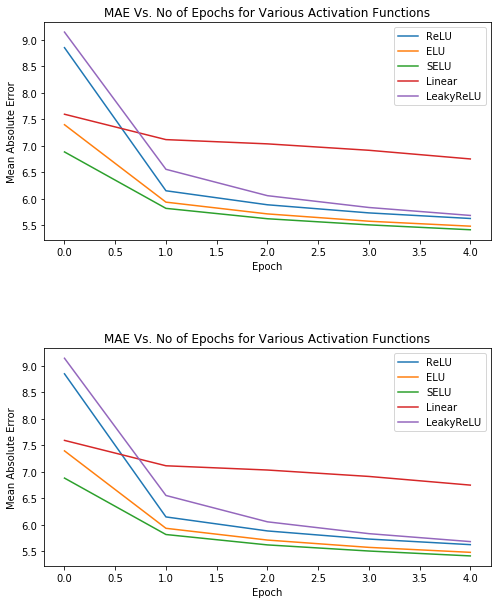

In [42]:
def plot_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    axes[0].plot(history4.history[metric])
    axes[0].plot(history5.history[metric])
    #axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    #axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam_relu, denoise_history_adam_elu, denoise_history_adam_selu, denoise_history_adam_lin, denoise_history_adam_lrelu, 'mean_absolute_error')

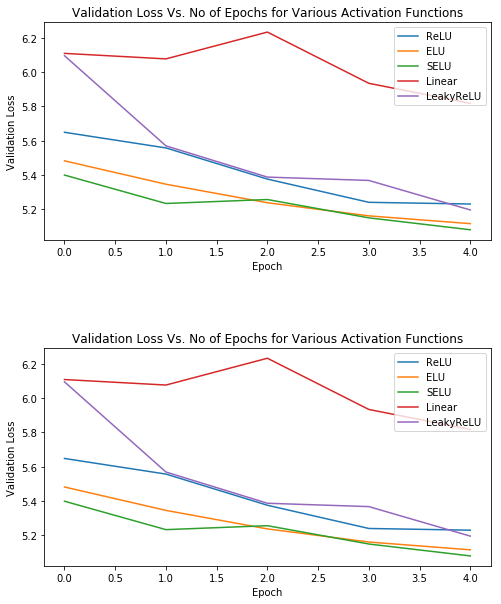

In [43]:
def plot_val_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      #axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      #axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam_relu, denoise_history_adam_elu, denoise_history_adam_selu, denoise_history_adam_lin, denoise_history_adam_lrelu, 'mean_absolute_error')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [ ]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [ ]:
### Descriptor loading and training
# Loading images
hPatches_adam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam, use_clean=False)
hPatches_adam_amsgrad = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam_amsgrad, use_clean=False)
hPatches_sgd = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_sgd, use_clean=False)
hPatches_adadelta = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adadelta, use_clean=False)
hPatches_nadam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_nadam, use_clean=False)

# Creating training generator
training_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [ ]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_adam = descriptor_model_trip.fit_generator(generator=training_generator_adam, epochs=5, verbose=1, validation_data=val_generator_adam)
descriptor_model_trip.save('descriptor_adam.h5') 

descriptor_history_adam_amsgrad = descriptor_model_trip.fit_generator(generator=training_generator_adam_amsgrad, epochs=5, verbose=1, validation_data=val_generator_adam_amsgrad)
descriptor_model_trip.save('descriptor_adam_amsgrad.h5') 

descriptor_history_sgd = descriptor_model_trip.fit_generator(generator=training_generator_sgd, epochs=5, verbose=1, validation_data=val_generator_sgd)
descriptor_model_trip.save('descriptor_sgd.h5') 

descriptor_history_adadelta = descriptor_model_trip.fit_generator(generator=training_generator_adadelta, epochs=5, verbose=1, validation_data=val_generator_adadelta)
descriptor_model_trip.save('descriptor_adadelta.h5') 

descriptor_history_nadam = descriptor_model_trip.fit_generator(generator=training_generator_nadam, epochs=5, verbose=1, validation_data=val_generator_nadam)
descriptor_model_trip.save('descriptor_nadam.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [ ]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam_amsgrad, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_sgd, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adadelta, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_, use_clean=False)


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')